In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Import libraries

In [2]:
## Adding of supplementary python packages/modules for next cells
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
# Hide warnings
import warnings
warnings.filterwarnings("ignore")

! python -m pip install -U prettytable
from prettytable import PrettyTable
! pip install lazypredict 
from lazypredict.Supervised import LazyRegressor,LazyClassifier

  Attempting uninstall: prettytable
    Found existing installation: prettytable 3.9.0
    Uninstalling prettytable-3.9.0:
      Successfully uninstalled prettytable-3.9.0


In [3]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sb.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('fivethirtyeight')

In [4]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male 22.00      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.00      1   
2                             Heikkinen, Miss. Laina  female 26.00      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.00      1   
4                           Allen, Mr. William Henry    male 35.00      0   

   Parch            Ticket  Fare Cabin Embarked  
0      0         A/5 21171  7.25   NaN        S  
1      0          PC 17599 71.28   C85        C  
2      0  STON/O2. 3101282  7.92   NaN        S  
3      0            113803 53.10  C123        S  
4      0            373450  8.05   NaN        S

In [5]:
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
dfs = [('train', df_train),('test', df_test)]
df_train['set'] = 'Train'
df_test['set'] = 'Test'
df = pd.concat([df_train,df_test],axis = 0).reset_index(drop = True)

# Variables Identification and Typecasting

In [6]:
for e in dfs:
    print('Shape_{} :{}\n'.format(e[0],e[1].shape))


Shape_train :(891, 13)

Shape_test :(418, 12)



In [7]:
#Null values and types in data
table = PrettyTable()
print('\t'+' Data{Length: '+str(df.shape)+'} \n')
data_types ={}
for i in df.columns.to_list():
    data_types[i]=str(type(df[i].loc[0]))
table.add_column("Column Name",df.columns.to_list())
table.add_column("NaN_cnt",df.isna().sum())
table.add_column("NaN_percent",df.isna().sum()/len(df))
table.add_column("Content_type",list(data_types.values()))
table.add_column("N_Unique_values",df.nunique())
print(table)

	 Data{Length: (1309, 13)} 

+-------------+---------+-----------------------+-------------------------+-----------------+
| Column Name | NaN_cnt |      NaN_percent      |       Content_type      | N_Unique_values |
+-------------+---------+-----------------------+-------------------------+-----------------+
| PassengerId |    0    |          0.0          |  <class 'numpy.int64'>  |       1309      |
|   Survived  |   418   |  0.31932773109243695  | <class 'numpy.float64'> |        2        |
|    Pclass   |    0    |          0.0          |  <class 'numpy.int64'>  |        3        |
|     Name    |    0    |          0.0          |      <class 'str'>      |       1307      |
|     Sex     |    0    |          0.0          |      <class 'str'>      |        2        |
|     Age     |   263   |  0.20091673032849502  | <class 'numpy.float64'> |        98       |
|    SibSp    |    0    |          0.0          |  <class 'numpy.int64'>  |        7        |
|    Parch    |    0    |      

In [8]:
df.describe()

PassengerId  Survived  Pclass     Age   SibSp   Parch    Fare
count      1309.00    891.00 1309.00 1046.00 1309.00 1309.00 1308.00
mean        655.00      0.38    2.29   29.88    0.50    0.39   33.30
std         378.02      0.49    0.84   14.41    1.04    0.87   51.76
min           1.00      0.00    1.00    0.17    0.00    0.00    0.00
25%         328.00      0.00    2.00   21.00    0.00    0.00    7.90
50%         655.00      0.00    3.00   28.00    0.00    0.00   14.45
75%         982.00      1.00    3.00   39.00    1.00    0.00   31.27
max        1309.00      1.00    3.00   80.00    8.00    9.00  512.33

### Observations
 > Columns content
 
Both datasets have same columns except the `Survived` column in data test set.

    We have the followings columns in this dataset:

| **`Columns`**        | **`Description`**  |  
| ------------- |-------------:|
| PassengerID  | ID of passenger |
| Pclass       |Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)    |
| Name| Passenger Name   |
| Sex  | Passenger Sex (Male or Female) |
| Age      | Passenger Age and fractional if less than 1. If the age is estimated, is it in the form of xx.5|
| SibSp | # of siblings / spouses aboard the Titanic      |
| Parch  |# of parents / children aboard the Titanic 0 for children travelled only with a nanny|
| Ticket    | Ticket number  |
| Fare      | Passenger fare|
| Cabin | Cabin number   |
| Embarked  | Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton |

 > Assessing data

**Quality issues**
- We have 20% of null values in age column. I will try to replace them in next steps.
- The Cabin column has more than 70% null values. So i will remove it from model. 
- One null value is present in Fare values.
- There are two null values in Embarked column dataset.


**Tidiness issues**
- The Embarked and sex variables should be converted as categories.

# Univariate analysis based on Target variable

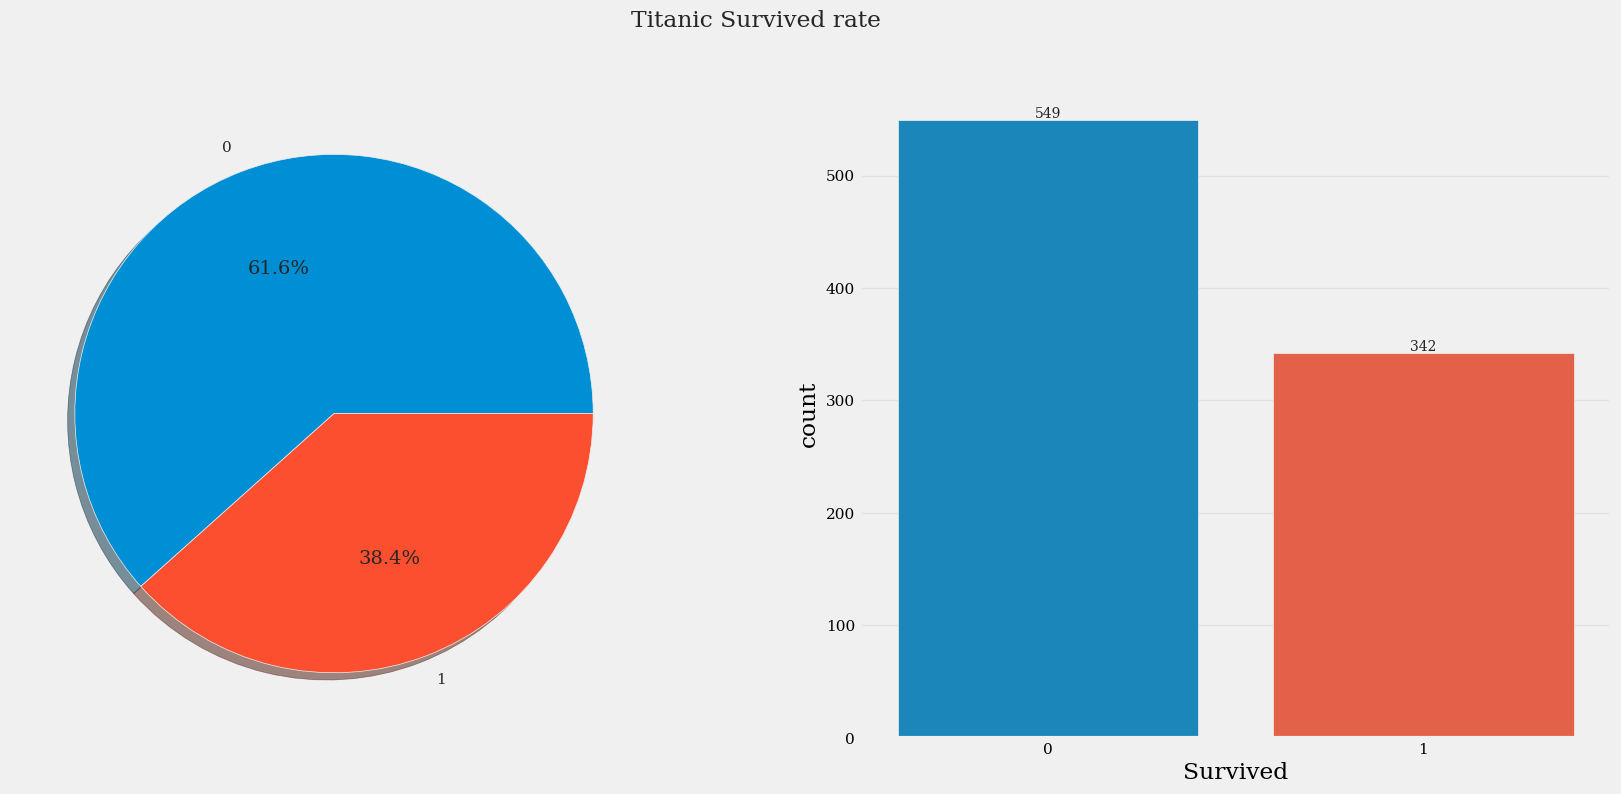

In [9]:
f,ax=plt.subplots(1,2,figsize=(19,8))
df_train['Survived'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
# ax[0].set_title('Pie-Plot')
ax[0].set_ylabel('')
ctplt = sb.countplot(x='Survived',data=df_train,ax=ax[1])
ctplt.bar_label(ctplt.containers[0], fontsize=10)
plt.suptitle('Titanic Survived rate')
plt.show()

Only 38% aboard titanic survived in our train set. Let's take look on others variables.


> Column data types

**Numerical**

*Discrete*
- Parch
- SibSp
- Pclass
- Survived

*Continuous*
- Fare
- Age

**Categorical**

*Nominal*
- PassengerId
- Embarked
- Sex
- Cabin
- Name
- Ticket

In [10]:
def UVA_numeric_discrete_on_target(data, var_group):
    '''
    Univariate analysis numeric for discrete variables here that concerns only new previous added variables
    Takes a group of variables ( INTEGER or FLOAT) and plot/print all the descriptives and properties along with KDE
    '''
    size = len(var_group)
    fig, ax = plt.subplots(size,2, figsize = [20,5*size])
    
    #looping for each variable
    for j,i in enumerate(var_group):
        
        #computing descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max()- data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()
        
        #calculating points of standard deviation
        points = mean - st_dev, mean + st_dev
        
        #Plotting the variable with every information
        #sb.histplot(ax = ax[j,0],data=data,x = data[i], hue='set', bins=50, kde=True)
        sb.kdeplot(ax = ax[j,0], data = data,x = data[i],shade = True,hue='Survived')
        sb.lineplot(ax = ax[j,0],x = points,y=[0,0], color = 'black',label = 'std_dev')
        sb.scatterplot(ax=ax[j,0],x = [mini, maxi],y = [0,0],color='orange',label = 'min/max')
        sb.scatterplot(ax=ax[j,0],x = [mean],y = [0], color = 'red',label = "mean")
        sb.scatterplot(ax=ax[j,0],x = [median],y = [0], color = 'blue',label = "median")
        ax[j,0].set_xlabel('{}'.format(i),fontsize = 20)
        ax[j,0].set_ylabel('density')
        ax[j,0].set_title('std_dev = {}; kurtosis = {}; \nskew ={}; range = {} \nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                                round(kurt,2),
                                                                                                                round(skew,2),
                                                                                                                (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                                round(mean,2),
                                                                                                                round(median,2)))
                  
    
        #base_cl = sb.color_palette()[0]
        pickp_data = data[i].value_counts(ascending=False)
        cplt = sb.countplot(data,x = i,hue='Survived',order = pickp_data.index,ax= ax[j,1])
        cplt.bar_label(cplt.containers[0], fontsize=10);
        cplt.bar_label(cplt.containers[1], fontsize=10);
        ax[j,1].set_xlabel('{}'.format(i),fontsize = 20)
        ax[j,1].set_ylabel('Count')
        #plt.legend(loc = 'upper left') # re-arrange legend to reduce overlapping"""
        plt.tight_layout(pad =2)


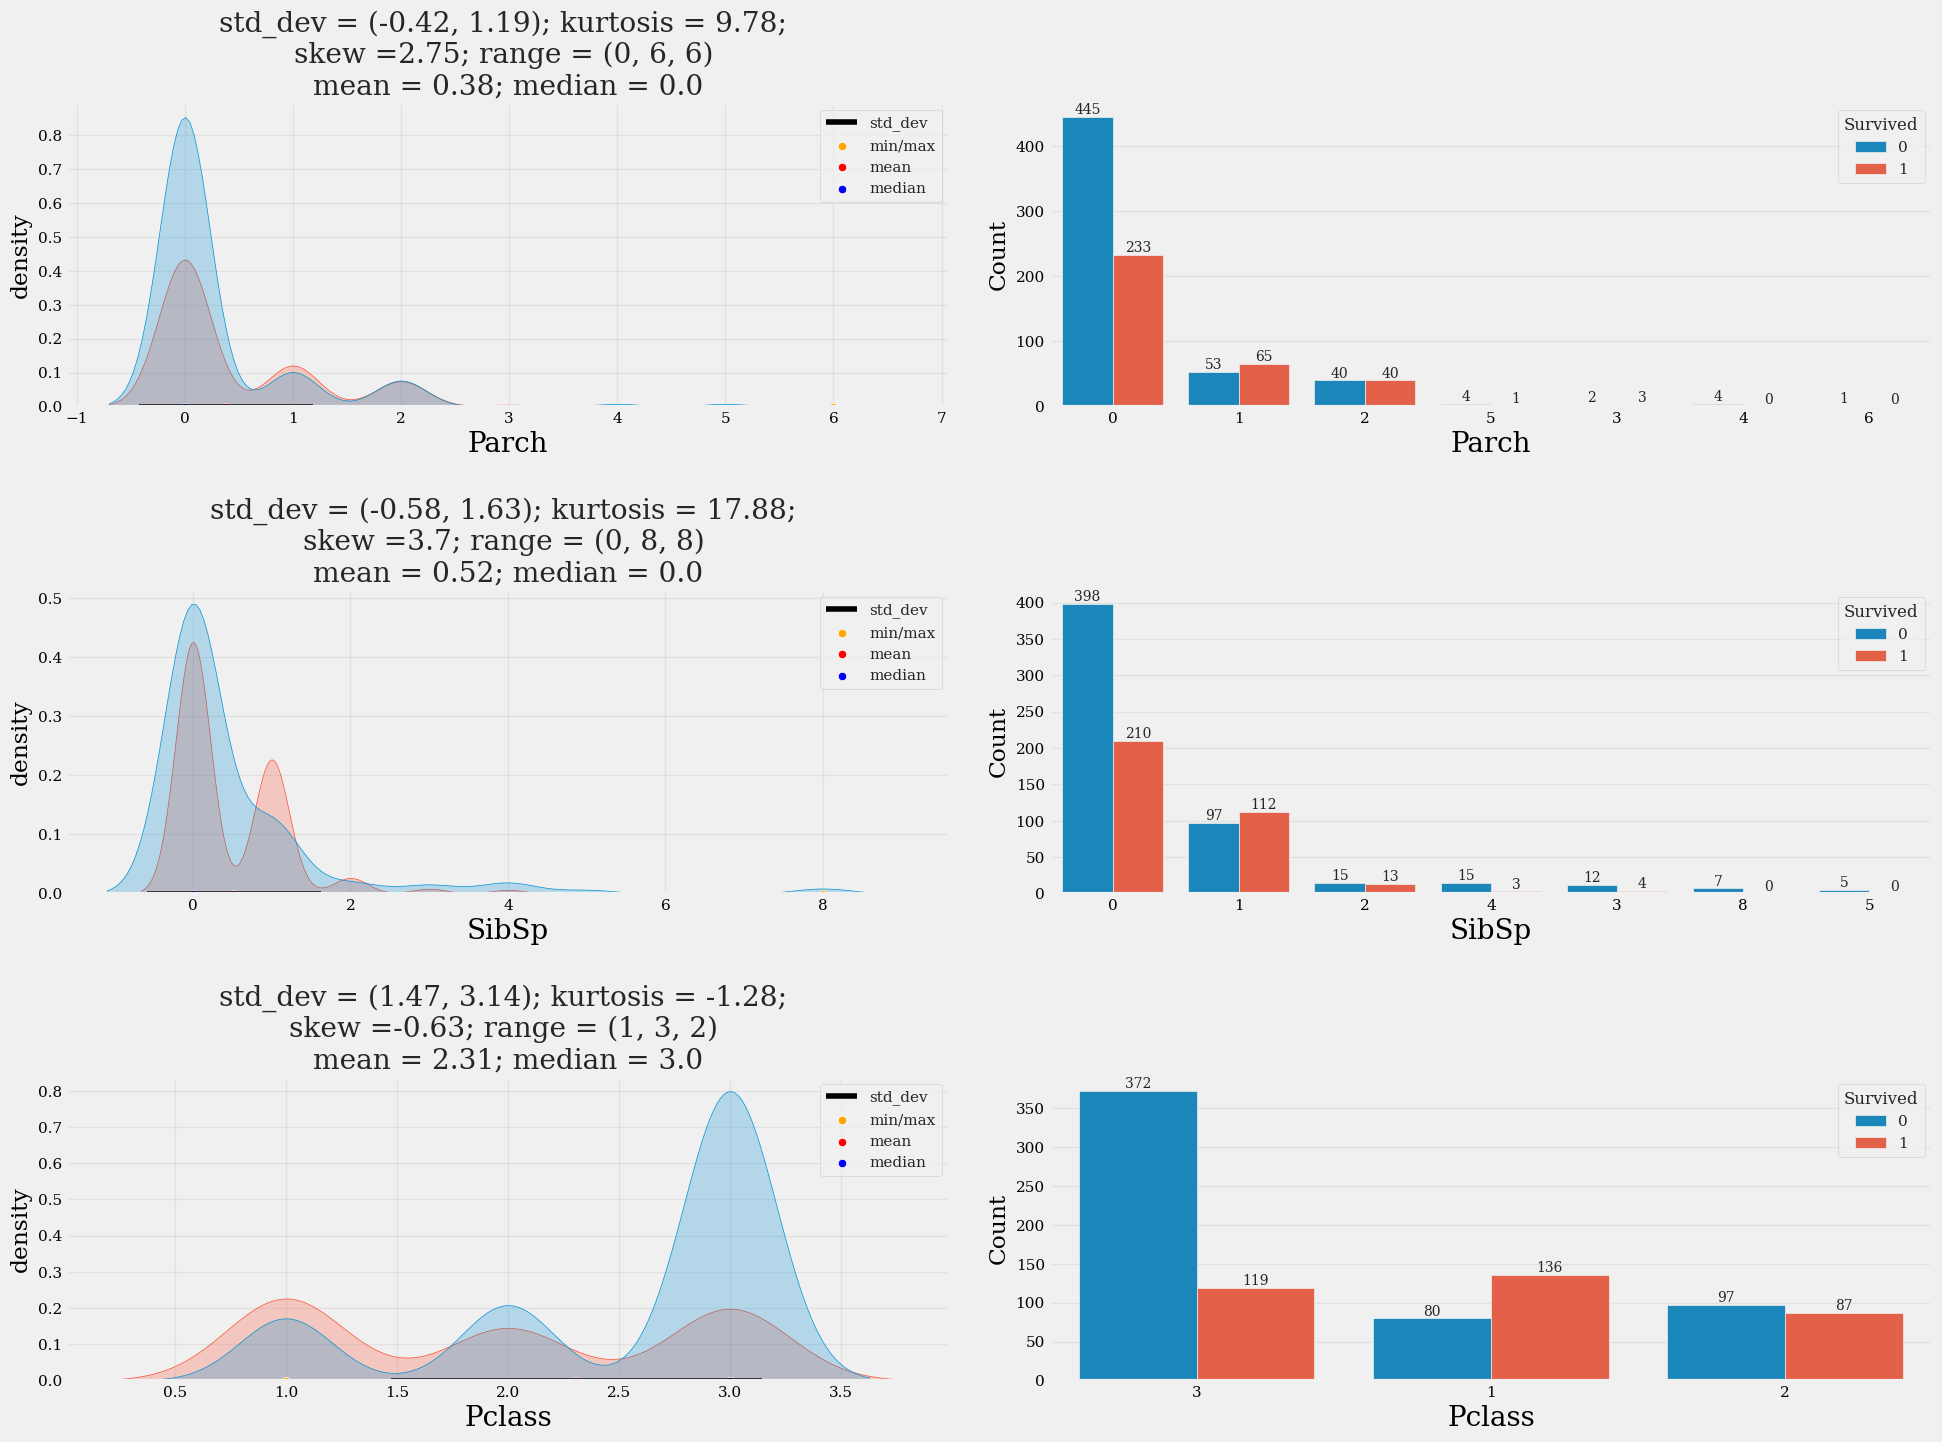

In [ ]:
UVA_numeric_discrete_on_target(df_train, ['Parch','SibSp','Pclass'])

> Observations

**SibSp & Parch**
People with one ore two siblings/spouses aboard Titanic have good survival rate. Passengers with 1-3 small family members have a surprisingly better survival rate. The size of the family surely plays a determining role in the survival on board the Titanic.

**Pclass**
1st and 2nd class passengers got better survival rate compared to a disastrous survival rate in a 3rd class cabin.

In [ ]:
def UVA_numeric_continuous_on_target(data, var_group):
    '''
    Univariate analysis numeric for continuous variables
    Takes a group of variables ( INTEGER or FLOAT) and plot/print all the descriptives and properties along with KDE and histograms
    '''
    size = len(var_group)
    fig, ax = plt.subplots(size,2, figsize = [25,5*size])
    
    #looping for each variable
    for j,i in enumerate(var_group):

        sb.histplot(ax = ax[j,0],data=data,x = data[i], hue='Survived',hue_order=[1,0],palette =['b','r'], bins=50, kde=True)
        ax[j,0].set_xlabel('{}'.format(i),fontsize = 20)
        ax[j,0].set_ylabel('density')
                  
    
        sb.boxplot(data,y = i,hue = 'Survived',orient='v',hue_order=[1,0],palette =['b','r'],ax= ax[j,1])
        ax[j,1].set_xlabel('{}'.format(i),fontsize = 20)
        plt.legend(ncol = 2) # re-arrange legend to reduce overlapping"""
        plt.tight_layout(pad =2)

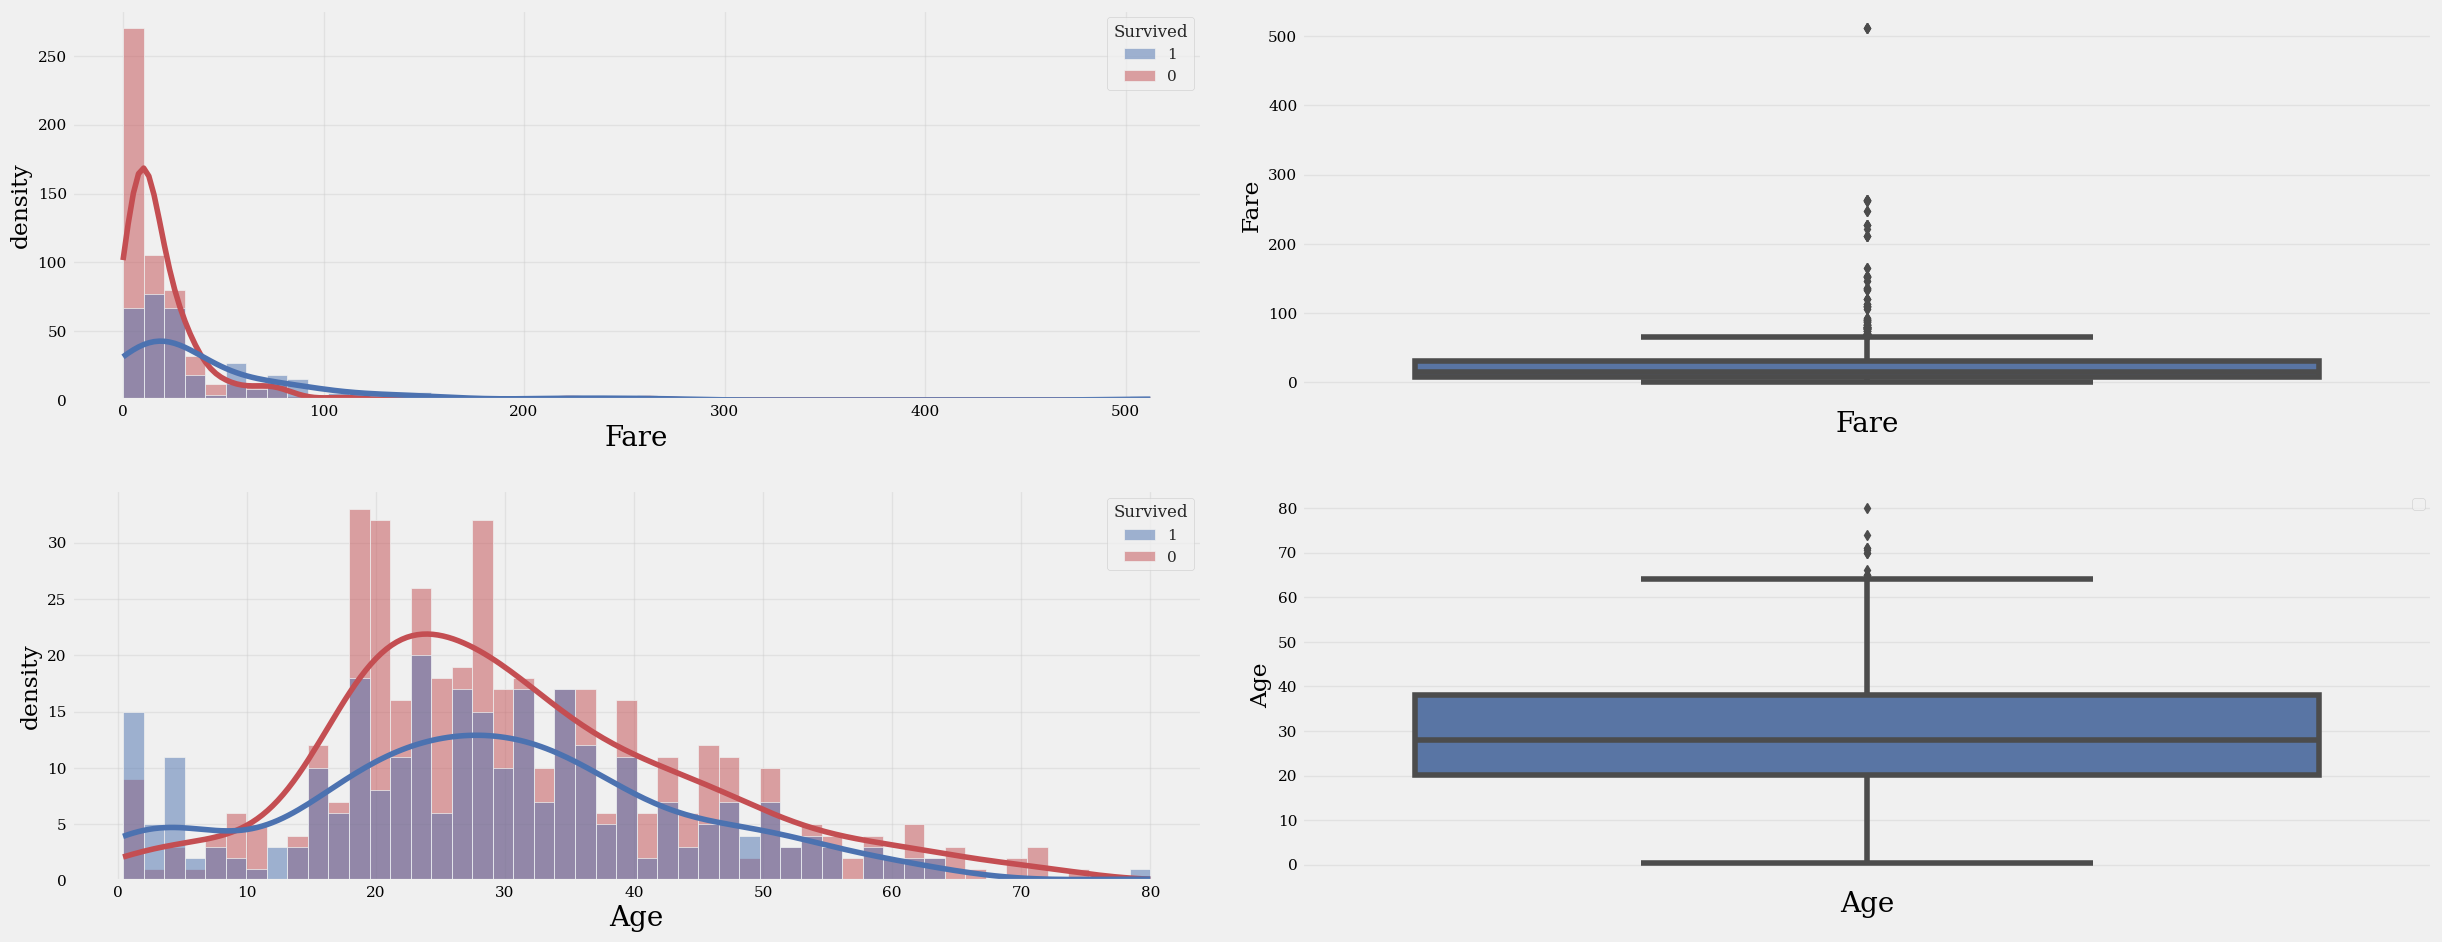

In [13]:
UVA_numeric_continuous_on_target(df_train,['Fare','Age'])

Before explore categorical variables, let's check the distributions of survived passengers per mean on each of these variables.

In [14]:
num_cols = ['Pclass','SibSp','Parch','Fare','Age']
num_dis_cols = ['Pclass','SibSp','Parch']
num_cnt_cols = ['Fare','Age']
nominal_cols = ['Ticket','Cabin', 'Embarked']

	 Survival Rate



Fare
(0.0, 51.233]        0.32
(51.233, 102.466]    0.66
(102.466, 153.699]   0.74
(153.699, 204.932]   1.00
(204.932, 256.165]   0.64
(256.165, 307.398]   0.67
(307.398, 358.63]     NaN
(358.63, 409.863]     NaN
(409.863, 461.096]    NaN
(461.096, 512.329]   1.00
Name: Survived, dtype: float64

Age
(0.42, 8.378]      0.66
(8.378, 16.336]    0.41
(16.336, 24.294]   0.36
(24.294, 32.252]   0.38
(32.252, 40.21]    0.44
(40.21, 48.168]    0.34
(48.168, 56.126]   0.47
(56.126, 64.084]   0.38
(64.084, 72.042]   0.00
(72.042, 80.0]     0.50
Name: Survived, dtype: float64

Pclass
1   0.63
2   0.47
3   0.24
Name: Survived, dtype: float64

SibSp
0   0.35
1   0.54
2   0.46
3   0.25
4   0.17
5   0.00
8   0.00
Name: Survived, dtype: float64

Parch
0   0.34
1   0.55
2   0.50
3   0.60
4   0.00
5   0.20
6   0.00
Name: Survived, dtype: float64

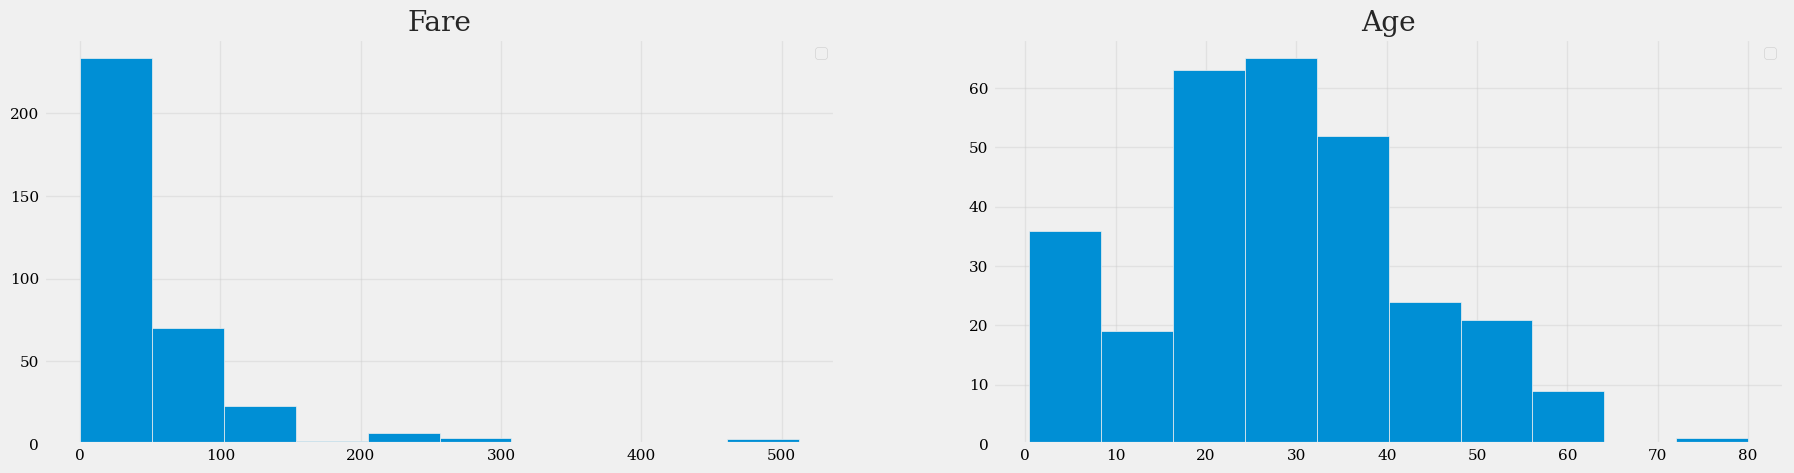

In [15]:
##  Distribution on target
i=1
f= plt.figure(figsize =(20,5))
survival_rates =[]

for col in num_cnt_cols:
    plt.subplot(1,2,i)
    n,bins,patchs = plt.hist(df_train[col].loc[df_train['Survived'] ==1])
    plt.title(col)
    plt.legend()
    i+=1
    
    #Survival rate
    survival_rates.append(pd.concat([pd.cut(df_train[col],bins),df_train['Survived']],axis = 1).groupby([col]).Survived.mean())

print('\t Survival Rate\n')
for se in survival_rates:
    display(se)
for col in num_dis_cols:
    display(df_train.groupby([col]).Survived.mean())

> Observations

**Fare**</br>
Passengers with middle or high fare ticket have significantly high survival rate. This means that people taking a first and second class cabin have a good survival rate. However, there are much outliers.

**Age**</br>
As first view, chidren and adults seem to have good survival rates. Most of passengers are between 18 and 30 years old. Normally during tragedies we privilegiate elders then women and children. Looks to be applicated in our dataset. We could seperate ages into four group: Child, teen,adult and elder. I will do it during feature engineering section. 

During feature engineering, I will try to answer these questions:
* Which age category has best survival rate?
* Is there a link between whether a passenger travels alone or in a group and the survival rate?
* How does family size affect survival rate?
* Does upper cabin class offer better survival rate than low fare cabin?

Let's see how distributed are our categorical variables. The name , passengerID and ticket columns are not usefull for visualization. So let's focus on Embarked and sex.

In [16]:
def UVA_category_on_target(data, var_group, max_categories=10):

    '''
    Univariate_Analysis_categorical
    takes a group of variables (category) and plot/print the value_counts and barplot for max_categories.
    '''
    # setting figure_size
    size = len(var_group)
    plt.figure(figsize = (6*size,30))

    # for every variable
    for j,i in enumerate(var_group):
        """norm_count = data.loc[(data['Survived'] == 1),i].value_counts(normalize = True)[:max_categories]"""
        n_uni = data[i].nunique()

        #Plotting the variable with every information
        plt.subplot(2,2,j+1)
        pickp_data = data[i].value_counts(normalize = True,ascending=False)[:max_categories]
        cplt = sb.countplot(data,x = i,hue='Survived',order = pickp_data.index)
        cplt.bar_label(cplt.containers[0], fontsize=10);
        cplt.bar_label(cplt.containers[1], fontsize=10);
        plt.xlabel('fraction/percent', fontsize = 20)
        plt.ylabel(f'{i}', fontsize = 20)
        plt.title(f'n_uniques = {n_uni} on {data.shape[0]} \n value counts \n {pickp_data[:3]}')
        plt.tight_layout(pad=3)

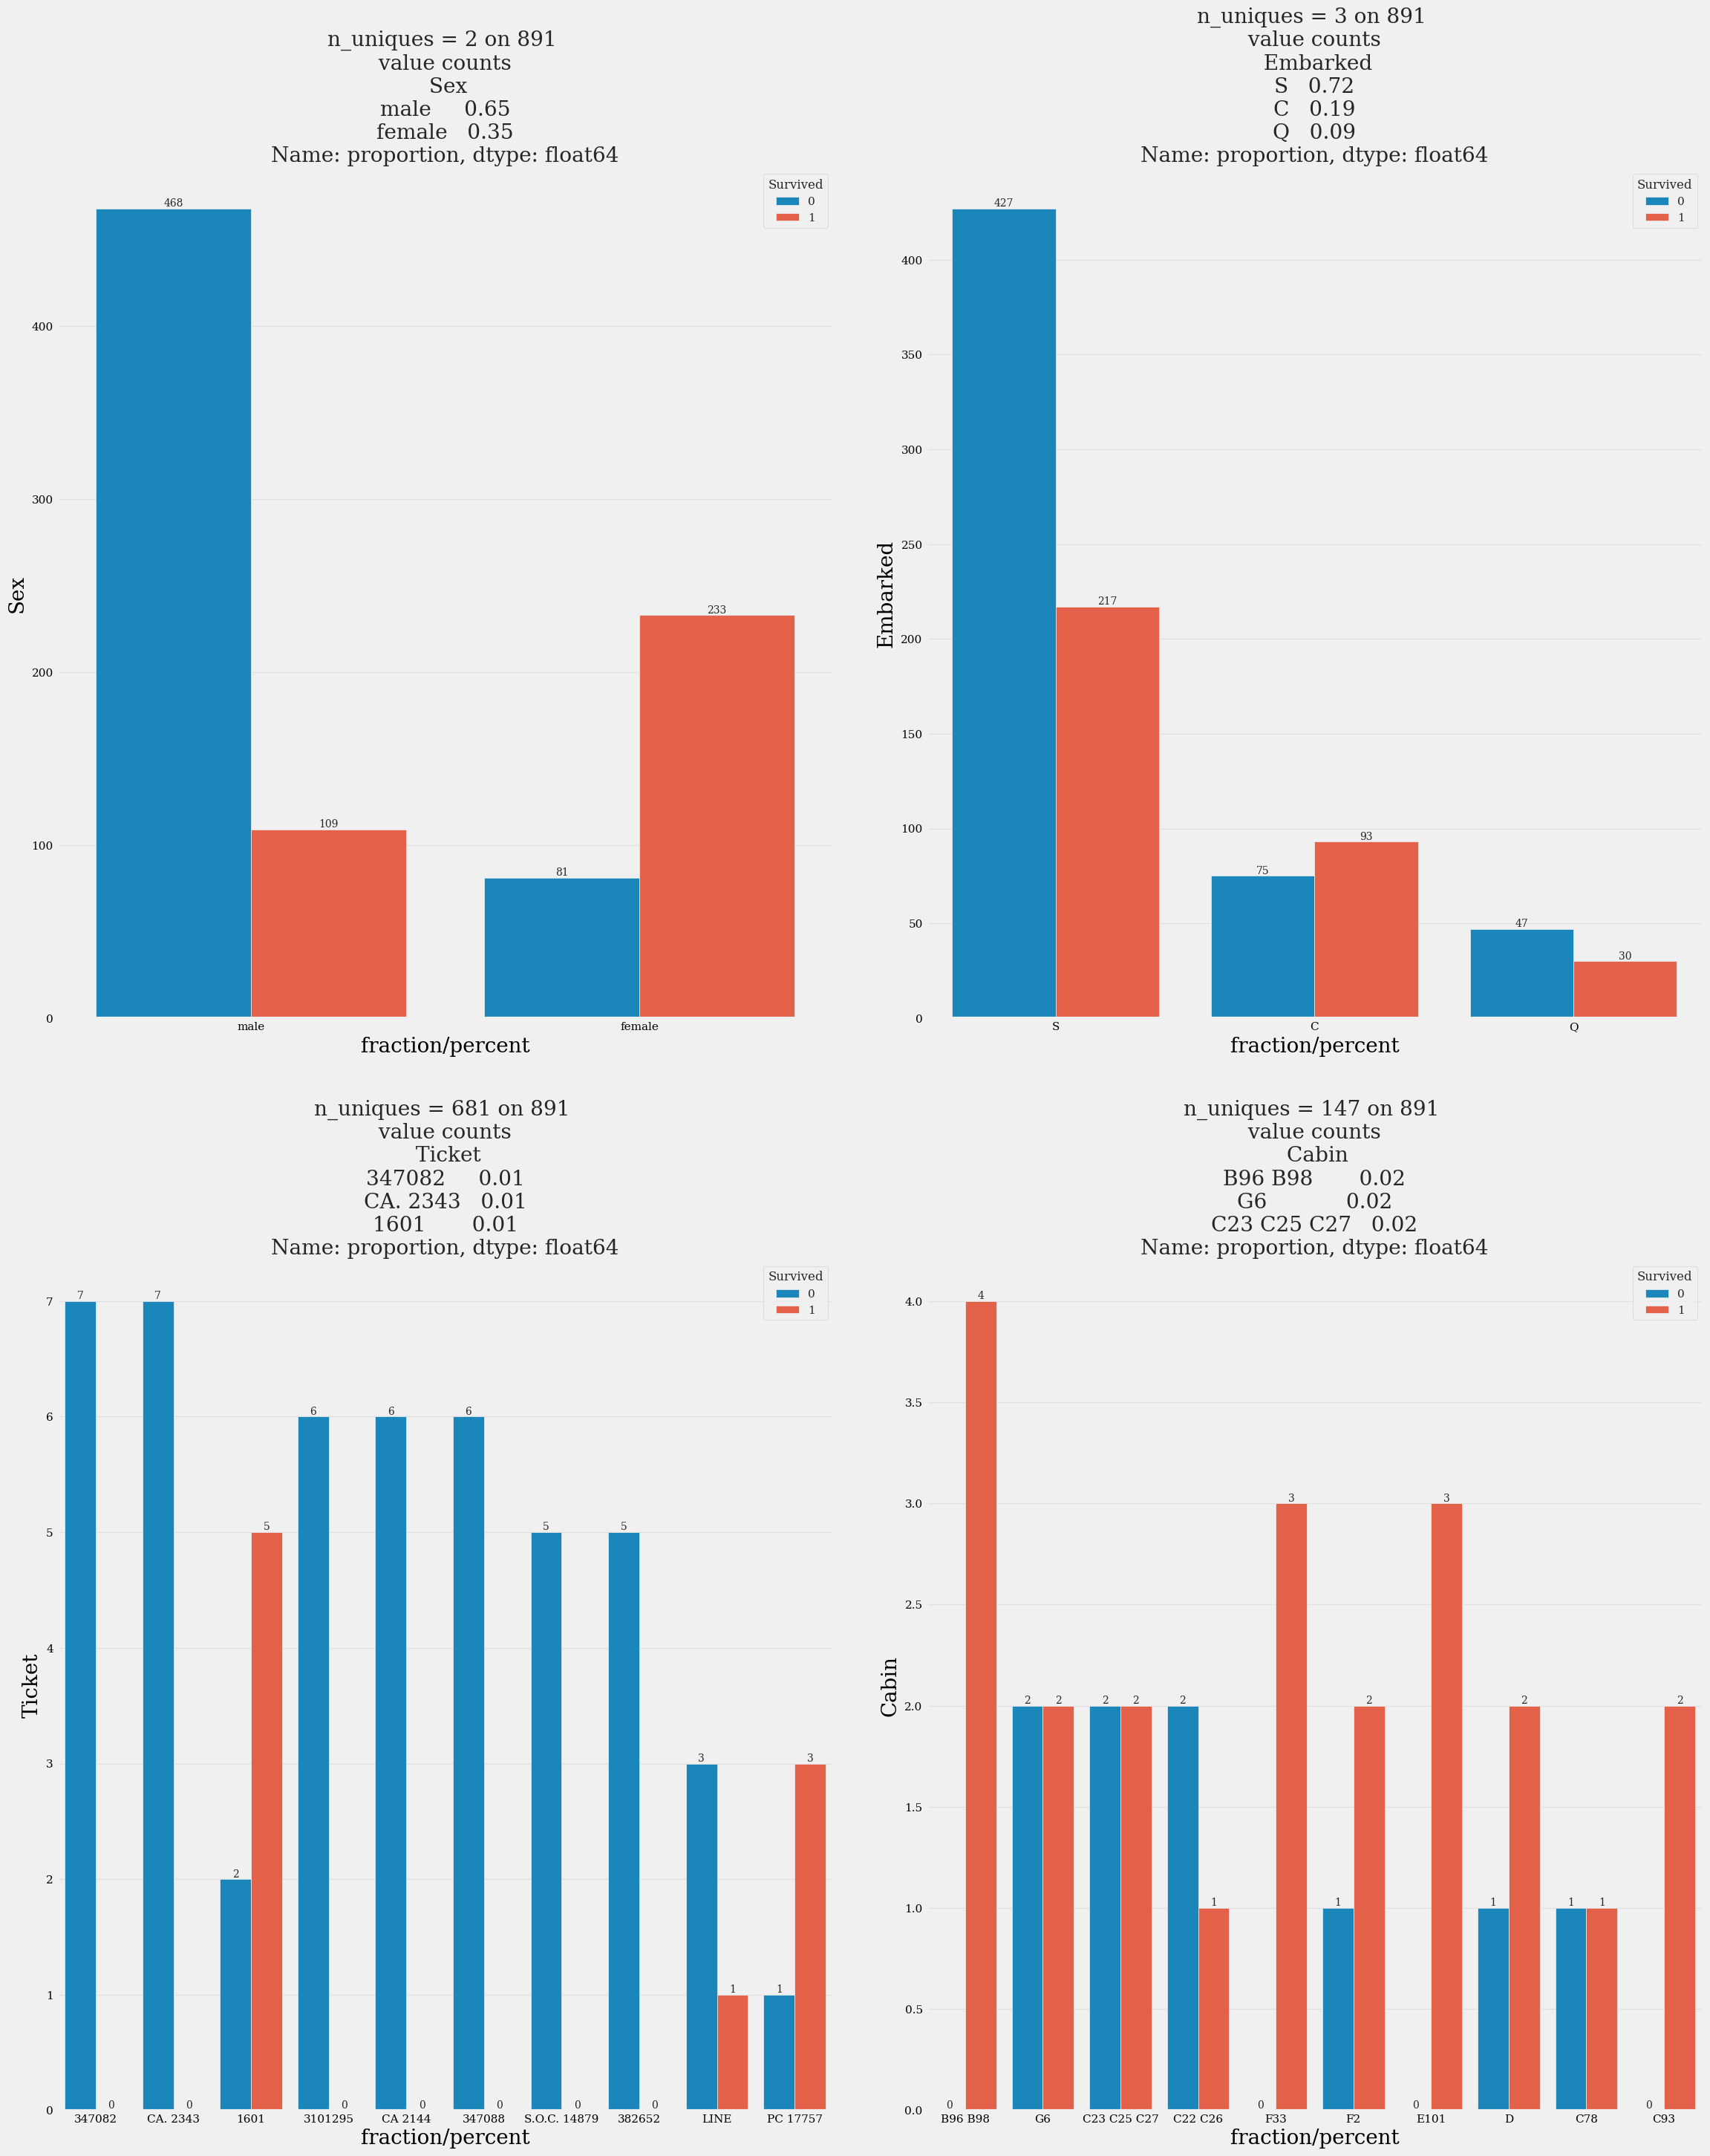

In [17]:
UVA_category_on_target(df_train,['Sex','Embarked','Ticket','Cabin'])

In [18]:
print(df_train.groupby(['Embarked']).Survived.mean(),'\n')
pd.crosstab(df_train['Embarked'],df_train['Pclass'])

Embarked
C   0.55
Q   0.39
S   0.34
Name: Survived, dtype: float64 



Pclass      1    2    3
Embarked               
C          85   17   66
Q           2    3   72
S         127  164  353

> Observations

**Ticket and Cabin**</br>
We can easly confirm that many tickets are shared by some passengers. We can suppose that passengers with same ticket are in same cabin or same place.
During cleaning I will surely remove `Cabin` column because we have a lot missing values and unfortunately no way to assign the cabin basing on ticket. 
We also have more visibility on passengers survival rate sharing the same cabin. Regarding cabin, that looks clear now that another factor affects the survival rate because results are quite balanced. 

**Embarked**</br>
Most of passengers that embarked from Southampton and Queenstown took 3rd class cabin and only 34%|39% survived. *The cabin class impacts the survival rate.* 


# Univariate analysis based on train and test sets
This analysis may help for cleaning process.

In [19]:
def UVA_numeric_discrete(data, var_group):
    '''
    Univariate analysis numeric for discrete variables here that concerns only new previous added variables
    Takes a group of variables ( INTEGER or FLOAT) and plot/print all the descriptives and properties along with KDE
    '''
    size = len(var_group)
    fig, ax = plt.subplots(size,2, figsize = [20,5*size])
    
    #looping for each variable
    for j,i in enumerate(var_group):
        
        #computing descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max()- data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()
        
        #calculating points of standard deviation
        points = mean - st_dev, mean + st_dev
        
        #Plotting the variable with every information
        #sb.histplot(ax = ax[j,0],data=data,x = data[i], hue='set', bins=50, kde=True)
        sb.kdeplot(ax = ax[j,0], data = data,x = data[i],shade = True,hue='set')
        sb.lineplot(ax = ax[j,0],x = points,y=[0,0], color = 'black',label = 'std_dev')
        sb.scatterplot(ax=ax[j,0],x = [mini, maxi],y = [0,0],color='orange',label = 'min/max')
        sb.scatterplot(ax=ax[j,0],x = [mean],y = [0], color = 'red',label = "mean")
        sb.scatterplot(ax=ax[j,0],x = [median],y = [0], color = 'blue',label = "median")
        ax[j,0].set_xlabel('{}'.format(i),fontsize = 20)
        ax[j,0].set_ylabel('density')
        ax[j,0].set_title('std_dev = {}; kurtosis = {}; \nskew ={}; range = {} \nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                                round(kurt,2),
                                                                                                                round(skew,2),
                                                                                                                (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                                round(mean,2),
                                                                                                                round(median,2)))
                  
    
        #base_cl = sb.color_palette()[0]
        pickp_data = data[i].value_counts(ascending=False)
        cplt = sb.countplot(data,x = i,hue='set',order = pickp_data.index,ax= ax[j,1])
        cplt.bar_label(cplt.containers[0], fontsize=10);
        cplt.bar_label(cplt.containers[1], fontsize=10);
        ax[j,1].set_xlabel('{}'.format(i),fontsize = 20)
        ax[j,1].set_ylabel('Count')
        #plt.legend(loc = 'upper left') # re-arrange legend to reduce overlapping"""
        plt.tight_layout(pad =2)

def UVA_numeric_continuous(data, var_group):
    '''
    Univariate analysis numeric for continuous variables
    Takes a group of variables ( INTEGER or FLOAT) and plot/print all the descriptives and properties along with KDE and histograms
    '''
    size = len(var_group)
    fig, ax = plt.subplots(size,2, figsize = [25,5*size])
    
    #looping for each variable
    for j,i in enumerate(var_group):

        sb.histplot(ax = ax[j,0],data=data,x = data[i], hue='set',palette =['b','r'], bins=50, kde=True)
        ax[j,0].set_xlabel('{}'.format(i),fontsize = 20)
        ax[j,0].set_ylabel('density')
                  
    
        sb.boxplot(data,y = i,hue = 'set',orient='v',hue_order=[1,0],palette =['b','r'],ax= ax[j,1])
        ax[j,1].set_xlabel('{}'.format(i),fontsize = 20)
        plt.legend(ncol = 2) # re-arrange legend to reduce overlapping"""
        plt.tight_layout(pad =2)

def UVA_category(data, var_group, max_categories=10):

    '''
    Univariate_Analysis_categorical
    takes a group of variables (category) and plot/print the value_counts and barplot for max_categories.
    '''
    # setting figure_size
    size = len(var_group)
    plt.figure(figsize = (6*size,30))

    # for every variable
    for j,i in enumerate(var_group):
        """norm_count = data.loc[(data['Survived'] == 1),i].value_counts(normalize = True)[:max_categories]"""
        n_uni = data[i].nunique()

        #Plotting the variable with every information
        plt.subplot(2,2,j+1)
        pickp_data = data[i].value_counts(normalize = True,ascending=False)[:max_categories]
        cplt = sb.countplot(data,x = i,hue='set',order = pickp_data.index)
        cplt.bar_label(cplt.containers[0], fontsize=10);
        cplt.bar_label(cplt.containers[1], fontsize=10);
        plt.xlabel('fraction/percent', fontsize = 20)
        plt.ylabel(f'{i}', fontsize = 20)
        plt.title(f'n_uniques = {n_uni} on {data.shape[0]} \n value counts \n {pickp_data[:3]}')
        plt.tight_layout(pad=3)


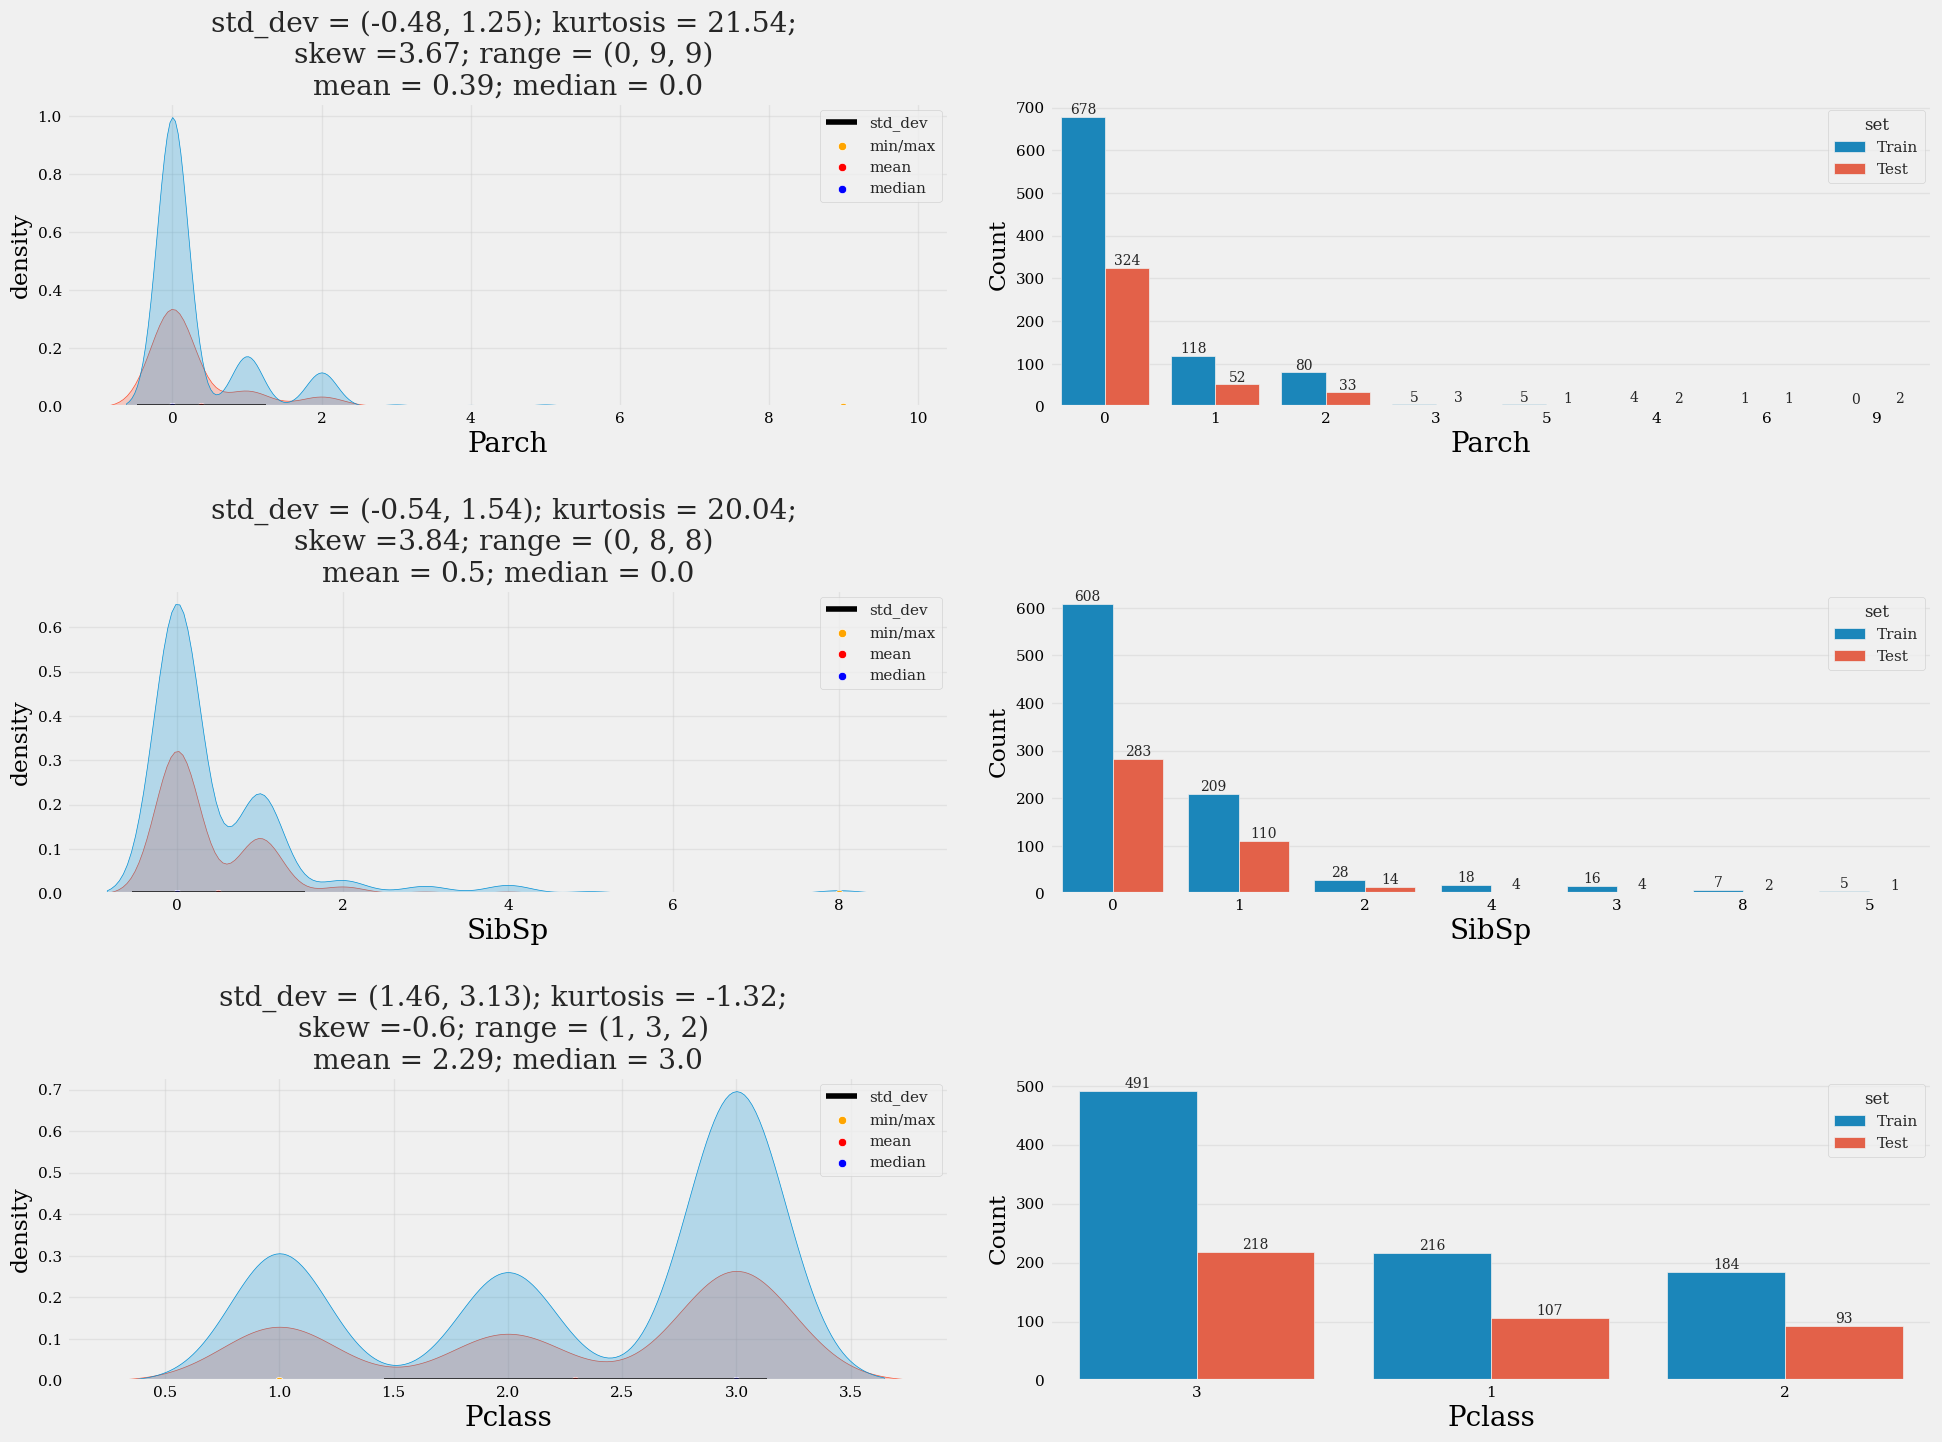

In [20]:
UVA_numeric_discrete(df, ['Parch','SibSp','Pclass'])

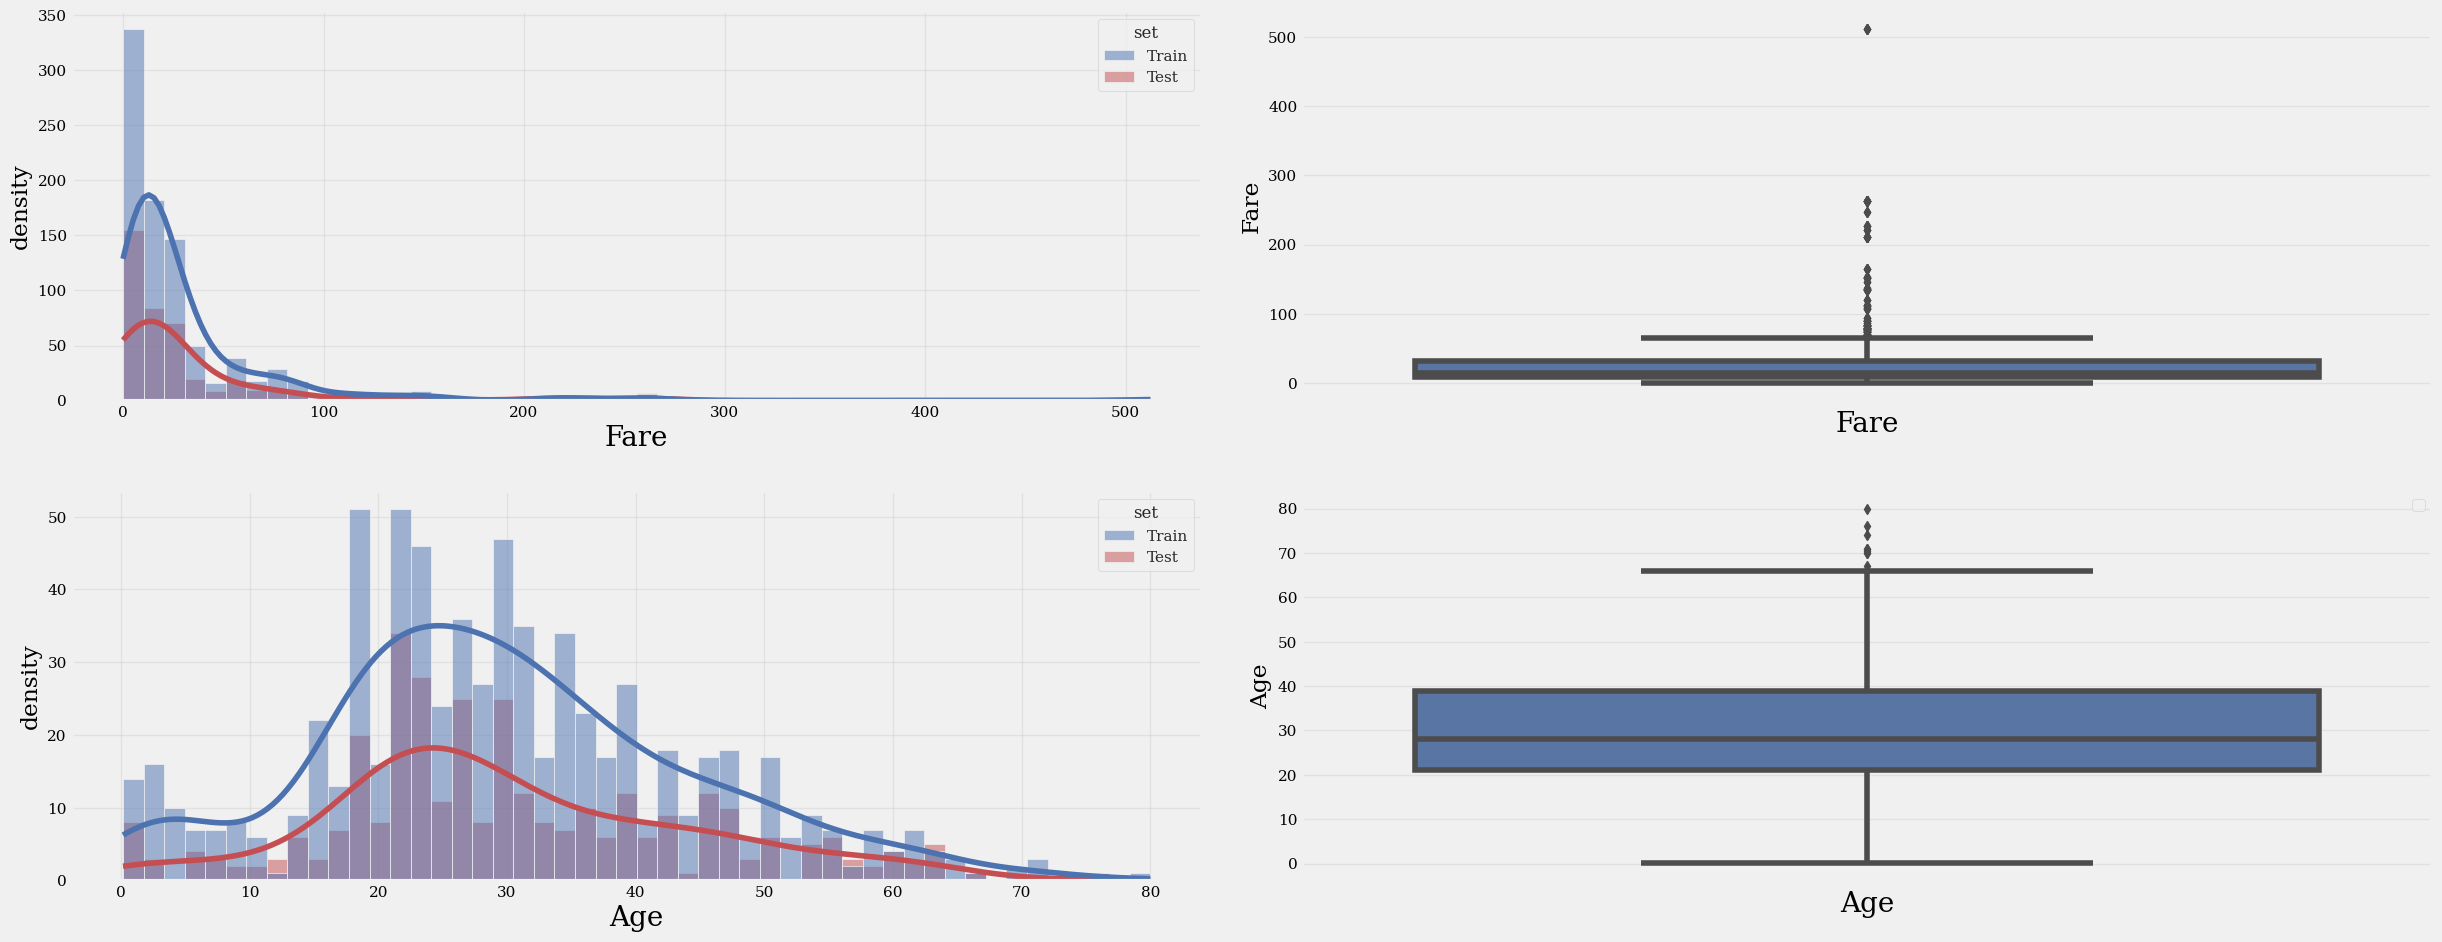

In [21]:
UVA_numeric_continuous(df,['Fare','Age'])

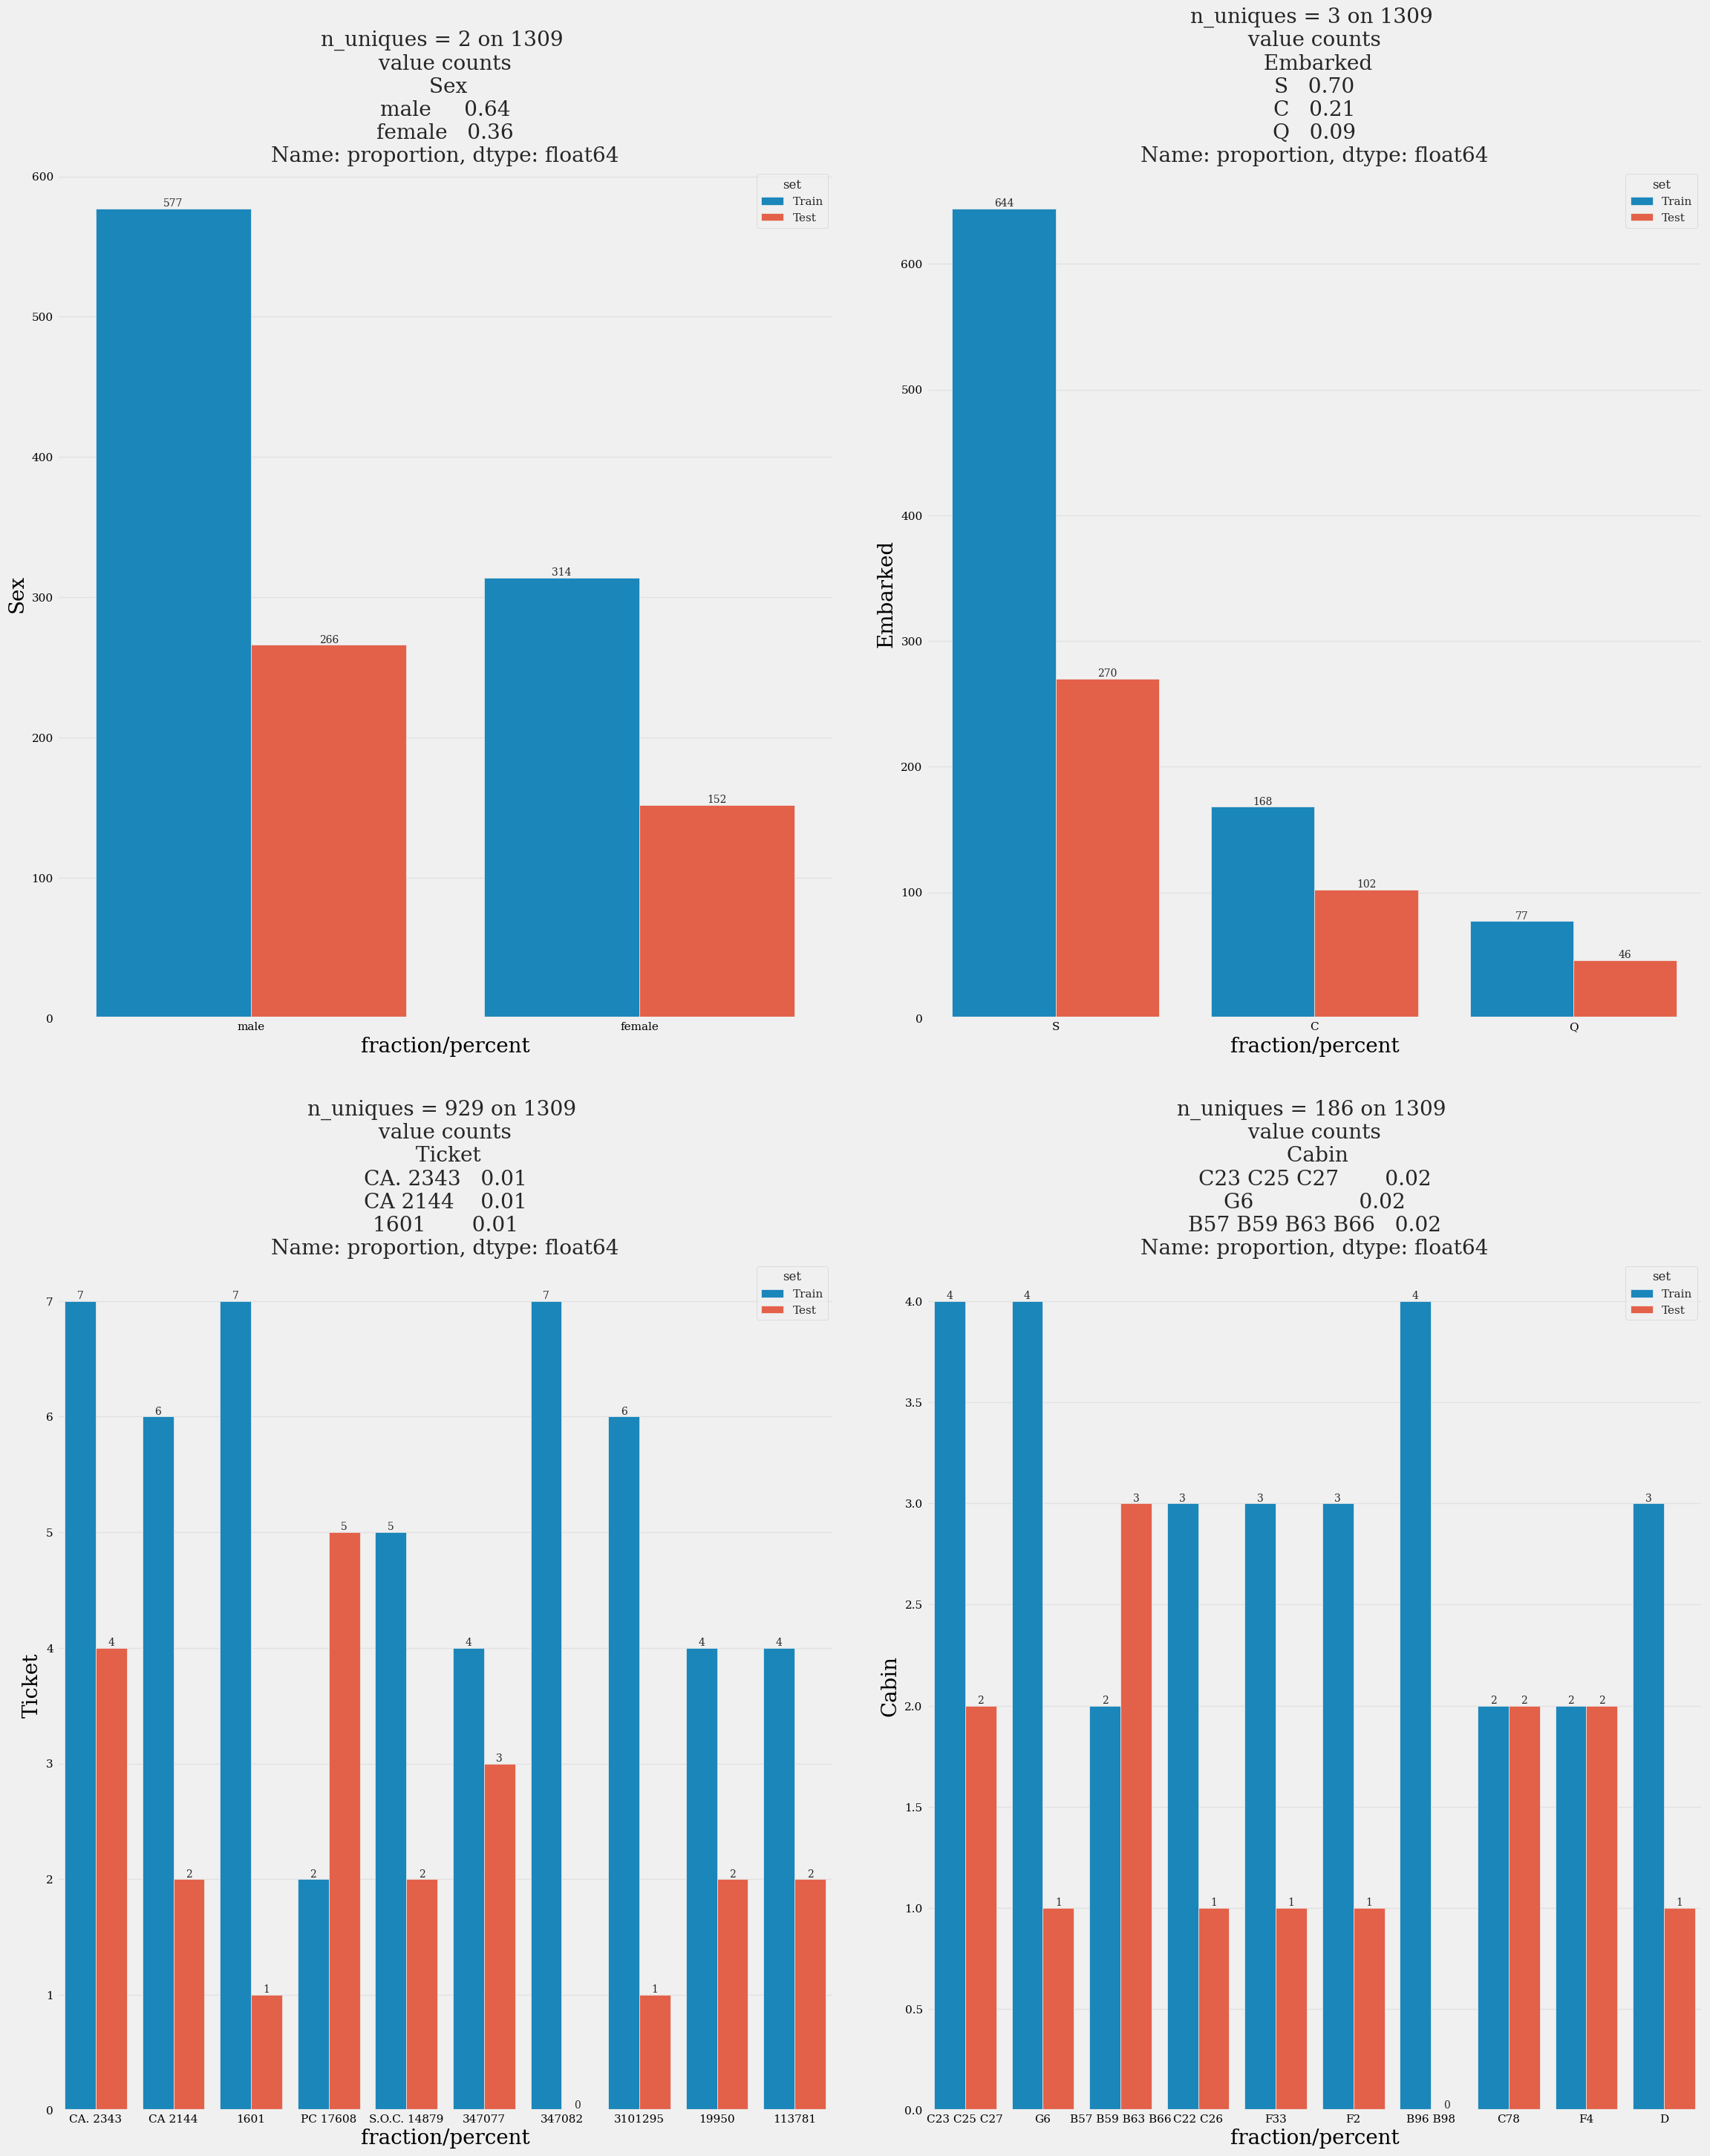

In [22]:
UVA_category(df,['Sex','Embarked','Ticket','Cabin'])

> Observations

* The train and test sets have similar distributions regarding numerical variables.
* There is more male than female passengers in datasets.
* Most of passengers took the third class followed by first class and second class
* A lot of passengers have 0 fare tickets. That looks suspicious. If this does not correspond to the maximum number of children and elderly people with the boat's employees, there may be illegal immigrants on board. 
* Most of passengers are travelling solo. Could have the family size been a important criteria for suvival aboard Titanic?
* Most of passengers are between 18 and 30 years old.

> #### Summary of Observations:

**Ticket and Cabin**</br>
We can easly confirm that many tickets are shared by some passengers. We can suppose that passengers with same ticket are in same cabin or same place.
During cleaning I will surely remove `Cabin` column because we have a lot missing values and unfortunately no way to assign the cabin basing on ticket. 
We also have more visibility on passengers survival rate sharing the same cabin. Regarding cabin, that looks clear now that another factor affects the survival rate because results are quite balanced. 

**Embarked**</br>
Most of passengers that embarked from Southampton and Queenstown took 3rd class cabin and only 34%|39% survived. *The cabin class impacts the survival rate.* 

**SibSp & Parch**
People with one ore two siblings/spouses aboard Titanic have good survival rate. Passengers with 1-3 small family members have a surprisingly better survival rate. The size of the family surely plays a determining role in the survival on board the Titanic.

**Pclass**
1st and 2nd class passengers got better survival rate compared to a disastrous survival rate in a 3rd class cabin.

Let's clean data before continue with analysis.

# Data cleaning

In [23]:
data_train = df_train.copy()
data_test = df_test.copy()
data_full = df.copy() 

* We have about 21% of null values in age. 
* The Cabin column has more than 70% null values. 
* One null value is present in Fare from test set.
* A lot of passengers have 0 fare tickets. That looks suspicious.
* 2 Embarked values are missing.

> ### Drop non informative columns

In [24]:
data_full.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'set'],
      dtype='object')

In [25]:
data_full.drop(columns = ['Cabin','Ticket'], axis=1, inplace = True)
data_full.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'set'],
      dtype='object')

> ### Fare values correction

In [26]:
display(data_full.loc[data_full.Fare.isna()])
display(data_full.loc[data_full.Fare ==0 ])
print('There are {} zeros fare values.'.format(data_full.Fare.value_counts()[0]))


PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male 60.50      0   

      Parch  Fare Embarked   set  
1043      0   NaN        S  Test

PassengerId  Survived  Pclass                                   Name  \
179           180      0.00       3                    Leonard, Mr. Lionel   
263           264      0.00       1                  Harrison, Mr. William   
271           272      1.00       3           Tornquist, Mr. William Henry   
277           278      0.00       2            Parkes, Mr. Francis "Frank"   
302           303      0.00       3        Johnson, Mr. William Cahoone Jr   
413           414      0.00       2         Cunningham, Mr. Alfred Fleming   
466           467      0.00       2                  Campbell, Mr. William   
481           482      0.00       2       Frost, Mr. Anthony Wood "Archie"   
597           598      0.00       3                    Johnson, Mr. Alfred   
633           634      0.00       1          Parr, Mr. William Henry Marsh   
674           675      0.00       2             Watson, Mr. Ennis Hastings   
732           733      0.00       2                   Knight, Mr. Robert J   
806           807      0.00       1                 Andrews, Mr. Thomas Jr   
815           816      0.00       1                       Fry, Mr. Richard   
822           823      0.00       1        Reuchlin, Jonkheer. John George   
1157         1158       NaN       1  Chisholm, Mr. Roderick Robert Crispin   
1263         1264       NaN       1                Ismay, Mr. Joseph Bruce   

       Sex   Age  SibSp  Parch  Fare Embarked    set  
179   male 36.00      0      0  0.00        S  Train  
263   male 40.00      0      0  0.00        S  Train  
271   male 25.00      0      0  0.00        S  Train  
277   male   NaN      0      0  0.00        S  Train  
302   male 19.00      0      0  0.00        S  Train  
413   male   NaN      0      0  0.00        S  Train  
466   male   NaN      0      0  0.00        S  Train  
481   male   NaN      0      0  0.00        S  Train  
597   male 49.00      0      0  0.00        S  Train  
633   male   NaN      0      0  0.00        S  Train  
674   male   NaN      0      0  0.00        S  Train  
732   male   NaN      0      0  0.00        S  Train  
806   male 39.00      0      0  0.00        S  Train  
815   male   NaN      0      0  0.00        S  Train  
822   male 38.00      0      0  0.00        S  Train  
1157  male   NaN      0      0  0.00        S   Test  
1263  male 49.00      0      0  0.00        S   Test

There are 17 zeros fare values.


Let's replace these values by median fare values for corresponding Pclass from Southampton. We saw a lot of outliers on previous boxplots ,so I will use the median.

In [27]:
val_fare = data_full.loc[(data_full['Embarked'] == 'S') ][['Fare','Pclass']]
val_fare.groupby(by = ['Pclass'])['Fare'].median()

Pclass
1   52.00
2   15.38
3    8.05
Name: Fare, dtype: float64

In [28]:
data_full[(data_full['Fare'].isna())]['Fare'] = 8.05
# list of conditions
conditions = [
    (data_full['Fare']==0 |data_full['Fare'].isna() ) & (data_full['Pclass']==1),
    (data_full['Fare']==0 |data_full['Fare'].isna()) & (data_full['Pclass']==2),
    (data_full['Fare']==0|data_full['Fare'].isna()) & (data_full['Pclass']==3),
    (data_full['Fare'].isna()),
    (data_full['Fare'] != 0)
     ]

# Persona class for each condition
values = [52, 15.38, 8.05,8.05,data_full.Fare]

data_full['Fare_final'] = np.select(conditions, values)
data_full

PassengerId  Survived  Pclass  \
0               1      0.00       3   
1               2      1.00       1   
2               3      1.00       3   
3               4      1.00       1   
4               5      0.00       3   
...           ...       ...     ...   
1304         1305       NaN       3   
1305         1306       NaN       1   
1306         1307       NaN       3   
1307         1308       NaN       3   
1308         1309       NaN       3   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male 22.00      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.00      1   
2                                Heikkinen, Miss. Laina  female 26.00      0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.00      1   
4                              Allen, Mr. William Henry    male 35.00      0   
...                                                 ...     ...   ...    ...   
1304                                 Spector, Mr. Woolf    male   NaN      0   
1305                       Oliva y Ocana, Dona. Fermina  female 39.00      0   
1306                       Saether, Mr. Simon Sivertsen    male 38.50      0   
1307                                Ware, Mr. Frederick    male   NaN      0   
1308                           Peter, Master. Michael J    male   NaN      1   

      Parch   Fare Embarked    set  Fare_final  
0         0   7.25        S  Train        7.25  
1         0  71.28        C  Train       71.28  
2         0   7.92        S  Train        7.92  
3         0  53.10        S  Train       53.10  
4         0   8.05        S  Train        8.05  
...     ...    ...      ...    ...         ...  
1304      0   8.05        S   Test        8.05  
1305      0 108.90        C   Test      108.90  
1306      0   7.25        S   Test        7.25  
1307      0   8.05        S   Test        8.05  
1308      1  22.36        C   Test       22.36  

[1309 rows x 12 columns]

In [29]:
display(data_full.loc[data_full.Fare.isna()])
display(data_full.loc[data_full.Fare ==0 ])

PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male 60.50      0   

      Parch  Fare Embarked   set  Fare_final  
1043      0   NaN        S  Test        8.05

PassengerId  Survived  Pclass                                   Name  \
179           180      0.00       3                    Leonard, Mr. Lionel   
263           264      0.00       1                  Harrison, Mr. William   
271           272      1.00       3           Tornquist, Mr. William Henry   
277           278      0.00       2            Parkes, Mr. Francis "Frank"   
302           303      0.00       3        Johnson, Mr. William Cahoone Jr   
413           414      0.00       2         Cunningham, Mr. Alfred Fleming   
466           467      0.00       2                  Campbell, Mr. William   
481           482      0.00       2       Frost, Mr. Anthony Wood "Archie"   
597           598      0.00       3                    Johnson, Mr. Alfred   
633           634      0.00       1          Parr, Mr. William Henry Marsh   
674           675      0.00       2             Watson, Mr. Ennis Hastings   
732           733      0.00       2                   Knight, Mr. Robert J   
806           807      0.00       1                 Andrews, Mr. Thomas Jr   
815           816      0.00       1                       Fry, Mr. Richard   
822           823      0.00       1        Reuchlin, Jonkheer. John George   
1157         1158       NaN       1  Chisholm, Mr. Roderick Robert Crispin   
1263         1264       NaN       1                Ismay, Mr. Joseph Bruce   

       Sex   Age  SibSp  Parch  Fare Embarked    set  Fare_final  
179   male 36.00      0      0  0.00        S  Train        8.05  
263   male 40.00      0      0  0.00        S  Train       52.00  
271   male 25.00      0      0  0.00        S  Train        8.05  
277   male   NaN      0      0  0.00        S  Train       15.38  
302   male 19.00      0      0  0.00        S  Train        8.05  
413   male   NaN      0      0  0.00        S  Train       15.38  
466   male   NaN      0      0  0.00        S  Train       15.38  
481   male   NaN      0      0  0.00        S  Train       15.38  
597   male 49.00      0      0  0.00        S  Train        8.05  
633   male   NaN      0      0  0.00        S  Train       52.00  
674   male   NaN      0      0  0.00        S  Train       15.38  
732   male   NaN      0      0  0.00        S  Train       15.38  
806   male 39.00      0      0  0.00        S  Train       52.00  
815   male   NaN      0      0  0.00        S  Train       52.00  
822   male 38.00      0      0  0.00        S  Train       52.00  
1157  male   NaN      0      0  0.00        S   Test       52.00  
1263  male 49.00      0      0  0.00        S   Test       52.00

> ### Embarked Null values

In [30]:
data_full.loc[(data_full.Embarked.isna())]

PassengerId  Survived  Pclass                                       Name  \
61            62      1.00       1                        Icard, Miss. Amelie   
829          830      1.00       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Fare Embarked    set  Fare_final  
61   female 38.00      0      0 80.00      NaN  Train       80.00  
829  female 62.00      0      0 80.00      NaN  Train       80.00

Unfortunately, there is no way to guess the null values. These passengers could come from any place as they took the first class.

In [31]:
data_full.drop(data_full[data_full['Embarked'].isnull()].index, inplace  =True)
data_full.loc[(data_full.Embarked.isna())]

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Fare, Embarked, set, Fare_final]
Index: []

> ### Age missing values

In [32]:
data_full.loc[data_full.Age.isna()]

PassengerId  Survived  Pclass                             Name     Sex  \
5               6      0.00       3                 Moran, Mr. James    male   
17             18      1.00       2     Williams, Mr. Charles Eugene    male   
19             20      1.00       3          Masselmani, Mrs. Fatima  female   
26             27      0.00       3          Emir, Mr. Farred Chehab    male   
28             29      1.00       3    O'Dwyer, Miss. Ellen "Nellie"  female   
...           ...       ...     ...                              ...     ...   
1299         1300       NaN       3  Riordan, Miss. Johanna Hannah""  female   
1301         1302       NaN       3           Naughton, Miss. Hannah  female   
1304         1305       NaN       3               Spector, Mr. Woolf    male   
1307         1308       NaN       3              Ware, Mr. Frederick    male   
1308         1309       NaN       3         Peter, Master. Michael J    male   

      Age  SibSp  Parch  Fare Embarked    set  Fare_final  
5     NaN      0      0  8.46        Q  Train        8.46  
17    NaN      0      0 13.00        S  Train       13.00  
19    NaN      0      0  7.22        C  Train        7.22  
26    NaN      0      0  7.22        C  Train        7.22  
28    NaN      0      0  7.88        Q  Train        7.88  
...   ...    ...    ...   ...      ...    ...         ...  
1299  NaN      0      0  7.72        Q   Test        7.72  
1301  NaN      0      0  7.75        Q   Test        7.75  
1304  NaN      0      0  8.05        S   Test        8.05  
1307  NaN      0      0  8.05        S   Test        8.05  
1308  NaN      1      1 22.36        C   Test       22.36  

[263 rows x 12 columns]

Let's try to find some patterns to address effiently ages basing on name, SibSp,Parch. For that, I will create a new categorical variable depending of age range, and another about the nomination in name like (Mr, Miss,Master).

In [33]:
import re
re.findall(r'''([a-zA-Z ]+)''',re.findall(r'''(, [a-zA-Z ]+(?#. $))''',data_full.Name[0])[0])[0]

' Mr'

In [34]:
data_full['formal_titles'] = data_full['Name'].apply(lambda x:re.findall(r'''[a-zA-Z ]+''',re.findall(r'''(, [a-zA-Z ]+(?#. $))''',x)[0])[0])
display(data_full['formal_titles'].value_counts())
print('Null values in format_titles',data_full['formal_titles'].isna().sum())

formal_titles
Mr              757
Miss            259
Mrs             196
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

Null values in format_titles 0


In [35]:
data_full['formal_titles'].value_counts()[4:].index

Index([' Rev', ' Dr', ' Col', ' Mlle', ' Major', ' Ms', ' Lady', ' Sir',
       ' Mme', ' Don', ' Capt', ' the Countess', ' Jonkheer', ' Dona'],
      dtype='object', name='formal_titles')

In [36]:
data_full.loc[(data_full.formal_titles.isin(data_full['formal_titles'].value_counts()[4:].index))]

PassengerId  Survived  Pclass  \
30             31      0.00       1   
149           150      0.00       2   
150           151      0.00       2   
245           246      0.00       1   
249           250      0.00       2   
317           318      0.00       2   
369           370      1.00       1   
398           399      0.00       2   
443           444      1.00       2   
449           450      1.00       1   
536           537      0.00       1   
556           557      1.00       1   
599           600      1.00       1   
626           627      0.00       2   
632           633      1.00       1   
641           642      1.00       1   
647           648      1.00       1   
660           661      1.00       1   
694           695      0.00       1   
710           711      1.00       1   
745           746      0.00       1   
759           760      1.00       1   
766           767      0.00       1   
796           797      1.00       1   
822           823      0.00       1   
848           849      0.00       2   
886           887      0.00       2   
979           980       NaN       3   
1022         1023       NaN       1   
1040         1041       NaN       2   
1055         1056       NaN       2   
1093         1094       NaN       1   
1184         1185       NaN       1   
1305         1306       NaN       1   

                                                   Name     Sex   Age  SibSp  \
30                             Uruchurtu, Don. Manuel E    male 40.00      0   
149                   Byles, Rev. Thomas Roussel Davids    male 42.00      0   
150                          Bateman, Rev. Robert James    male 51.00      0   
245                         Minahan, Dr. William Edward    male 44.00      2   
249                       Carter, Rev. Ernest Courtenay    male 54.00      1   
317                                Moraweck, Dr. Ernest    male 54.00      0   
369                       Aubart, Mme. Leontine Pauline  female 24.00      0   
398                                    Pain, Dr. Alfred    male 23.00      0   
443                           Reynaldo, Ms. Encarnacion  female 28.00      0   
449                      Peuchen, Major. Arthur Godfrey    male 52.00      0   
536                   Butt, Major. Archibald Willingham    male 45.00      0   
556   Duff Gordon, Lady. (Lucille Christiana Sutherl...  female 48.00      1   
599        Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")    male 49.00      1   
626                      Kirkland, Rev. Charles Leonard    male 57.00      0   
632                           Stahelin-Maeglin, Dr. Max    male 32.00      0   
641                                Sagesser, Mlle. Emma  female 24.00      0   
647                 Simonius-Blumer, Col. Oberst Alfons    male 56.00      0   
660                       Frauenthal, Dr. Henry William    male 50.00      2   
694                                     Weir, Col. John    male 60.00      0   
710    Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")  female 24.00      0   
745                        Crosby, Capt. Edward Gifford    male 70.00      1   
759   Rothes, the Countess. of (Lucy Noel Martha Dye...  female 33.00      0   
766                           Brewe, Dr. Arthur Jackson    male   NaN      0   
796                         Leader, Dr. Alice (Farnham)  female 49.00      0   
822                     Reuchlin, Jonkheer. John George    male 38.00      0   
848                                   Harper, Rev. John    male 28.00      0   
886                               Montvila, Rev. Juozas    male 27.00      0   
979                             O'Donoghue, Ms. Bridget  female   NaN      0   
1022                          Gracie, Col. Archibald IV    male 53.00      0   
1040                             Lahtinen, Rev. William    male 30.00      1   
1055                      Peruschitz, Rev. Joseph Maria    male 41.00      0   
1093                             Astor, Col. John Jacob    male 47.00      1   


In [37]:
age_means_per_title = data_full.groupby(by=['Sex','Embarked','formal_titles'])['Age'].mean().reset_index()
age_means_per_title

Sex Embarked  formal_titles   Age
0   female        C           Dona 39.00
1   female        C           Lady 48.00
2   female        C           Miss 24.54
3   female        C           Mlle 24.00
4   female        C            Mme 24.00
5   female        C            Mrs 37.70
6   female        Q           Miss 23.95
7   female        Q            Mrs 36.00
8   female        Q             Ms   NaN
9   female        S             Dr 49.00
10  female        S           Miss 20.44
11  female        S            Mrs 36.53
12  female        S             Ms 28.00
13  female        S   the Countess 33.00
14    male        C            Col 52.00
15    male        C            Don 40.00
16    male        C             Dr 32.00
17    male        C         Master  6.49
18    male        C             Mr 34.38
19    male        C            Sir 49.00
20    male        Q             Dr 44.00
21    male        Q         Master  6.20
22    male        Q             Mr 36.24
23    male        Q            Rev 57.00
24    male        S           Capt 70.00
25    male        S            Col 60.00
26    male        S             Dr 45.00
27    male        S       Jonkheer 38.00
28    male        S          Major 48.50
29    male        S         Master  5.22
30    male        S             Mr 31.62
31    male        S            Rev 39.00

That's not bad, I will fill missing age values with mean values depending of titles,origin and sex.

In [38]:
data_full[~(data_full.Age.isna())].shape

(1044, 13)

In [39]:
data_full.groupby(by=['Sex'])['Age'].mean().reset_index()

Sex   Age
0  female 28.58
1    male 30.59

In [40]:
# list of conditions
conditions = [
   (data_full.Embarked == 'C' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Col') & (data_full.Age.isna()),
    (data_full.Embarked == 'C' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Don') & (data_full.Age.isna()),
    (data_full.Embarked == 'C' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Dr') & (data_full.Age.isna()),
    (data_full.Embarked == 'C' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Master')& (data_full.Age.isna()),
    (data_full.Embarked == 'C' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Mr')& (data_full.Age.isna()),
    (data_full.Embarked == 'C' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Sir')& (data_full.Age.isna()),
    
    (data_full.Embarked == 'Q' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Dr')& (data_full.Age.isna()),
    (data_full.Embarked == 'Q' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Master')& (data_full.Age.isna()),
    (data_full.Embarked == 'Q' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Mr')& (data_full.Age.isna()),
    (data_full.Embarked == 'Q' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Rev')& (data_full.Age.isna()),
    
    (data_full.Embarked == 'S' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Capt')& (data_full.Age.isna()),
    (data_full.Embarked == 'S' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Col')& (data_full.Age.isna()),
    (data_full.Embarked == 'S' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Dr')& (data_full.Age.isna()),
    (data_full.Embarked == 'S' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Jonkheer')& (data_full.Age.isna()),
    (data_full.Embarked == 'S' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Major')& (data_full.Age.isna()),
    (data_full.Embarked == 'S' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Master')& (data_full.Age.isna()),
    (data_full.Embarked == 'S' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Mr')& (data_full.Age.isna()),
    (data_full.Embarked == 'S' ) & (data_full.Sex =='male') & (data_full.formal_titles ==' Rev')& (data_full.Age.isna()),
    
    (data_full.Embarked == 'C' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Dona')& (data_full.Age.isna()),
(data_full.Embarked == 'C' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Lady')& (data_full.Age.isna()),
(data_full.Embarked == 'C' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Miss')& (data_full.Age.isna()),
(data_full.Embarked == 'C' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Mille')& (data_full.Age.isna()),
(data_full.Embarked == 'C' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Mme')& (data_full.Age.isna()),
(data_full.Embarked == 'C' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Mrs')& (data_full.Age.isna()),

(data_full.Embarked == 'Q' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Miss')& (data_full.Age.isna()),
(data_full.Embarked == 'Q' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Mrs')& (data_full.Age.isna()),

(data_full.Embarked == 'S' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Dr')& (data_full.Age.isna()),
(data_full.Embarked == 'S' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Miss')& (data_full.Age.isna()),
(data_full.Embarked == 'S' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Mrs')& (data_full.Age.isna()),
(data_full.Embarked == 'S' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' Ms')& (data_full.Age.isna()),
(data_full.Embarked == 'S' ) & (data_full.Sex =='female') & (data_full.formal_titles ==' the Countess')& (data_full.Age.isna()),
(data_full.Sex =='female') & ~(data_full.formal_titles.isin(data_full['formal_titles'].value_counts().index))& (data_full.Age.isna()),
(data_full.Sex =='male') & ~(data_full.formal_titles.isin(data_full['formal_titles'].value_counts().index))& (data_full.Age.isna()),
(~data_full.Age.isna())
    
    ]

# Persona class for each condition
values = [52.00,40.00,32.00,6.49,34.38,49.00,44.00,6.20,36.24,57.00,70.00,60.00,45.00,38.00,48.50,5.22,31.62,39.00,39.00,48.00,24.54,24.00,24.00,37.70,23.95,36.00,49.00,20.44,36.53,28.00,33.00,28.58,30.59,data_full.Age]


data_full['Age_final'] = np.select(conditions, values)
data_full.head()

PassengerId  Survived  Pclass  \
0            1      0.00       3   
1            2      1.00       1   
2            3      1.00       3   
3            4      1.00       1   
4            5      0.00       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male 22.00      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.00      1   
2                             Heikkinen, Miss. Laina  female 26.00      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.00      1   
4                           Allen, Mr. William Henry    male 35.00      0   

   Parch  Fare Embarked    set  Fare_final formal_titles  Age_final  
0      0  7.25        S  Train        7.25            Mr      22.00  
1      0 71.28        C  Train       71.28           Mrs      38.00  
2      0  7.92        S  Train        7.92          Miss      26.00  
3      0 53.10        S  Train       53.10           Mrs      35.00  
4      0  8.05        S  Train        8.05            Mr      35.00

In [41]:
data_full.loc[data_full.Age_final.isna()]

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Fare, Embarked, set, Fare_final, formal_titles, Age_final]
Index: []

In [42]:
# list of conditions
conditions = [
    (data_full['Age_final'] < 15) ,
    (data_full['Age_final'] >=15)& (data_full['Age_final'] < 25),
    (data_full['Age_final'] >=25)& (data_full['Age_final'] < 65),
    (data_full['Age_final'] >=65)
    ]

# Persona class for each condition
values = ['Child', 'Teenager', 'Adult', 'Elders']

data_full['Age_category'] = np.select(conditions, values)
data_full.head()

PassengerId  Survived  Pclass  \
0            1      0.00       3   
1            2      1.00       1   
2            3      1.00       3   
3            4      1.00       1   
4            5      0.00       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male 22.00      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.00      1   
2                             Heikkinen, Miss. Laina  female 26.00      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.00      1   
4                           Allen, Mr. William Henry    male 35.00      0   

   Parch  Fare Embarked    set  Fare_final formal_titles  Age_final  \
0      0  7.25        S  Train        7.25            Mr      22.00   
1      0 71.28        C  Train       71.28           Mrs      38.00   
2      0  7.92        S  Train        7.92          Miss      26.00   
3      0 53.10        S  Train       53.10           Mrs      35.00   
4      0  8.05        S  Train        8.05            Mr      35.00   

  Age_category  
0     Teenager  
1        Adult  
2        Adult  
3        Adult  
4        Adult

Looks good. Let's check the new distribution of Age and Fare.

In [43]:
display(data_full.loc[data_full.Fare.isna()])
display(data_full.loc[data_full.Fare ==0 ])

PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male 60.50      0   

      Parch  Fare Embarked   set  Fare_final formal_titles  Age_final  \
1043      0   NaN        S  Test        8.05            Mr      60.50   

     Age_category  
1043        Adult

PassengerId  Survived  Pclass                                   Name  \
179           180      0.00       3                    Leonard, Mr. Lionel   
263           264      0.00       1                  Harrison, Mr. William   
271           272      1.00       3           Tornquist, Mr. William Henry   
277           278      0.00       2            Parkes, Mr. Francis "Frank"   
302           303      0.00       3        Johnson, Mr. William Cahoone Jr   
413           414      0.00       2         Cunningham, Mr. Alfred Fleming   
466           467      0.00       2                  Campbell, Mr. William   
481           482      0.00       2       Frost, Mr. Anthony Wood "Archie"   
597           598      0.00       3                    Johnson, Mr. Alfred   
633           634      0.00       1          Parr, Mr. William Henry Marsh   
674           675      0.00       2             Watson, Mr. Ennis Hastings   
732           733      0.00       2                   Knight, Mr. Robert J   
806           807      0.00       1                 Andrews, Mr. Thomas Jr   
815           816      0.00       1                       Fry, Mr. Richard   
822           823      0.00       1        Reuchlin, Jonkheer. John George   
1157         1158       NaN       1  Chisholm, Mr. Roderick Robert Crispin   
1263         1264       NaN       1                Ismay, Mr. Joseph Bruce   

       Sex   Age  SibSp  Parch  Fare Embarked    set  Fare_final  \
179   male 36.00      0      0  0.00        S  Train        8.05   
263   male 40.00      0      0  0.00        S  Train       52.00   
271   male 25.00      0      0  0.00        S  Train        8.05   
277   male   NaN      0      0  0.00        S  Train       15.38   
302   male 19.00      0      0  0.00        S  Train        8.05   
413   male   NaN      0      0  0.00        S  Train       15.38   
466   male   NaN      0      0  0.00        S  Train       15.38   
481   male   NaN      0      0  0.00        S  Train       15.38   
597   male 49.00      0      0  0.00        S  Train        8.05   
633   male   NaN      0      0  0.00        S  Train       52.00   
674   male   NaN      0      0  0.00        S  Train       15.38   
732   male   NaN      0      0  0.00        S  Train       15.38   
806   male 39.00      0      0  0.00        S  Train       52.00   
815   male   NaN      0      0  0.00        S  Train       52.00   
822   male 38.00      0      0  0.00        S  Train       52.00   
1157  male   NaN      0      0  0.00        S   Test       52.00   
1263  male 49.00      0      0  0.00        S   Test       52.00   

     formal_titles  Age_final Age_category  
179             Mr      36.00        Adult  
263             Mr      40.00        Adult  
271             Mr      25.00        Adult  
277             Mr      31.62        Adult  
302             Mr      19.00     Teenager  
413             Mr      31.62        Adult  
466             Mr      31.62        Adult  
481             Mr      31.62        Adult  
597             Mr      49.00        Adult  
633             Mr      31.62        Adult  
674             Mr      31.62        Adult  
732             Mr      31.62        Adult  
806             Mr      39.00        Adult  
815             Mr      31.62        Adult  
822       Jonkheer      38.00        Adult  
1157            Mr      31.62        Adult  
1263            Mr      49.00        Adult

In [44]:
data_full.Age_final.isna().sum()

0

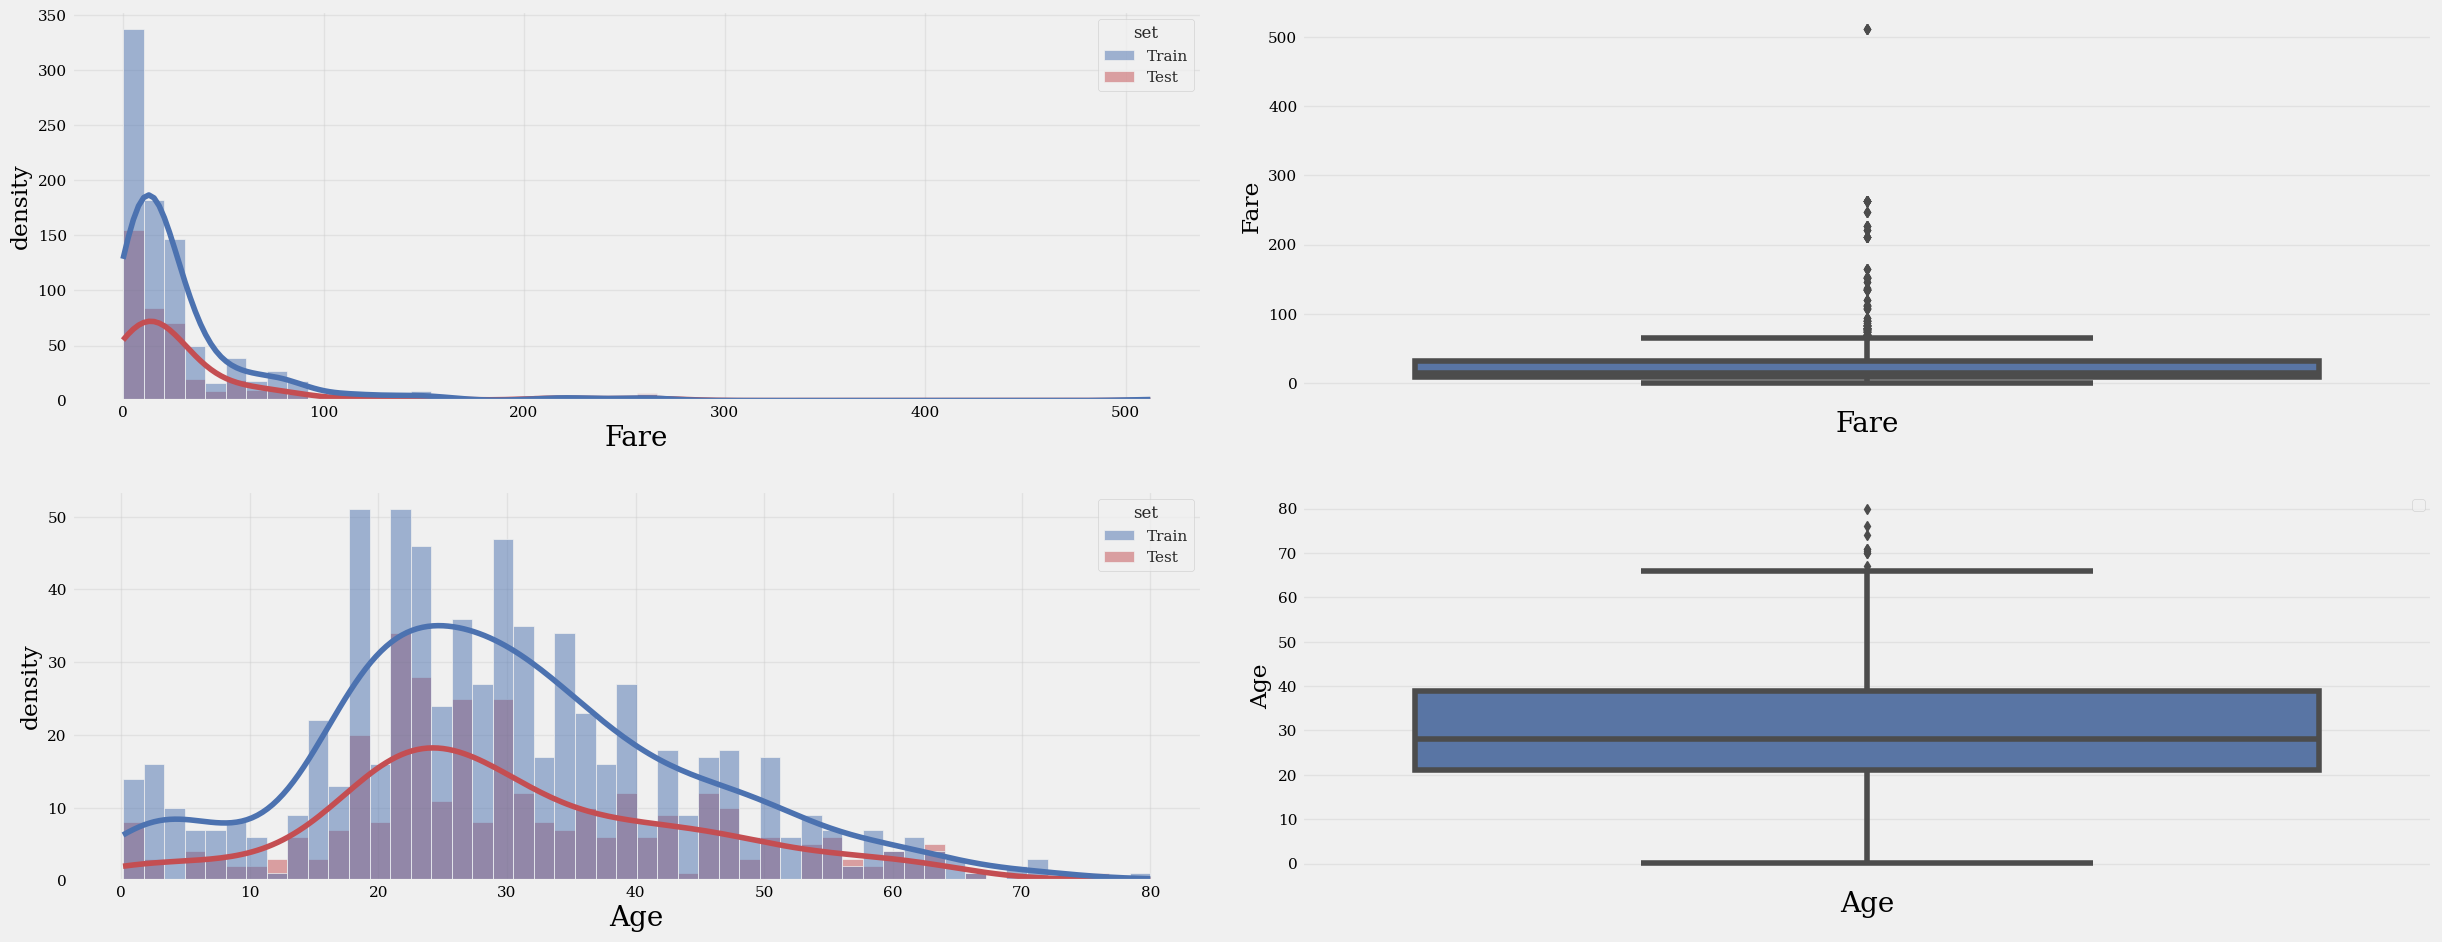

In [45]:
UVA_numeric_continuous(data_full,['Fare','Age'])

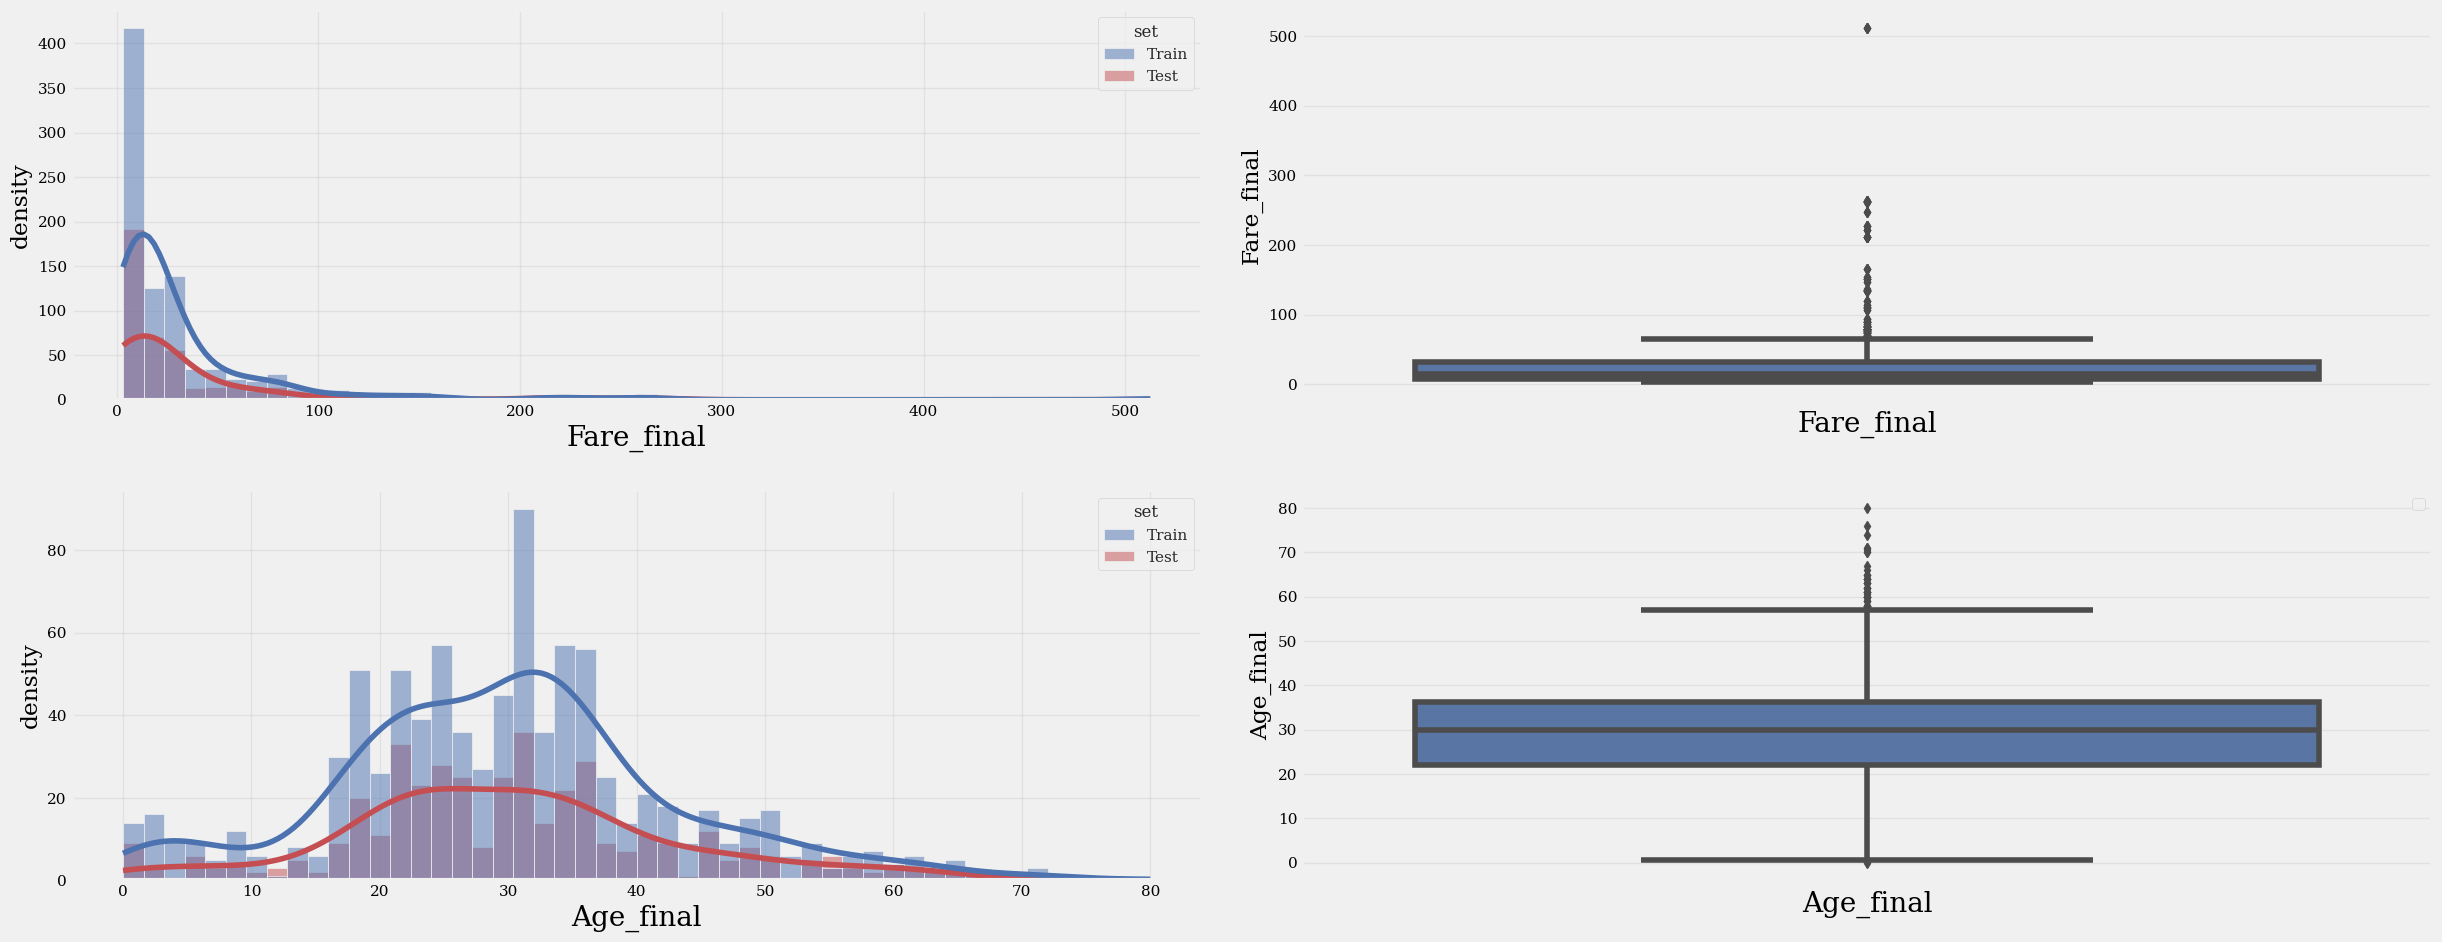

In [46]:
UVA_numeric_continuous(data_full,['Fare_final','Age_final'])

> ### Recap of cleaning operation performed

* I removed from data `Cabin` and `Ticket` as they are non-informative.
* I replaced missing  and zeros Fare values by median values depending of `Pclass`.
* For Age I replaced missing values by mean values depending of `Sex`,`Embarked` ports, and `formal_title` a new variable that I created basing on `name` by hoping to catch some clues.

Now let's check the outliers present in data.

# Univariate analysis Outliers

In [47]:
# custom function for easy outlier analysis

def UVA_outlier(data, var_group,include_outliers=True):
    '''
    Univariate_Analysis_outlier:
    takes a group of variables (INTEGER and FLOAT) and plot/print boxplot and descriptives
    Runs a loop: calculate all the descriptives of i-th variable and plot/print it

    data : dataframe from which to plot from
    var_group : [list] Group of Continuous variables
    include_outlier : [bool] whether to include outliers or not, default = True
    '''

    size = len(var_group)
    plt.figure(figsize = (7*size,4), dpi = 100)
    #data = data[(data.Survived == 1)]
    #looping for each variable
    for j,i in enumerate(var_group):

        # calculating descriptives of variable
        quant25 = round(data[i].quantile(q = 0.25), 2)
        quant75 = round(data[i].quantile(q= 0.75), 2)
        IQR = round(quant75 - quant25, 2)
        med = round(data[i].median(), 2)
        whis_low = quant25-(1.5*IQR)
        whis_high = quant75+(1.5*IQR)

        # Calculating Number of Outliers
        outlier_high = len(data[i][data[i]>whis_high])
        outlier_low = len(data[i][data[i]<whis_low])
        
        if include_outliers == True:
            #Plotting the variable with every information
            plt.subplot(1,size,j+1)
            sb.boxplot(data=data[i], orient="v")
            plt.ylabel(f'{i}')
            plt.title(f'With Outliers\nIQR = {IQR}; Median = {med}\n 1st,3rd quartile = {quant25, quant75};\n Outliers(low/high) = {(outlier_low,outlier_high)}')
      
        else:
            # replacing outliers with max/min whisker
            data2 = data[var_group][:]
            data2[i][data2[i]>whis_high] = whis_high
            data2[i][data2[i]<whis_low] = whis_low

            # plotting without outliers
            plt.subplot(1,size,j+1)
            sb.boxplot(data=data2[i], orient="v")
            plt.ylabel(f'{i}')
            plt.title(f'Without Outliers\nIQR = {IQR}; Median = {med}\n 1st,3rd quartile = {quant25, quant75}')

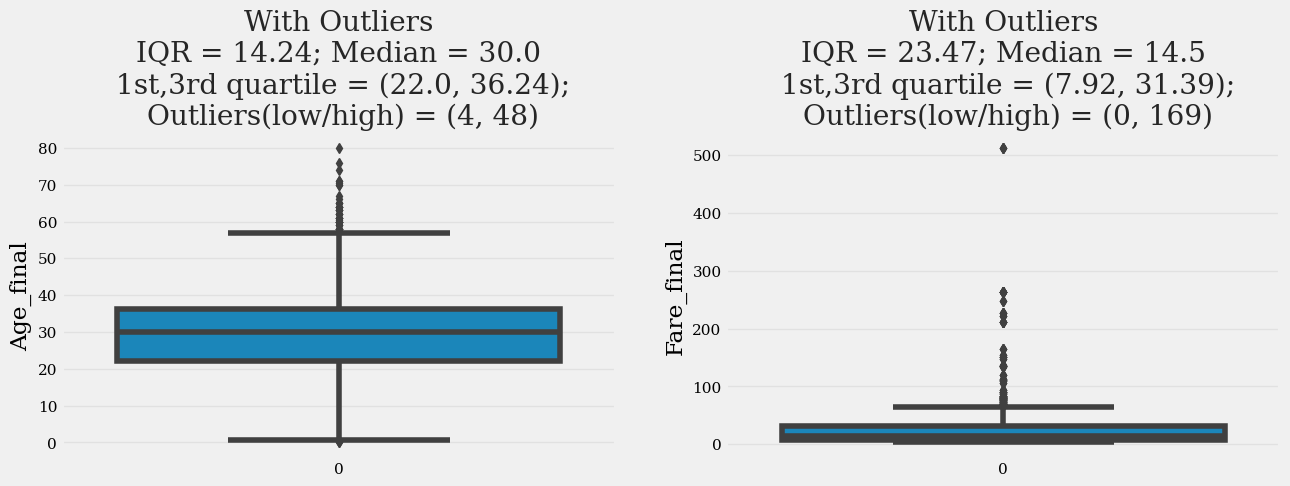

In [48]:
UVA_outlier(data_full,['Age_final','Fare_final'])

The outliers in `Age` are acceptable. As most of passengers are young and adults, that's normal to have this repartition. But for `Fare`, I will investigate on first class cabin prices. For sure we could consider some standing in first class depending of space or proximity of these cabins to an interest zone. If the number of upper outliers exceed the number of passengers in first class, that would imply that there is something wrong anywhere.

In [49]:
display(data_full.loc[(data_full.Pclass == 1)].head(10))
data_full.loc[(data_full.Pclass == 1)].shape

PassengerId  Survived  Pclass  \
1             2      1.00       1   
3             4      1.00       1   
6             7      0.00       1   
11           12      1.00       1   
23           24      1.00       1   
27           28      0.00       1   
30           31      0.00       1   
31           32      1.00       1   
34           35      0.00       1   
35           36      0.00       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.00      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.00      1   
6                             McCarthy, Mr. Timothy J    male 54.00      0   
11                           Bonnell, Miss. Elizabeth  female 58.00      0   
23                       Sloper, Mr. William Thompson    male 28.00      0   
27                     Fortune, Mr. Charles Alexander    male 19.00      3   
30                           Uruchurtu, Don. Manuel E    male 40.00      0   
31     Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1   
34                            Meyer, Mr. Edgar Joseph    male 28.00      1   
35                     Holverson, Mr. Alexander Oskar    male 42.00      1   

    Parch   Fare Embarked    set  Fare_final formal_titles  Age_final  \
1       0  71.28        C  Train       71.28           Mrs      38.00   
3       0  53.10        S  Train       53.10           Mrs      35.00   
6       0  51.86        S  Train       51.86            Mr      54.00   
11      0  26.55        S  Train       26.55          Miss      58.00   
23      0  35.50        S  Train       35.50            Mr      28.00   
27      2 263.00        S  Train      263.00            Mr      19.00   
30      0  27.72        C  Train       27.72           Don      40.00   
31      0 146.52        C  Train      146.52           Mrs      37.70   
34      0  82.17        C  Train       82.17            Mr      28.00   
35      0  52.00        S  Train       52.00            Mr      42.00   

   Age_category  
1         Adult  
3         Adult  
6         Adult  
11        Adult  
23        Adult  
27     Teenager  
30        Adult  
31        Adult  
34        Adult  
35        Adult

(321, 15)

We have 321 passengers in first class cabins with 169 in very expensive. So that looks good. Let's cover now bivariate analysis.

# Bivariate analysis : Numerical-Numerical

In [50]:
num_cols = ['Pclass','SibSp','Parch','Fare_final','Age_final','Survived']
num_dis_cols = ['Pclass','SibSp','Parch']
num_cnt_cols = ['Fare_final','Age_final']
nominal_cols = ['Age_category','formal_title', 'Embarked','Sex']

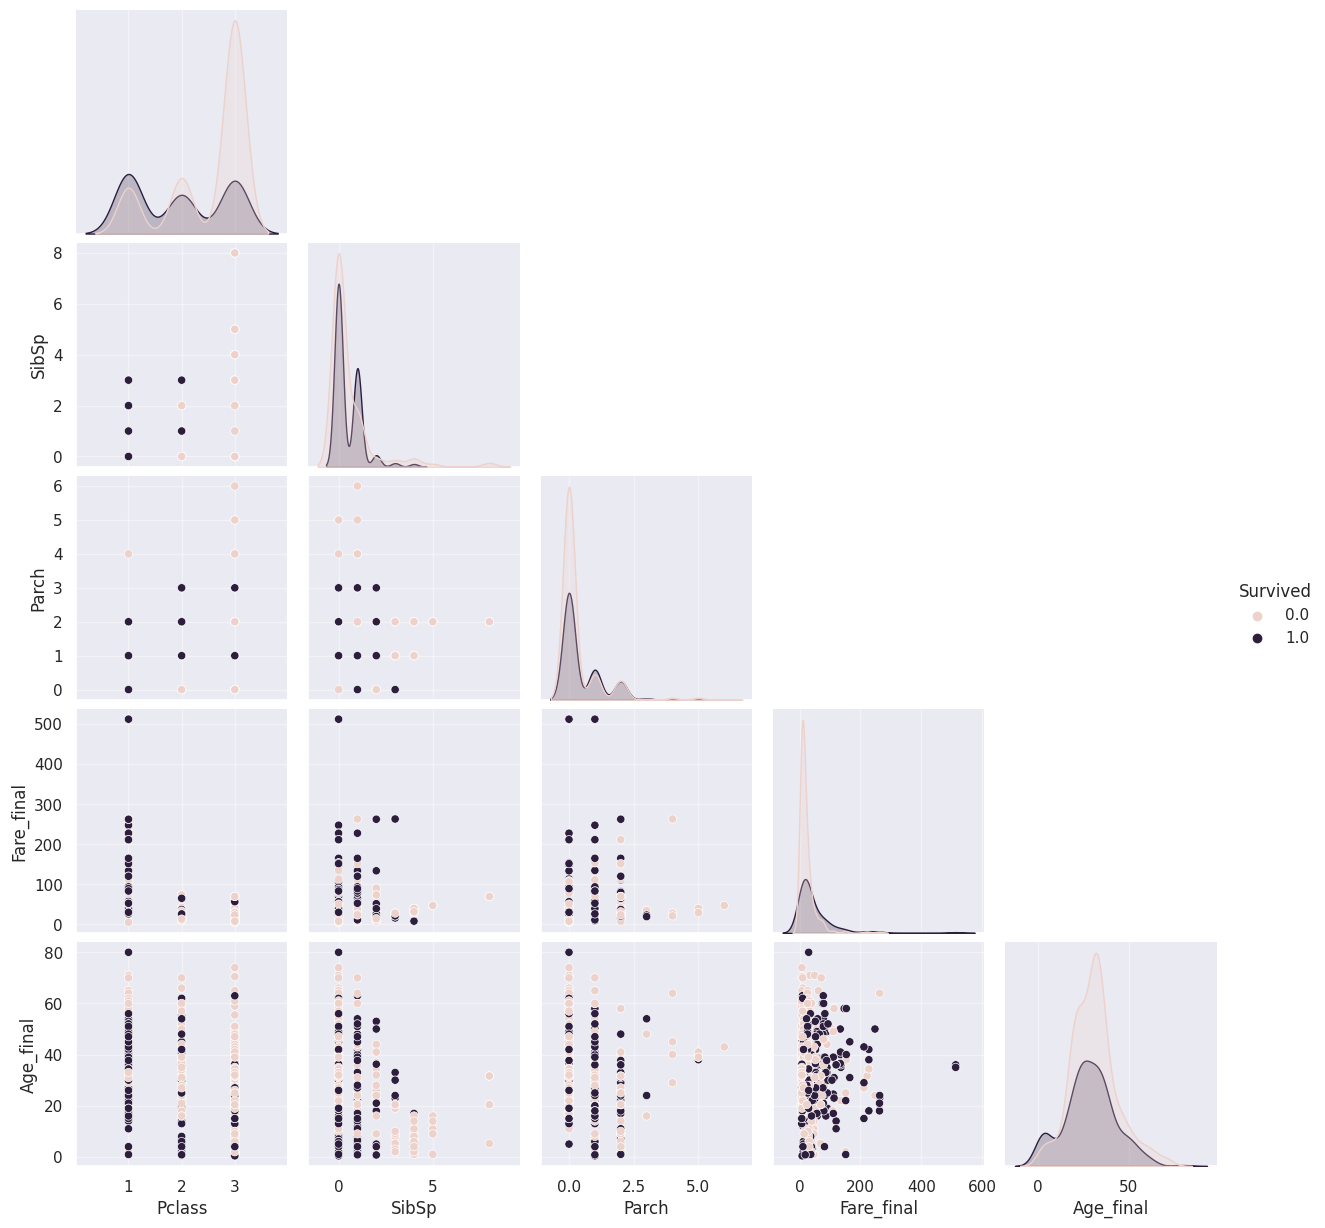

In [51]:
sb.set_theme()
sb.pairplot(data_full[num_cols], hue="Survived", corner=True,)
plt.show()

There we can see that passengers in first class

### Correlation Matrix

PassengerId  Survived  Pclass   Age  SibSp  Parch  Fare  \
PassengerId         1.00     -0.01   -0.04  0.03  -0.06   0.01  0.03   
Survived           -0.01      1.00   -0.34 -0.08  -0.03   0.08  0.26   
Pclass             -0.04     -0.34    1.00 -0.41   0.06   0.02 -0.56   
Age                 0.03     -0.08   -0.41  1.00  -0.24  -0.15  0.18   
SibSp              -0.06     -0.03    0.06 -0.24   1.00   0.37  0.16   
Parch               0.01      0.08    0.02 -0.15   0.37   1.00  0.22   
Fare                0.03      0.26   -0.56  0.18   0.16   0.22  1.00   
Fare_final          0.03      0.25   -0.57  0.18   0.16   0.22  1.00   
Age_final           0.02     -0.09   -0.36  1.00  -0.23  -0.14  0.16   

             Fare_final  Age_final  
PassengerId        0.03       0.02  
Survived           0.25      -0.09  
Pclass            -0.57      -0.36  
Age                0.18       1.00  
SibSp              0.16      -0.23  
Parch              0.22      -0.14  
Fare               1.00       0.16  
Fare_final         1.00       0.17  
Age_final          0.17       1.00

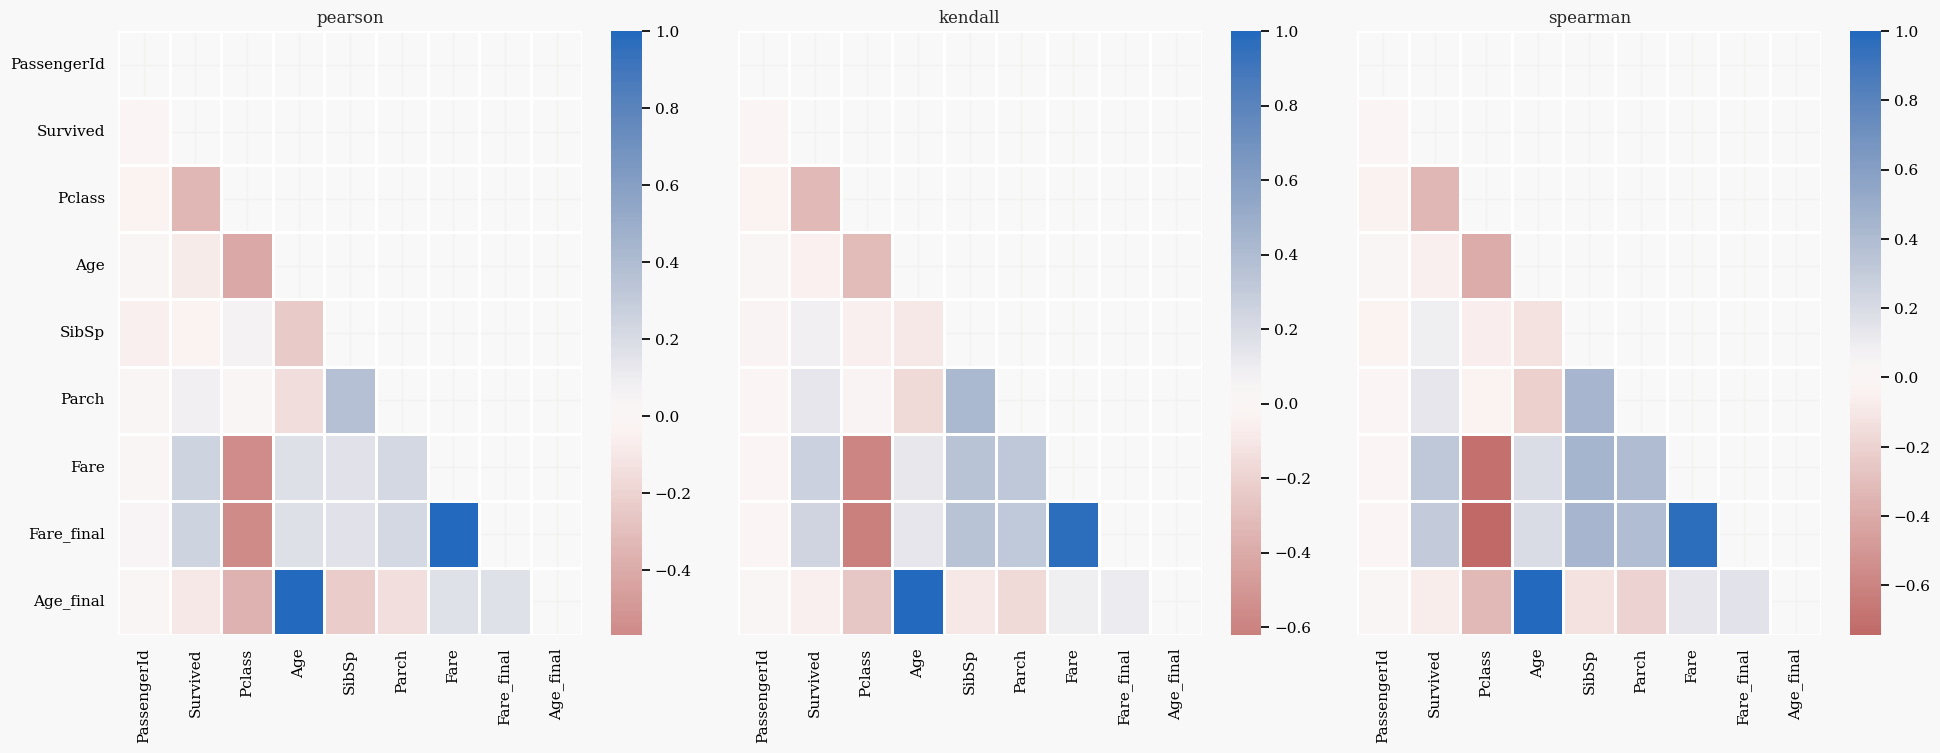

In [52]:
# isolating numerical datatypes
numerical = data_full.select_dtypes(include=['int64','float64','Int64'])[:]
# calculating correlation
correlation = numerical.corr()
display(correlation)
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
#sb.set_theme(style="whitegrid")
sb.set(rc=rc)
correlations = ['pearson','kendall','spearman']
fig, axes = plt.subplots(1, 3, figsize=(20,8), sharey='all')
for i, ax in enumerate(axes.ravel()):
    sb.heatmap(numerical.corr(method=correlations[i]), linewidths=2, cmap='vlag_r', center=0, ax=ax,mask=mask)
    axes[i].set_title(correlations[i])
plt.tight_layout(pad =2)

That looks logical, the Fare is inversely proportional at Pclass. The Fare is moderately correlated to Survival rate to Pclass. All others variables seems not affect a lot the survival rate.

Which age category has best survival rate?
Is there a link between whether a passenger travels alone or in a group and the survival rate?
How does family size affect survival rate?



In [53]:
data_full.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'set', 'Fare_final', 'formal_titles',
       'Age_final', 'Age_category'],
      dtype='object')

# Bivariate: Categorical-Categorical

In [54]:
from itertools import combinations
cats = ['Pclass','Sex','SibSp','Parch','Embarked','formal_titles','Age_category']
#cats_combi = list(combinations([i for i in range(7)],2))
cats_combi = list(combinations(cats,2))
cats_combi

[('Pclass', 'Sex'),
 ('Pclass', 'SibSp'),
 ('Pclass', 'Parch'),
 ('Pclass', 'Embarked'),
 ('Pclass', 'formal_titles'),
 ('Pclass', 'Age_category'),
 ('Sex', 'SibSp'),
 ('Sex', 'Parch'),
 ('Sex', 'Embarked'),
 ('Sex', 'formal_titles'),
 ('Sex', 'Age_category'),
 ('SibSp', 'Parch'),
 ('SibSp', 'Embarked'),
 ('SibSp', 'formal_titles'),
 ('SibSp', 'Age_category'),
 ('Parch', 'Embarked'),
 ('Parch', 'formal_titles'),
 ('Parch', 'Age_category'),
 ('Embarked', 'formal_titles'),
 ('Embarked', 'Age_category'),
 ('formal_titles', 'Age_category')]

In [55]:
from scipy.stats import chi2_contingency
def BVA_categorical_plot(data, tar, cat):
    '''
    take data and two categorical variables,
    calculates the chi2 significance between the two variables 
    and prints the result with countplot & CrossTab
    '''
    #isolating the variables
    data = data[[cat,tar]][:]

    #forming a crosstab
    table = pd.crosstab(data[tar],data[cat])
    display(table)
    chi, p, dof, expected = chi2_contingency(table)

    #checking whether results are significant
    if p<0.05:
        sig = True
    else:
        sig = False

    #plotting grouped plot
    sb.countplot(x=cat, hue=tar, data=data)
    #ctplt.bar_label(ctplt.containers[0], fontsize=10);
    plt.title(f"p-value = {round(p, 8)}\n difference significant? = {sig}\n")

    #plotting percent stacked bar plot
    ax1 = pd.crosstab(data[cat], data[tar], normalize='index')
    # ax1 = data.groupby(cat)[tar].value_counts(normalize=True).unstack() old code
    ax1.plot(kind='bar', stacked='True',title=str(ax1))
    plt.show()
    # int_level = data[cat].value_counts() old code

Sex     female  male
Pclass              
1           89    45
2           70    17
3           72    47

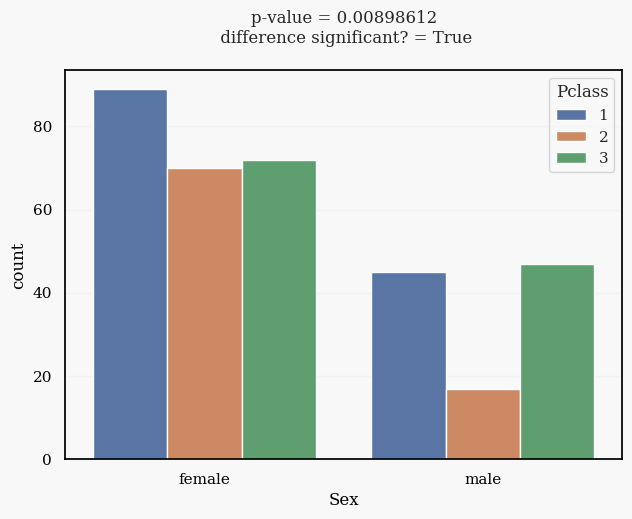

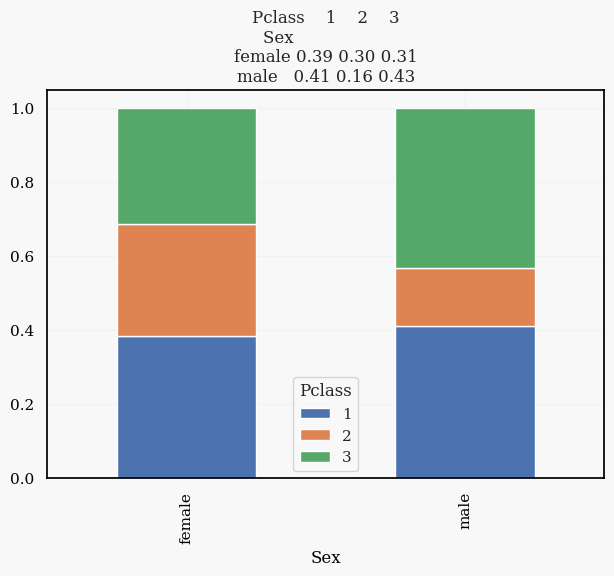

SibSp    0   1  2  3  4
Pclass                 
1       75  53  4  2  0
2       50  32  4  1  0
3       83  27  5  1  3

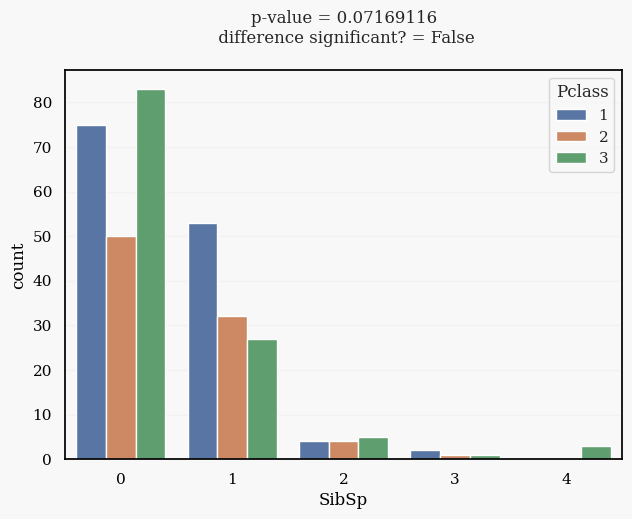

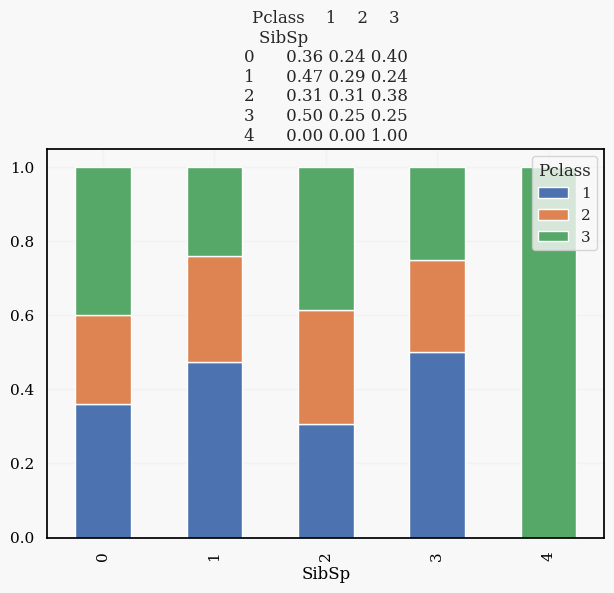

Parch    0   1   2  3  5
Pclass                  
1       97  21  16  0  0
2       48  24  13  2  0
3       86  20  11  1  1

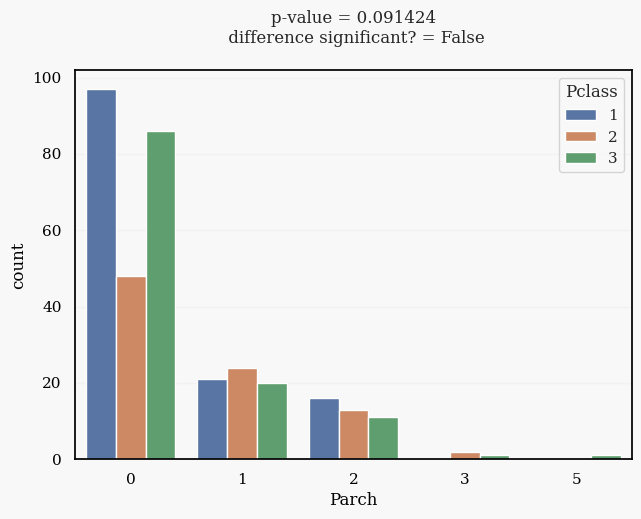

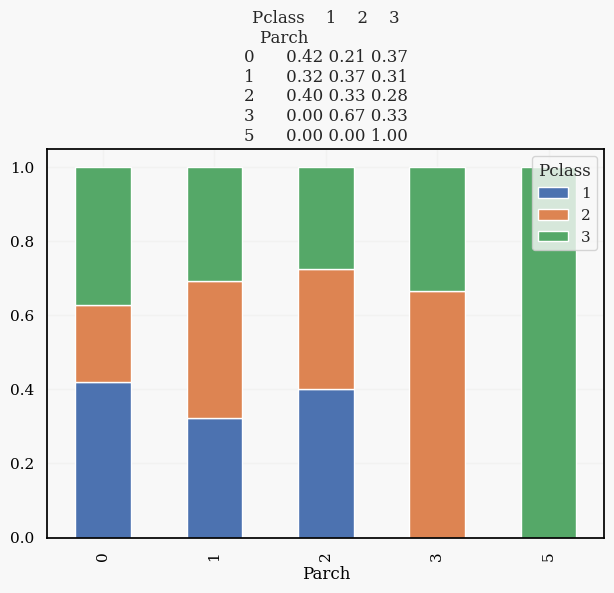

Embarked   C   Q   S
Pclass              
1         59   1  74
2          9   2  76
3         25  27  67

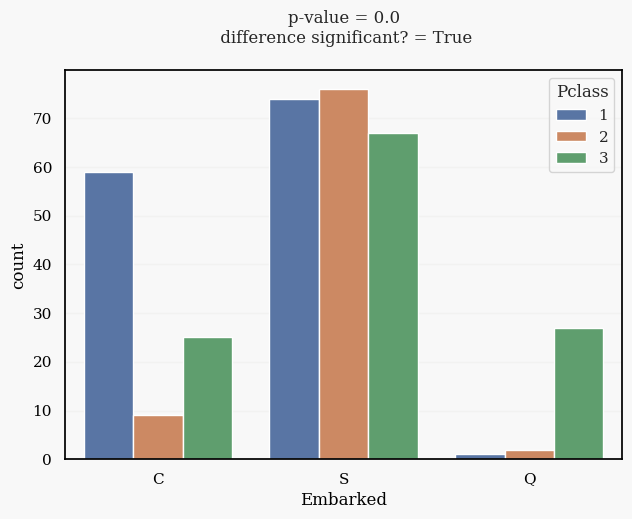

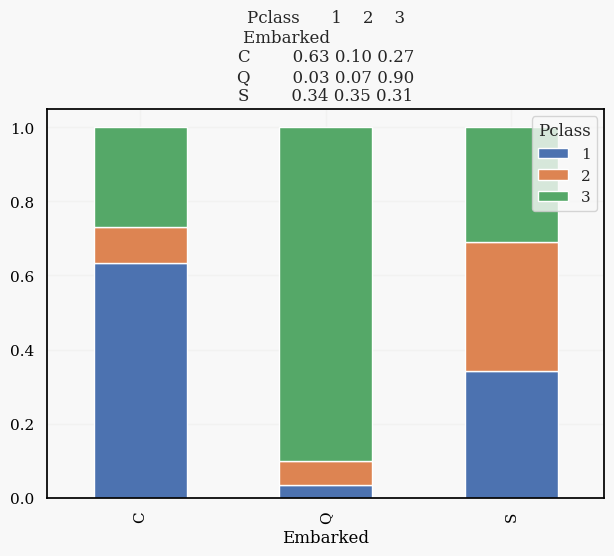

formal_titles  Col  Dr  Lady  Major  Master  Miss  Mlle  Mme  Mr  Mrs  Ms  \
Pclass                                                                      
1                1   3     1      1       3    43     2    1  37   40   0   
2                0   0     0      0       9    32     0    0   8   37   1   
3                0   0     0      0      11    51     0    0  36   21   0   

formal_titles  Sir  the Countess  
Pclass                            
1                1             1  
2                0             0  
3                0             0

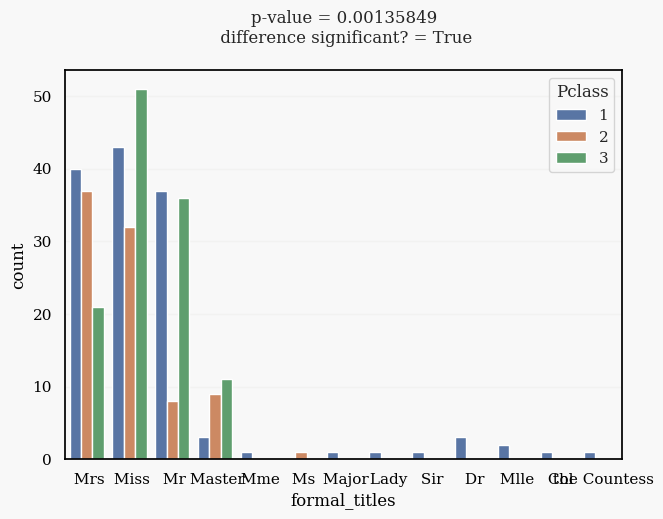

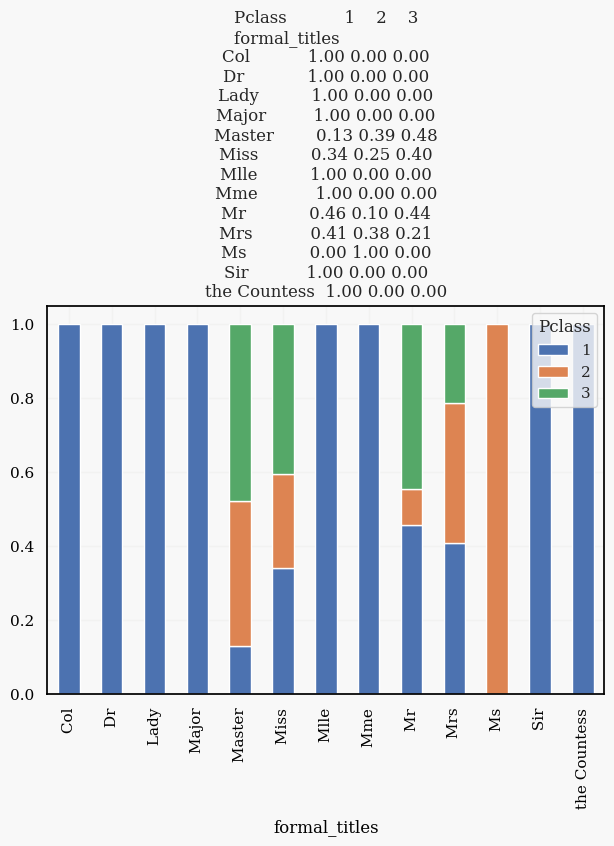

Age_category  Adult  Child  Elders  Teenager
Pclass                                      
1               101      4       1        28
2                49     19       0        19
3                47     24       0        48

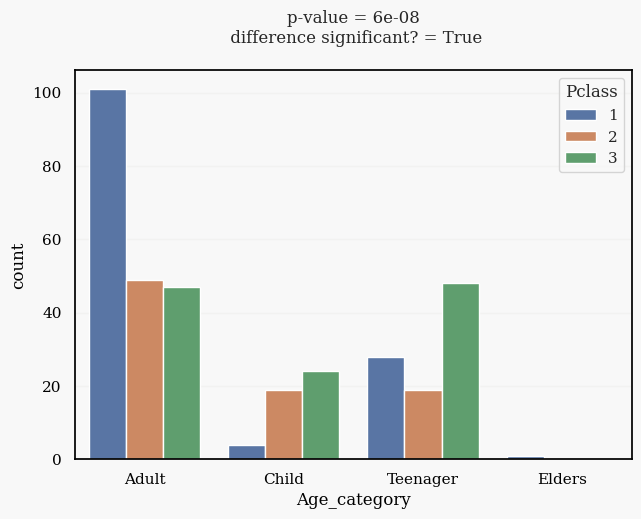

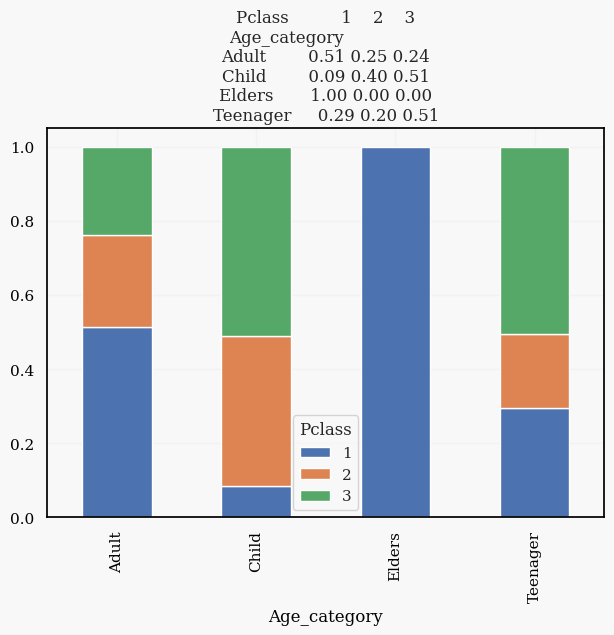

SibSp     0   1   2  3  4
Sex                      
female  135  80  10  4  2
male     73  32   3  0  1

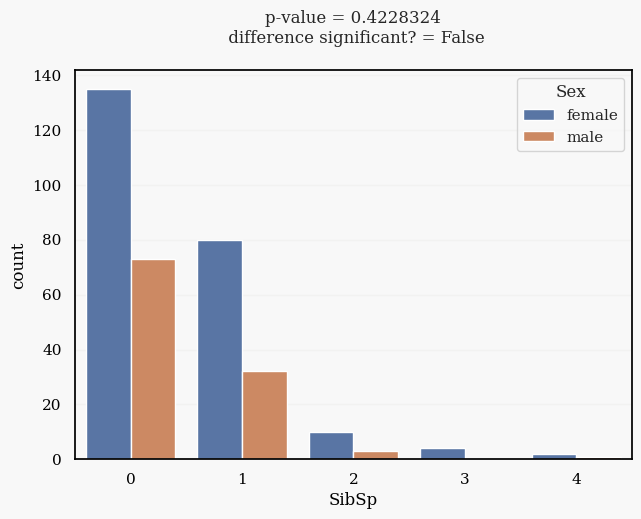

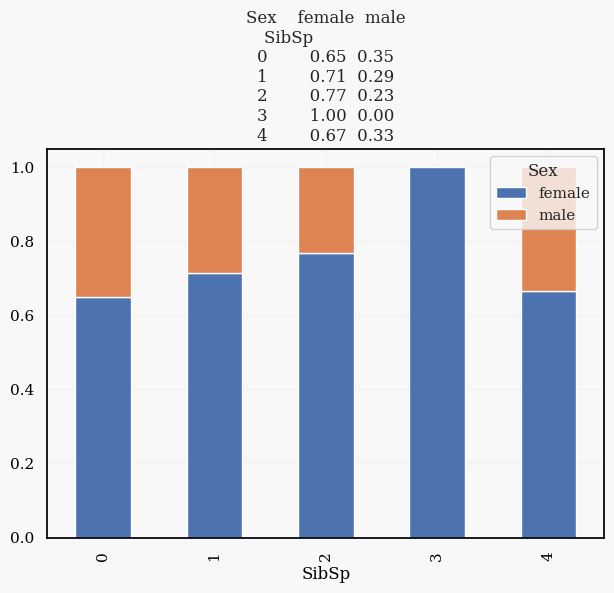

Parch     0   1   2  3  5
Sex                      
female  151  46  30  3  1
male     80  19  10  0  0

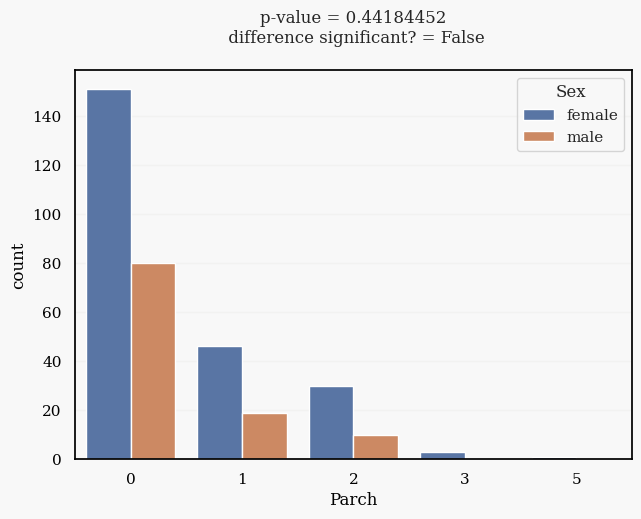

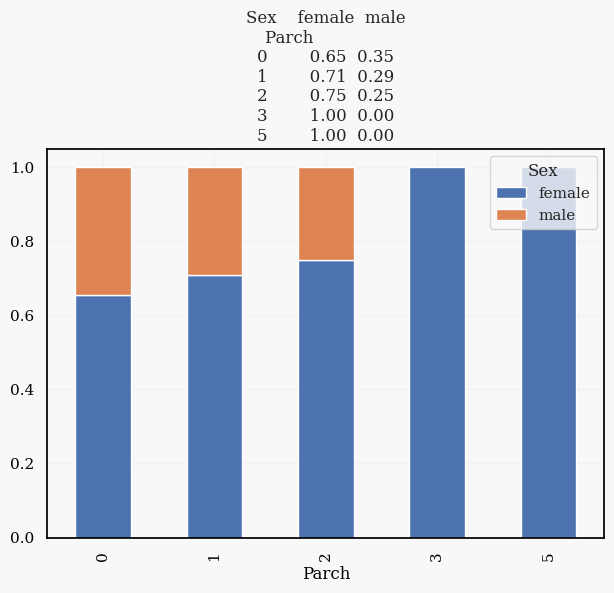

Embarked   C   Q    S
Sex                  
female    64  27  140
male      29   3   77

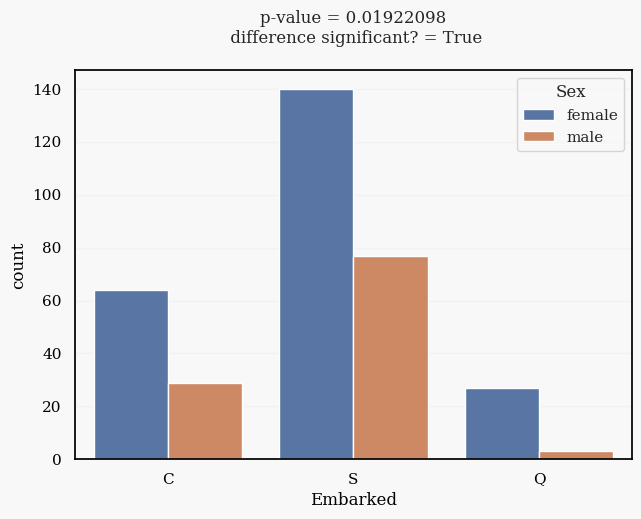

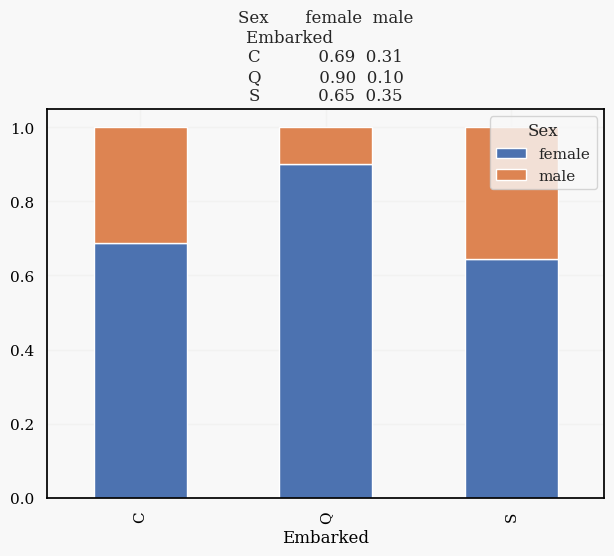

formal_titles  Col  Dr  Lady  Major  Master  Miss  Mlle  Mme  Mr  Mrs  Ms  \
Sex                                                                         
female           0   1     1      0       0   126     2    1   0   98   1   
male             1   2     0      1      23     0     0    0  81    0   0   

formal_titles  Sir  the Countess  
Sex                               
female           0             1  
male             1             0

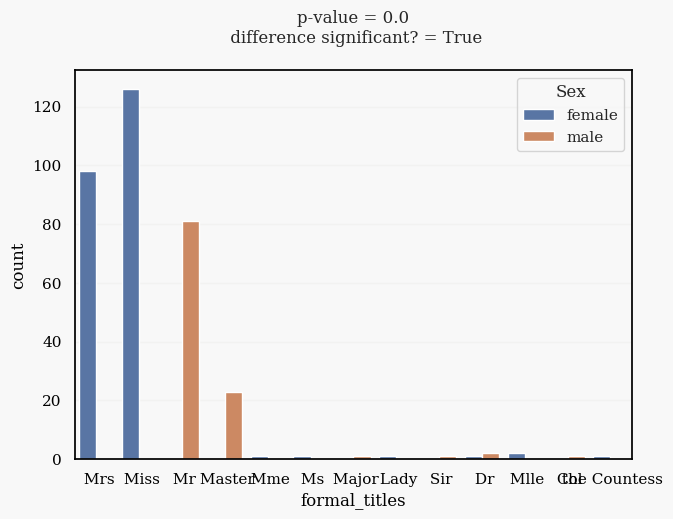

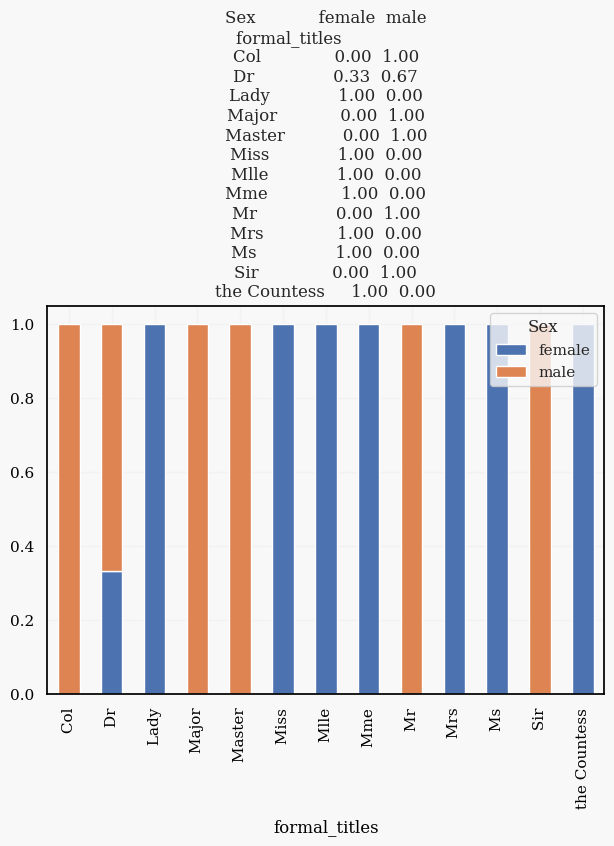

Age_category  Adult  Child  Elders  Teenager
Sex                                         
female          124     24       0        83
male             73     23       1        12

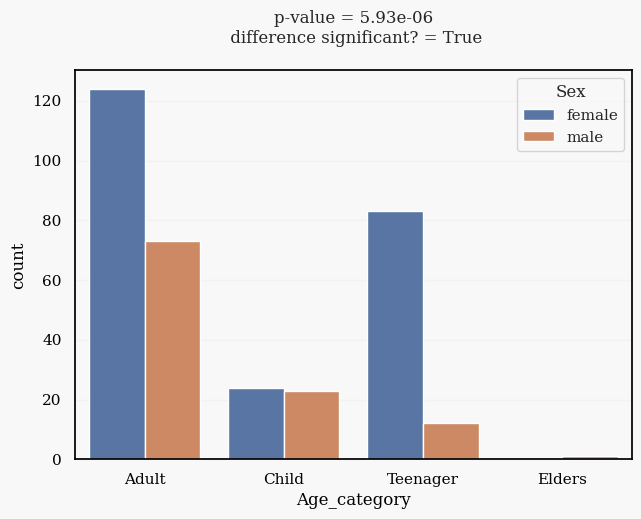

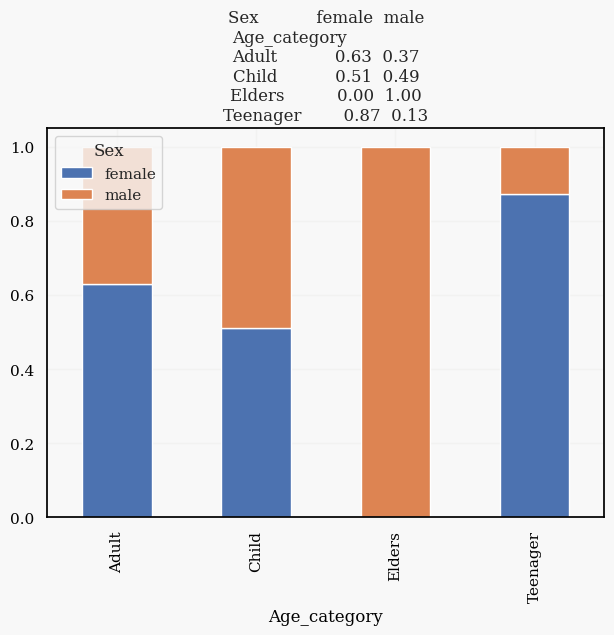

Parch    0   1   2  3  5
SibSp                   
0      161  25  21  1  0
1       64  34  12  1  1
2        4   6   2  1  0
3        2   0   2  0  0
4        0   0   3  0  0

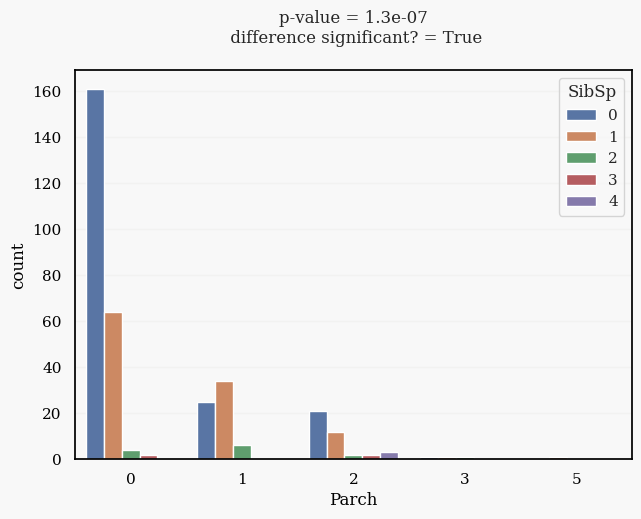

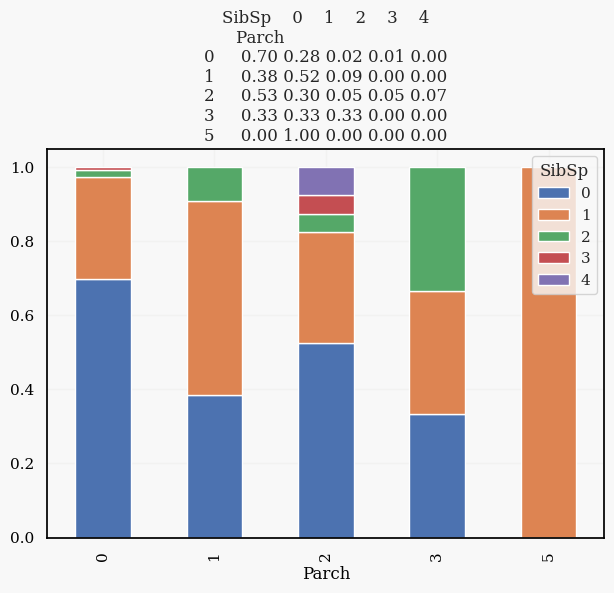

Embarked   C   Q    S
SibSp                
0         52  23  133
1         36   5   71
2          5   2    6
3          0   0    4
4          0   0    3

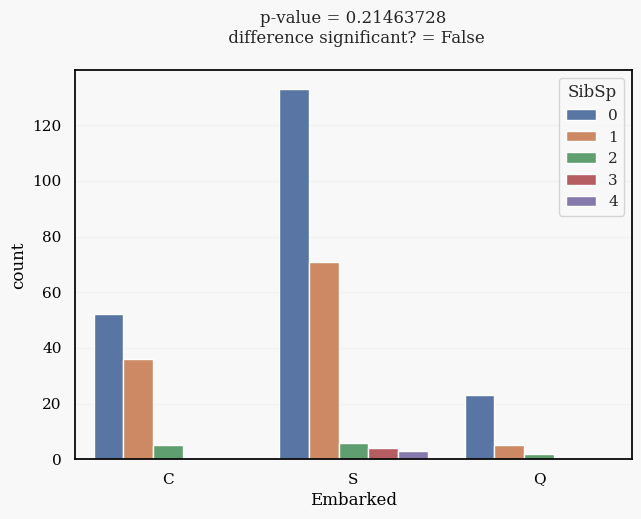

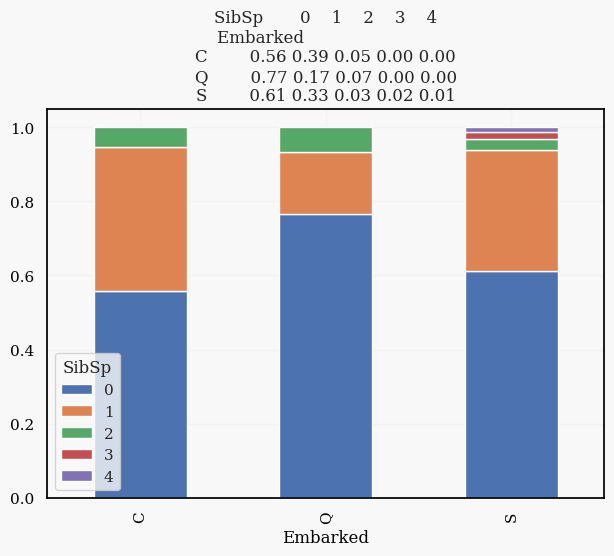

formal_titles  Col  Dr  Lady  Major  Master  Miss  Mlle  Mme  Mr  Mrs  Ms  \
SibSp                                                                       
0                1   2     0      1       6    93     2    1  64   36   1   
1                0   0     1      0      15    22     0    0  16   57   0   
2                0   1     0      0       1     7     0    0   1    3   0   
3                0   0     0      0       0     2     0    0   0    2   0   
4                0   0     0      0       1     2     0    0   0    0   0   

formal_titles  Sir  the Countess  
SibSp                             
0                0             1  
1                1             0  
2                0             0  
3                0             0  
4                0             0

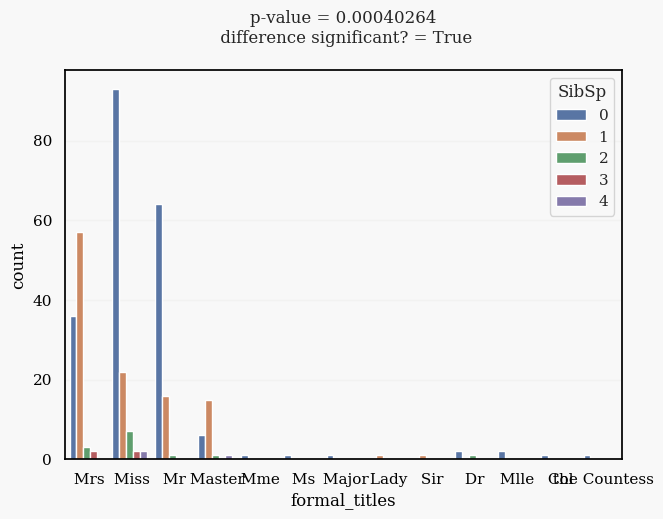

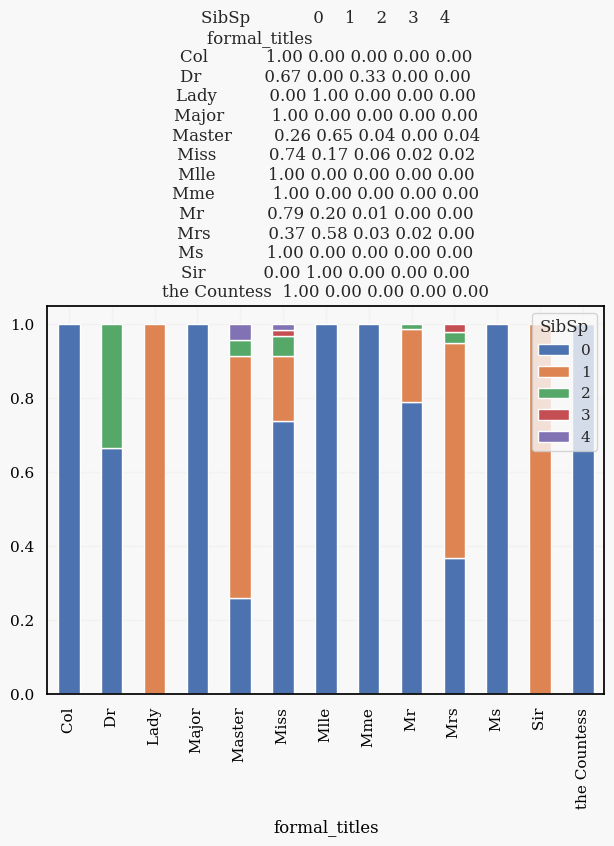

Age_category  Adult  Child  Elders  Teenager
SibSp                                       
0               124     16       1        67
1                68     24       0        20
2                 3      5       0         5
3                 2      0       0         2
4                 0      2       0         1

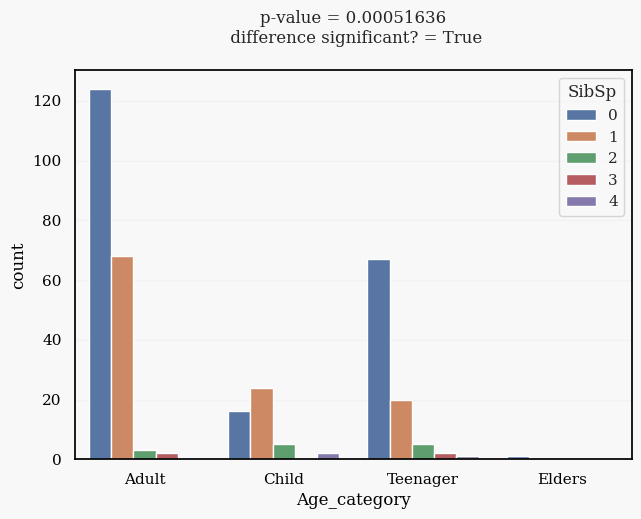

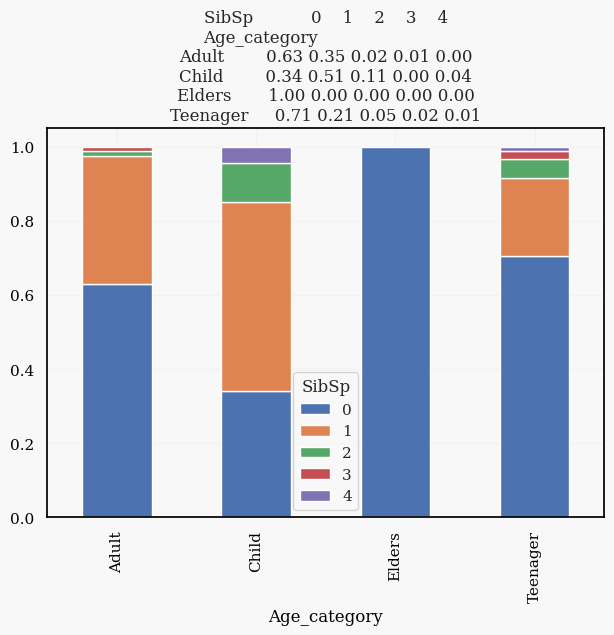

Embarked   C   Q    S
Parch                
0         63  30  138
1         19   0   46
2         10   0   30
3          1   0    2
5          0   0    1

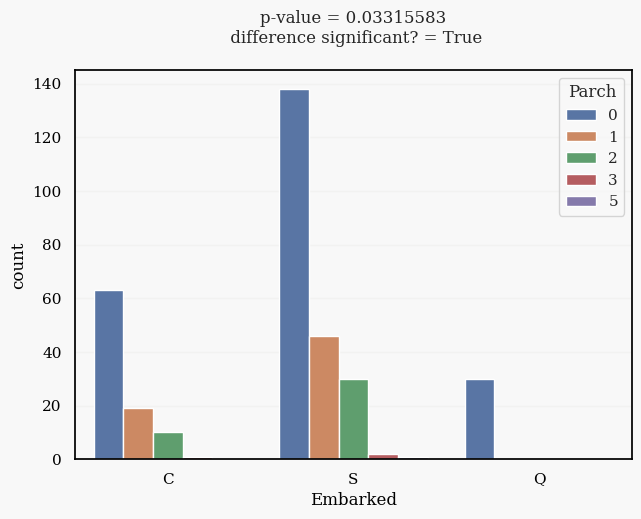

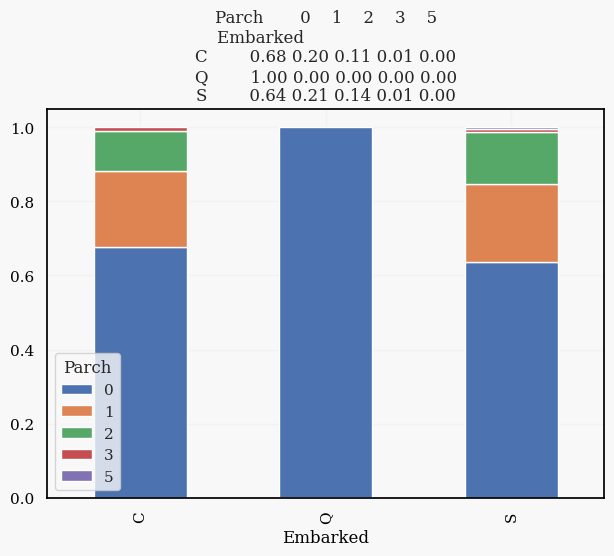

formal_titles  Col  Dr  Lady  Major  Master  Miss  Mlle  Mme  Mr  Mrs  Ms  \
Parch                                                                       
0                1   3     1      1       1    86     2    1  74   58   1   
1                0   0     0      0      14    20     0    0   5   26   0   
2                0   0     0      0       8    20     0    0   2   10   0   
3                0   0     0      0       0     0     0    0   0    3   0   
5                0   0     0      0       0     0     0    0   0    1   0   

formal_titles  Sir  the Countess  
Parch                             
0                1             1  
1                0             0  
2                0             0  
3                0             0  
5                0             0

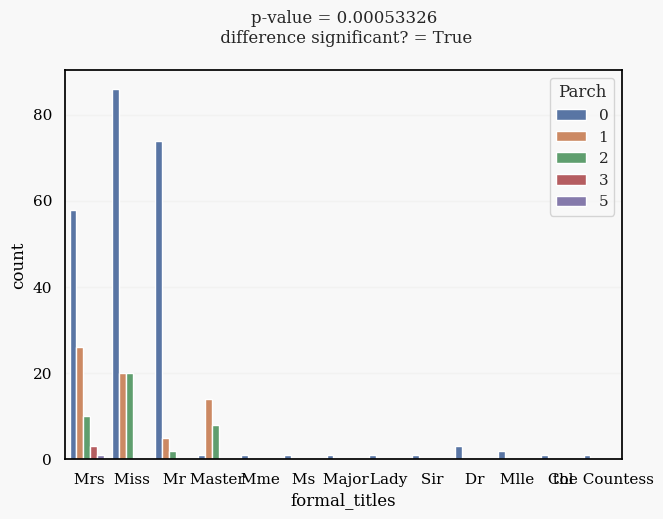

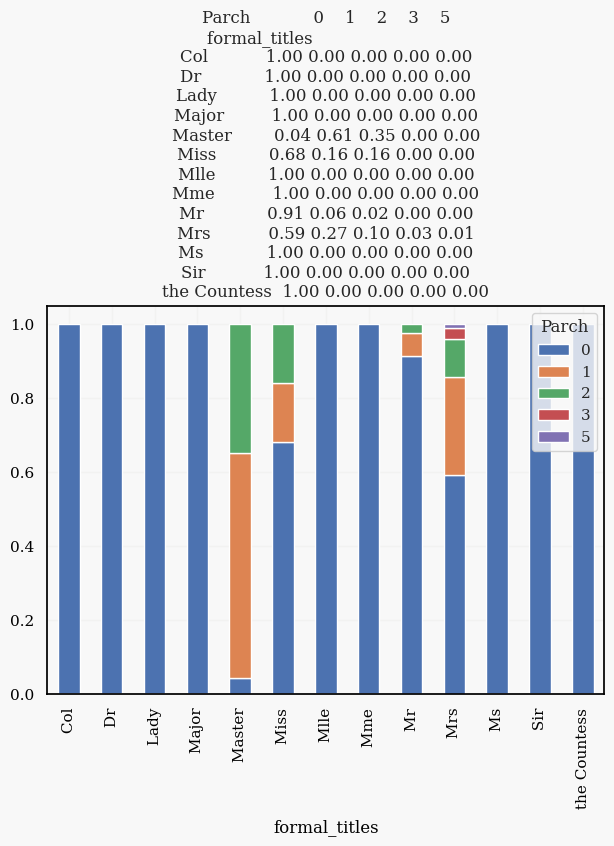

Age_category  Adult  Child  Elders  Teenager
Parch                                       
0               157      5       1        68
1                28     26       0        11
2                10     16       0        14
3                 1      0       0         2
5                 1      0       0         0

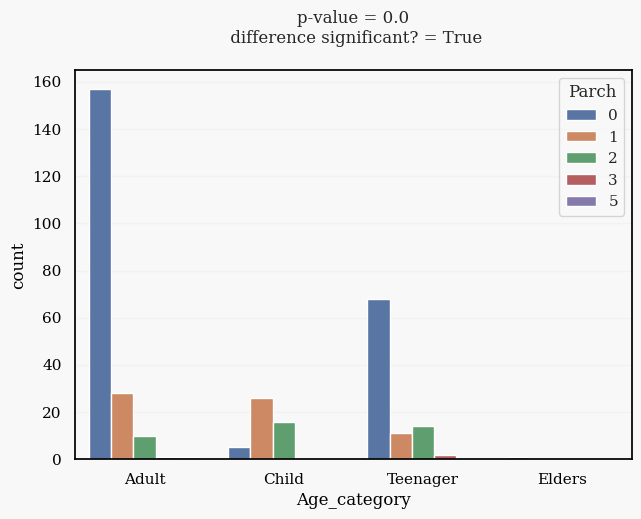

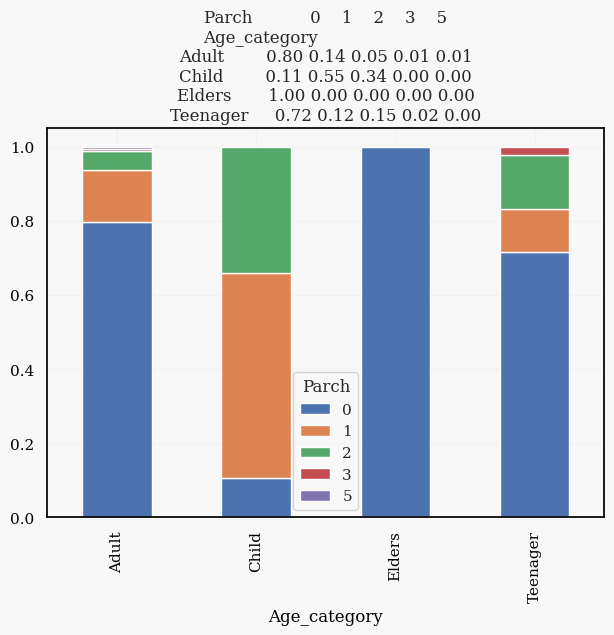

formal_titles  Col  Dr  Lady  Major  Master  Miss  Mlle  Mme  Mr  Mrs  Ms  \
Embarked                                                                    
C                1   1     1      0       5    32     2    1  21   28   0   
Q                0   0     0      0       0    26     0    0   3    1   0   
S                0   2     0      1      18    68     0    0  57   69   1   

formal_titles  Sir  the Countess  
Embarked                          
C                1             0  
Q                0             0  
S                0             1

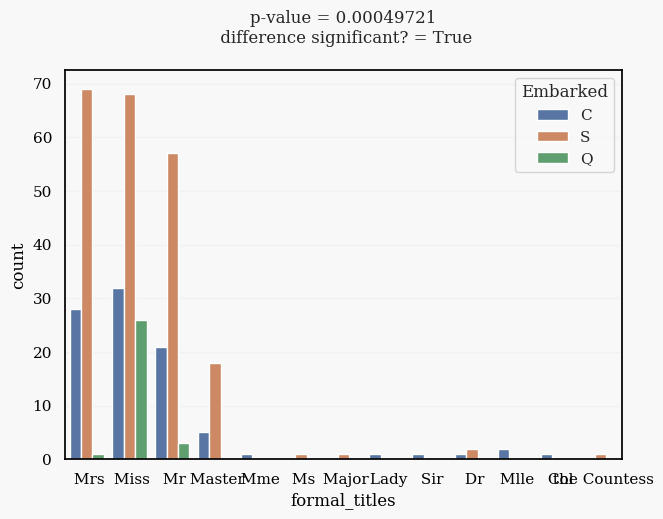

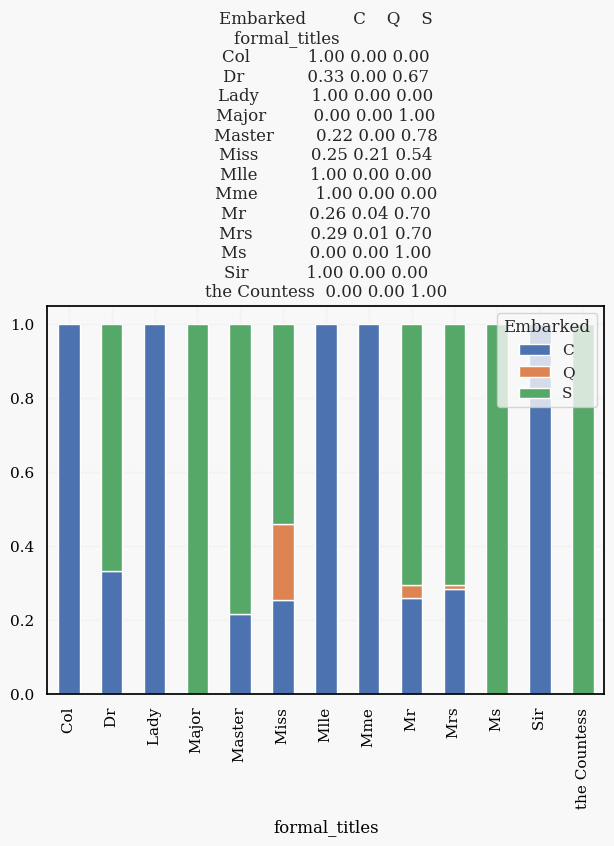

Age_category  Adult  Child  Elders  Teenager
Embarked                                    
C                54     14       0        25
Q                 6      0       0        24
S               137     33       1        46

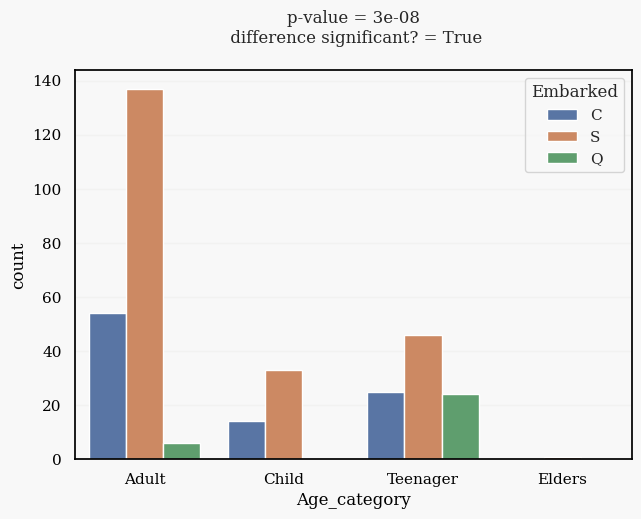

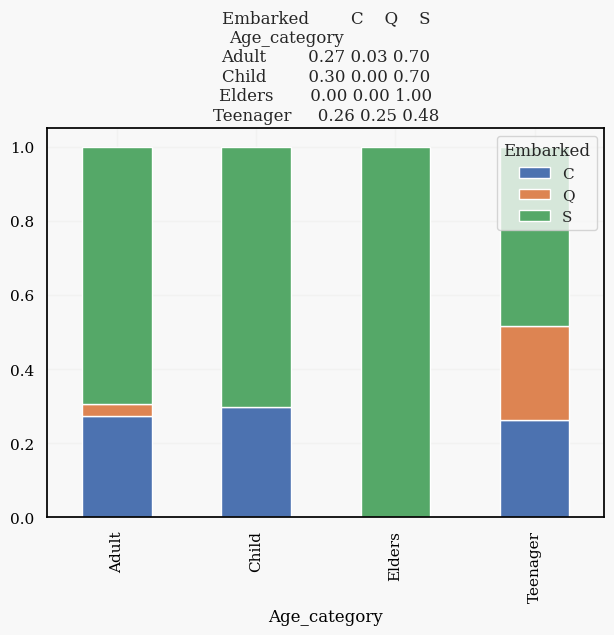

In [56]:
for el in cats_combi[:-1]:
    BVA_categorical_plot(data_full.loc[(data_full.Survived ==1)], el[0], el[1])

* Among survivors we can see that most are female (more than 60% from Cherbourg, Queenstown, and Shouthampton) and at majority in first class cabin.
* On another board most of man that survived were in third class followed by those in first class cabin.
* The proportions of survivors based on siblings number in cabin classes are not statisticallly significant. So having siblings in first, second or in third class will not infer on the survival rate. Same for number of children and parents.

* Most of survivors traveled in first class embarked from Cherbourg; in third class from Queenstwon; in second and first class from Southampton.
* Fortunate passengers (referring to their title) took in majority the first class cabins.
* Most of adults took the first class cabins, children, teenagers more in third class.
* Only one elder survived and he took a first class cabin and embarked from Southampton. 
* 70% of solo travelers survived, 53% of passengers with 2 parents/childern survived, 52% of couples or solo travelers with one sibling having a child survived.
* Tragic, only one member of a couple having 5 children survived.
* Passengers having more than one sibling got a very low surivival rate. Only 11% of children not having a parent aboard of titanic survived.


As the continous variables Fare, Age are respectively moderately and lowly correlated to Survival rate, that could not be interesting to make a categorical-numerical bivariate analysis. So let's make feature engineering.

In [57]:
data_full.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'set', 'Fare_final', 'formal_titles',
       'Age_final', 'Age_category'],
      dtype='object')

In [58]:
final_cols = ['PassengerId','Survived', 'Pclass', 'Sex','set', 'SibSp', 'Parch','Embarked', 'Fare_final', 'formal_titles', 'Age_final',
       'Age_category']
data_full = data_full[final_cols]

data_train = data_full.loc[data_full.set == 'Train']
data_test = data_full.loc[data_full.set == 'Test']

#display(data_test.head())

table = PrettyTable()
print('\t'+' Data{Length: '+str(data_train.shape)+'} \n')
data_types ={}
for i in data_train.columns.to_list():
    data_types[i]=str(type(data_train[i].loc[0]))
table.add_column("Column Name",data_train.columns.to_list())
table.add_column("NaN_cnt",data_train.isna().sum())
table.add_column("NaN_percent",data_train.isna().sum()/len(data_train))
table.add_column("Content_tbype",list(data_types.values()))
table.add_column("N_Unique_values",data_train.nunique())
print(table)

table = PrettyTable()
print('\t'+' Data_test{Length: '+str(data_test.shape)+'} \n')
data_types ={}
for i in data_test.columns.to_list():
    data_types[i]=str(type(data_test[i].loc[data_test.index[0]]))
table.add_column("Column Name",data_test.columns.to_list())
table.add_column("NaN_cnt",data_test.isna().sum())
table.add_column("NaN_percent",data_test.isna().sum()/len(data_test))
table.add_column("Content_tbype",list(data_types.values()))
table.add_column("N_Unique_values",data_test.nunique())
print(table)

	 Data{Length: (889, 12)} 

+---------------+---------+-------------+-------------------------+-----------------+
|  Column Name  | NaN_cnt | NaN_percent |      Content_tbype      | N_Unique_values |
+---------------+---------+-------------+-------------------------+-----------------+
|  PassengerId  |    0    |     0.0     |  <class 'numpy.int64'>  |       889       |
|    Survived   |    0    |     0.0     | <class 'numpy.float64'> |        2        |
|     Pclass    |    0    |     0.0     |  <class 'numpy.int64'>  |        3        |
|      Sex      |    0    |     0.0     |      <class 'str'>      |        2        |
|      set      |    0    |     0.0     |      <class 'str'>      |        1        |
|     SibSp     |    0    |     0.0     |  <class 'numpy.int64'>  |        7        |
|     Parch     |    0    |     0.0     |  <class 'numpy.int64'>  |        7        |
|    Embarked   |    0    |     0.0     |      <class 'str'>      |        3        |
|   Fare_final  |    0    

# Numerical Transformations

In [59]:
from sklearn.preprocessing import MinMaxScaler as min_max
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

        
def min_max_scaler_test(train, test, column):
    '''
    Min Max just based on train might have an issue if test has extreme values, hence changing the denominator using overall min and max
    '''
    test_cols = ['Survived', 'Pclass','set', 'SibSp', 'Parch', 'Fare_final', 'Age_final']
    data_full_t = data_full[test_cols]
    train_t = data_full_t.loc[data_full_t.set == 'Train']
    test_t = data_full_t.loc[data_full_t.set == 'Test']
    train_t.drop(columns=['set'],axis = 1,inplace = True)
    test_t.drop(columns=['set','Survived'],axis = 1,inplace = True)
    
    max_val=max(train_t[column].max(),test_t[column].max())
    min_val=min(train_t[column].min(),test_t[column].min())

    train_t[column]=(train_t[column]-min_val)/(max_val-min_val)
    test_t[column]=(test_t[column]-min_val)/(max_val-min_val)
    return train_t,test_t  

unimportant_features=[]
overall_best_score=0
overall_best_col='none'

for col in num_cnt_cols:
     data_train_t, data_test_t=min_max_scaler_test(data_train, data_test, column=col)

table = PrettyTable()
print('\t'+' Data_train{Length: '+str(data_train_t.shape)+'} \n')
data_types ={}
for i in data_train_t.columns.to_list():
    data_types[i]=str(type(data_train_t[i].loc[data_train_t.index[0]]))
table.add_column("Column Name",data_train_t.columns.to_list())
table.add_column("NaN_cnt",data_train_t.isna().sum())
table.add_column("NaN_percent",data_train_t.isna().sum()/len(data_train_t))
table.add_column("Content_tbype",list(data_types.values()))
table.add_column("N_Unique_values",data_train_t.nunique())
print(table)

table = PrettyTable()
print('\t'+' Data_test{Length: '+str(data_test_t.shape)+'} \n')
data_types ={}
for i in data_test_t.columns.to_list():
    data_types[i]=str(type(data_test_t[i].loc[data_test_t.index[0]]))
table.add_column("Column Name",data_test_t.columns.to_list())
table.add_column("NaN_cnt",data_test_t.isna().sum())
table.add_column("NaN_percent",data_test_t.isna().sum()/len(data_test_t))
table.add_column("Content_tbype",list(data_types.values()))
table.add_column("N_Unique_values",data_test_t.nunique())
print(table)

	 Data_train{Length: (889, 6)} 

+-------------+---------+-------------+-------------------------+-----------------+
| Column Name | NaN_cnt | NaN_percent |      Content_tbype      | N_Unique_values |
+-------------+---------+-------------+-------------------------+-----------------+
|   Survived  |    0    |     0.0     | <class 'numpy.float64'> |        2        |
|    Pclass   |    0    |     0.0     |  <class 'numpy.int64'>  |        3        |
|    SibSp    |    0    |     0.0     |  <class 'numpy.int64'>  |        7        |
|    Parch    |    0    |     0.0     |  <class 'numpy.int64'>  |        7        |
|  Fare_final |    0    |     0.0     | <class 'numpy.float64'> |       247       |
|  Age_final  |    0    |     0.0     | <class 'numpy.float64'> |        98       |
+-------------+---------+-------------+-------------------------+-----------------+
	 Data_test{Length: (418, 5)} 

+-------------+---------+-------------+-------------------------+-----------------+
| Column Na

In [60]:
def transformer_data(train, test,cont_cols,mandat_cols, target):
    '''
    Algorithm applies multiples transformations on selected columns and finds the best transformation using a single variable model performance
    '''
    global unimportant_features
    global overall_best_score
    global overall_best_col
    train_copy = train.copy()
    test_copy = test.copy()
    #print(train_copy.isna().sum())
    #print(test_copy.isna().sum())
    table = PrettyTable()
    table.field_names = ['Feature', 'Initial Accuracy', 'Transformation', 'Tranformed Accuracy']

    for col in cont_cols:
        
        for c in ["log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col, "log_sqrt"+col, "pow_"+col, "pow2_"+col]:
            if c in train_copy.columns:
                train_copy = train_copy.drop(columns=[c])
        
        # Log Transformation after MinMax Scaling (keeps data between 0 and 1)
        train_copy["log_"+col] = np.log1p(train_copy[col])
        test_copy["log_"+col] = np.log1p(test_copy[col])
        
        # Square Root Transformation
        train_copy["sqrt_"+col] = np.sqrt(train_copy[col])
        test_copy["sqrt_"+col] = np.sqrt(test_copy[col])
        
        # Box-Cox transformation
        combined_data = pd.concat([train_copy[[col]], test_copy[[col]]], axis=0)
        epsilon = 1e-5
        transformer = PowerTransformer(method='box-cox')
#       scaled_data = transformer.fit_transform(combined_data + epsilon)

#       train_copy["bx_cx_" + col] = scaled_data[:train_copy.shape[0]]
#       test_copy["bx_cx_" + col] = scaled_data[train_copy.shape[0]:]
        train_copy["bx_cx_" + col] = transformer.fit_transform(train_copy[[col]]+epsilon)
        test_copy["bx_cx_" + col] = transformer.transform(test_copy[[col]]+epsilon)
        # Yeo-Johnson transformation
        transformer = PowerTransformer(method='yeo-johnson')
        train_copy["y_J_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["y_J_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 0.25
        power_transform = lambda x: np.power(x + 1 - np.min(x), 0.25)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 2
        power_transform = lambda x: np.power(x + 1 - np.min(x), 2)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow2_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow2_"+col] = transformer.transform(test_copy[[col]])
        
        # Log to power transformation
        train_copy["log_sqrt"+col] = np.log1p(train_copy["sqrt_"+col])
        test_copy["log_sqrt"+col] = np.log1p(test_copy["sqrt_"+col])
        
        temp_cols = [col, "log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col,  "pow_"+col , "pow2_"+col,"log_sqrt"+col]
        

#         train_copy[temp_cols] = train_copy[temp_cols].fillna(0)
#         test_copy[temp_cols] = test_copy[temp_cols].fillna(0)
        
        pca = TruncatedSVD(n_components=1)
        x_pca_train = pca.fit_transform(train_copy[temp_cols])
        x_pca_test = pca.transform(test_copy[temp_cols])
        x_pca_train = pd.DataFrame(x_pca_train, columns=[col+"_pca_comb"])
        x_pca_test = pd.DataFrame(x_pca_test, columns=[col+"_pca_comb"])
        temp_cols.append(col+"_pca_comb")
        
        test_copy = test_copy.reset_index(drop=True)
        
        train_copy = pd.concat([train_copy, x_pca_train], axis=1)
        test_copy = pd.concat([test_copy, x_pca_test], axis=1)
        """display(train_copy.head())
        display(train_copy.loc[train_copy.Survived.isnull()])
        display(train_copy.head())
        display(train_copy.loc[train_copy.Survived.isnull()])"""
        train_copy.dropna(inplace = True)
        train_copy = train_copy.reset_index(drop = True)
        #display(train_copy.head())
               
        complete_temp_data = pd.concat([train_copy[temp_cols],test_copy[temp_cols]])

        #display(train_copy.columns)
        
        #print(f,reduce(lambda i,j:i+j,[mandat_cols,[f]],[]))
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        acc_scores = []
        #imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        for f in temp_cols:
            te_cols = reduce(lambda i,j:i+j,[mandat_cols,[f]],[])
            
            X = train_copy[te_cols]
            display(X.columns)
            #X = imp.fit_transform(X)
            y = train_copy[target]

            acc = []
            for train_idx, val_idx in kf.split(X, y):
                X_train, y_train = X.loc[train_idx], y.loc[train_idx]
                x_val, y_val = X.loc[val_idx], y.loc[val_idx]
#                 model =   SVC(gamma="auto", probability=True, random_state=42)
                model =   LogisticRegression() # since it is a large dataset, Logistic Regression would be a good option to save time
                model.fit(X_train,y_train)
                y_pred = model.predict(x_val)
                acc.append(accuracy_score(y_val, y_pred))
            print(f'Accuracy with {f}:{np.mean(acc)}')
            acc_scores.append((f, np.mean(acc)))
            
            if overall_best_score < np.mean(acc):
                overall_best_score = np.mean(acc)
                overall_best_col = f

            if f == col:
                orig_acc = np.mean(acc)
                
        best_col, best_acc = sorted(acc_scores, key=lambda x: x[1], reverse=True)[0]
        print(best_col, best_acc)
        cols_to_drop = [f for f in temp_cols if f != best_col]
        final_selection = [f for f in temp_cols if f not in cols_to_drop]
        
        if cols_to_drop:
            unimportant_features = unimportant_features+cols_to_drop
        table.add_row([col,orig_acc,best_col ,best_acc])
        print('\n\n')
    print(table)   
    print("overall best CV Accuracy score: ",overall_best_score)
    return train_copy, test_copy

train, test= transformer_data(data_train_t, data_test_t,['Fare_final','Age_final'],['Pclass', 'SibSp', 'Parch'], 'Survived')

Index(['Pclass', 'SibSp', 'Parch', 'Fare_final'], dtype='object')

Accuracy with Fare_final:0.683215895385006


Index(['Pclass', 'SibSp', 'Parch', 'log_Fare_final'], dtype='object')

Accuracy with log_Fare_final:0.6775598298736749


Index(['Pclass', 'SibSp', 'Parch', 'sqrt_Fare_final'], dtype='object')

Accuracy with sqrt_Fare_final:0.6798197168793246


Index(['Pclass', 'SibSp', 'Parch', 'bx_cx_Fare_final'], dtype='object')

Accuracy with bx_cx_Fare_final:0.6831905033961785


Index(['Pclass', 'SibSp', 'Parch', 'y_J_Fare_final'], dtype='object')

Accuracy with y_J_Fare_final:0.6820605598933536


Index(['Pclass', 'SibSp', 'Parch', 'pow_Fare_final'], dtype='object')

Accuracy with pow_Fare_final:0.6775598298736749


Index(['Pclass', 'SibSp', 'Parch', 'pow2_Fare_final'], dtype='object')

Accuracy with pow2_Fare_final:0.653932584269663


Index(['Pclass', 'SibSp', 'Parch', 'log_sqrtFare_final'], dtype='object')

Accuracy with log_sqrtFare_final:0.6786897733764997


Index(['Pclass', 'SibSp', 'Parch', 'Fare_final_pca_comb'], dtype='object')

Accuracy with Fare_final_pca_comb:0.6122071986288325
Fare_final 0.683215895385006





Index(['Pclass', 'SibSp', 'Parch', 'Age_final'], dtype='object')

Accuracy with Age_final:0.6933472989271886


Index(['Pclass', 'SibSp', 'Parch', 'log_Age_final'], dtype='object')

Accuracy with log_Age_final:0.7035167904526122


Index(['Pclass', 'SibSp', 'Parch', 'sqrt_Age_final'], dtype='object')

Accuracy with sqrt_Age_final:0.705770329461055


Index(['Pclass', 'SibSp', 'Parch', 'bx_cx_Age_final'], dtype='object')

Accuracy with bx_cx_Age_final:0.7012442074525487


Index(['Pclass', 'SibSp', 'Parch', 'y_J_Age_final'], dtype='object')

Accuracy with y_J_Age_final:0.7001142639497239


Index(['Pclass', 'SibSp', 'Parch', 'pow_Age_final'], dtype='object')

Accuracy with pow_Age_final:0.6911128039103663


Index(['Pclass', 'SibSp', 'Parch', 'pow2_Age_final'], dtype='object')

Accuracy with pow2_Age_final:0.6899701644131276


Index(['Pclass', 'SibSp', 'Parch', 'log_sqrtAge_final'], dtype='object')

Accuracy with log_sqrtAge_final:0.7001333079413444


Index(['Pclass', 'SibSp', 'Parch', 'Age_final_pca_comb'], dtype='object')

Accuracy with Age_final_pca_comb:0.697860724941281
sqrt_Age_final 0.705770329461055



+------------+--------------------+----------------+---------------------+
|  Feature   |  Initial Accuracy  | Transformation | Tranformed Accuracy |
+------------+--------------------+----------------+---------------------+
| Fare_final | 0.683215895385006  |   Fare_final   |  0.683215895385006  |
| Age_final  | 0.6933472989271886 | sqrt_Age_final |  0.705770329461055  |
+------------+--------------------+----------------+---------------------+
overall best CV Accuracy score:  0.705770329461055


So I will conserve sqrt_Age_final and Fare_final before perform basic operations.

In [61]:
#Add of new columns
data_full['sqrt_Age_final']= data_full.Age_final.apply(lambda x: np.sqrt(x))
data_full['sqrt_Age_final+Fare_final'] = data_full['sqrt_Age_final']+data_full['Fare_final']
data_full['Fare_final-sqrt_Age_final'] = data_full['Fare_final']-data_full['sqrt_Age_final']
data_full['sqrt_Age_final*Fare_final'] = data_full['sqrt_Age_final']*data_full['Fare_final']
data_full['sqrt_Age_final/Fare_final'] = data_full['sqrt_Age_final']/data_full['Fare_final']
data_train = data_full.loc[data_full.set == 'Train']
data_test = data_full.loc[data_full.set == 'Test']
display(data_train.head())
display(data_test.head())

PassengerId  Survived  Pclass     Sex    set  SibSp  Parch Embarked  \
0            1      0.00       3    male  Train      1      0        S   
1            2      1.00       1  female  Train      1      0        C   
2            3      1.00       3  female  Train      0      0        S   
3            4      1.00       1  female  Train      1      0        S   
4            5      0.00       3    male  Train      0      0        S   

   Fare_final formal_titles  Age_final Age_category  sqrt_Age_final  \
0        7.25            Mr      22.00     Teenager            4.69   
1       71.28           Mrs      38.00        Adult            6.16   
2        7.92          Miss      26.00        Adult            5.10   
3       53.10           Mrs      35.00        Adult            5.92   
4        8.05            Mr      35.00        Adult            5.92   

   sqrt_Age_final+Fare_final  Fare_final-sqrt_Age_final  \
0                      11.94                       2.56   
1                      77.45                      65.12   
2                      13.02                       2.83   
3                      59.02                      47.18   
4                      13.97                       2.13   

   sqrt_Age_final*Fare_final  sqrt_Age_final/Fare_final  
0                      34.01                       0.65  
1                     439.42                       0.09  
2                      40.41                       0.64  
3                     314.14                       0.11  
4                      47.62                       0.73

PassengerId  Survived  Pclass     Sex   set  SibSp  Parch Embarked  \
891          892       NaN       3    male  Test      0      0        Q   
892          893       NaN       3  female  Test      1      0        S   
893          894       NaN       2    male  Test      0      0        Q   
894          895       NaN       3    male  Test      0      0        S   
895          896       NaN       3  female  Test      1      1        S   

     Fare_final formal_titles  Age_final Age_category  sqrt_Age_final  \
891        7.83            Mr      34.50        Adult            5.87   
892        7.00           Mrs      47.00        Adult            6.86   
893        9.69            Mr      62.00        Adult            7.87   
894        8.66            Mr      27.00        Adult            5.20   
895       12.29           Mrs      22.00     Teenager            4.69   

     sqrt_Age_final+Fare_final  Fare_final-sqrt_Age_final  \
891                      13.70                       1.96   
892                      13.86                       0.14   
893                      17.56                       1.81   
894                      13.86                       3.47   
895                      16.98                       7.60   

     sqrt_Age_final*Fare_final  sqrt_Age_final/Fare_final  
891                      45.99                       0.75  
892                      47.99                       0.98  
893                      76.28                       0.81  
894                      45.01                       0.60  
895                      57.63                       0.38

# Preprocessing

In [62]:
data_full.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'set', 'SibSp', 'Parch',
       'Embarked', 'Fare_final', 'formal_titles', 'Age_final', 'Age_category',
       'sqrt_Age_final', 'sqrt_Age_final+Fare_final',
       'Fare_final-sqrt_Age_final', 'sqrt_Age_final*Fare_final',
       'sqrt_Age_final/Fare_final'],
      dtype='object')

## Dummies with categories

In [63]:
# Convert categorical variables to one hot encoded features
cat_vars = ['Embarked','formal_titles','Pclass', 'Sex','Age_category']
for el in cat_vars:
    data_full = pd.concat([data_full,pd.get_dummies(data_full[el],prefix = str(el),prefix_sep='_',dtype=float)],axis = 1)
display(data_full.head())

PassengerId  Survived  Pclass     Sex    set  SibSp  Parch Embarked  \
0            1      0.00       3    male  Train      1      0        S   
1            2      1.00       1  female  Train      1      0        C   
2            3      1.00       3  female  Train      0      0        S   
3            4      1.00       1  female  Train      1      0        S   
4            5      0.00       3    male  Train      0      0        S   

   Fare_final formal_titles  ...  formal_titles_ the Countess Pclass_1  \
0        7.25            Mr  ...                         0.00     0.00   
1       71.28           Mrs  ...                         0.00     1.00   
2        7.92          Miss  ...                         0.00     0.00   
3       53.10           Mrs  ...                         0.00     1.00   
4        8.05            Mr  ...                         0.00     0.00   

   Pclass_2  Pclass_3  Sex_female  Sex_male  Age_category_Adult  \
0      0.00      1.00        0.00      1.00                0.00   
1      0.00      0.00        1.00      0.00                1.00   
2      0.00      1.00        1.00      0.00                1.00   
3      0.00      0.00        1.00      0.00                1.00   
4      0.00      1.00        0.00      1.00                1.00   

   Age_category_Child  Age_category_Elders  Age_category_Teenager  
0                0.00                 0.00                   1.00  
1                0.00                 0.00                   0.00  
2                0.00                 0.00                   0.00  
3                0.00                 0.00                   0.00  
4                0.00                 0.00                   0.00  

[5 rows x 47 columns]

### Baseline Columns

In [64]:
data_full.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'set', 'SibSp', 'Parch',
       'Embarked', 'Fare_final', 'formal_titles', 'Age_final', 'Age_category',
       'sqrt_Age_final', 'sqrt_Age_final+Fare_final',
       'Fare_final-sqrt_Age_final', 'sqrt_Age_final*Fare_final',
       'sqrt_Age_final/Fare_final', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'formal_titles_ Capt', 'formal_titles_ Col', 'formal_titles_ Don',
       'formal_titles_ Dona', 'formal_titles_ Dr', 'formal_titles_ Jonkheer',
       'formal_titles_ Lady', 'formal_titles_ Major', 'formal_titles_ Master',
       'formal_titles_ Miss', 'formal_titles_ Mlle', 'formal_titles_ Mme',
       'formal_titles_ Mr', 'formal_titles_ Mrs', 'formal_titles_ Ms',
       'formal_titles_ Rev', 'formal_titles_ Sir',
       'formal_titles_ the Countess', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Age_category_Adult', 'Age_category_Child',
       'Age_category_Elders', 'Age_category_Teenager'],
      dtype='

In [65]:
baseline =['PassengerId', 'Survived','set', 'SibSp', 'Parch','Fare_final','sqrt_Age_final', 'sqrt_Age_final+Fare_final',
       'Fare_final-sqrt_Age_final', 'sqrt_Age_final*Fare_final',
       'sqrt_Age_final/Fare_final', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'formal_titles_ Capt', 'formal_titles_ Col', 'formal_titles_ Don',
       'formal_titles_ Dona', 'formal_titles_ Dr', 'formal_titles_ Jonkheer',
       'formal_titles_ Lady', 'formal_titles_ Major', 'formal_titles_ Master',
       'formal_titles_ Miss', 'formal_titles_ Mlle', 'formal_titles_ Mme',
       'formal_titles_ Mr', 'formal_titles_ Mrs', 'formal_titles_ Ms',
       'formal_titles_ Rev', 'formal_titles_ Sir',
       'formal_titles_ the Countess', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Age_category_Adult', 'Age_category_Child',
       'Age_category_Elders', 'Age_category_Teenager']

In [66]:
data_full.dtypes

PassengerId                      int64
Survived                       float64
Pclass                           int64
Sex                             object
set                             object
SibSp                            int64
Parch                            int64
Embarked                        object
Fare_final                     float64
formal_titles                   object
Age_final                      float64
Age_category                    object
sqrt_Age_final                 float64
sqrt_Age_final+Fare_final      float64
Fare_final-sqrt_Age_final      float64
sqrt_Age_final*Fare_final      float64
sqrt_Age_final/Fare_final      float64
Embarked_C                     float64
Embarked_Q                     float64
Embarked_S                     float64
formal_titles_ Capt            float64
formal_titles_ Col             float64
formal_titles_ Don             float64
formal_titles_ Dona            float64
formal_titles_ Dr              float64
formal_titles_ Jonkheer  

In [67]:
data_full_baseline = data_full[baseline]

### Variance Inflation Factor (VIF) (Checking for multi collinearity)

In [68]:
# Importing Variance_inflation_Factor funtion from the Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculating VIF for every column (only works for the not Catagorical)
data_f = data_full_baseline[['SibSp', 'Parch','Fare_final','sqrt_Age_final', 'sqrt_Age_final+Fare_final',
       'Fare_final-sqrt_Age_final', 'sqrt_Age_final*Fare_final',
       'sqrt_Age_final/Fare_final',]]
VIF = pd.Series([variance_inflation_factor(data_f.values, i) for i in range(data_f.shape[1])], index =data_f.columns)
VIF

SibSp                        1.53
Parch                        1.46
Fare_final                    inf
sqrt_Age_final                inf
sqrt_Age_final+Fare_final     inf
Fare_final-sqrt_Age_final     inf
sqrt_Age_final*Fare_final   24.77
sqrt_Age_final/Fare_final    5.25
dtype: float64

The `sqrt_Age_final*Fare_final` columns seems imply multi-colinearity so I will remove it.


In [69]:
data_f.drop(columns=['sqrt_Age_final*Fare_final'],axis = 1, inplace = True)
data_full_baseline.drop(columns=['sqrt_Age_final*Fare_final'],axis = 1, inplace = True)
VIF = pd.Series([variance_inflation_factor(data_f.values, i) for i in range(data_f.shape[1])], index =data_f.columns)
VIF

SibSp                       1.42
Parch                       1.44
Fare_final                   inf
sqrt_Age_final               inf
sqrt_Age_final+Fare_final    inf
Fare_final-sqrt_Age_final    inf
sqrt_Age_final/Fare_final   4.99
dtype: float64

In [70]:
def min_max_scaler_final(data, column):
    '''
    Min Max just based on train might have an issue if test has extreme values, hence changing the denominator using overall min and max
    '''
    data_full_t = data
    train_t = data_full_t.loc[data_full_t.set == 'Train']
    test_t = data_full_t.loc[data_full_t.set == 'Test']
    train_t.drop(columns=['set','PassengerId'],axis = 1,inplace = True)
    test_t.drop(columns=['set','Survived','PassengerId'],axis = 1,inplace = True)
    for el in column:
        max_val=max(train_t[el].max(),test_t[el].max())
        min_val=min(train_t[el].min(),test_t[el].min())

        train_t[el]=(train_t[el]-min_val)/(max_val-min_val)
        test_t[el]=(test_t[el]-min_val)/(max_val-min_val)
    return train_t,test_t 

Looks good now. Let's start modeling.

# Modeling

As data is very imbalanced, I will apply class weight different to improve model predictions.

In [71]:
! pip install lazypredict
# Lazy Predict packages used during test notebook
from lazypredict.Supervised import LazyRegressor,LazyClassifier


In [72]:
train_new, test_new =  min_max_scaler_final(data_full_baseline,['Fare_final','sqrt_Age_final', 'sqrt_Age_final+Fare_final',
       'Fare_final-sqrt_Age_final','sqrt_Age_final/Fare_final'])
Y = train_new.Survived.values

In [73]:
train_new = train_new.drop('Survived',axis =1)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, shuffle=True,random_state =32,stratify=Y)
clf = LazyClassifier(verbose=0, ignore_warnings=True)
##### StandardScaler
"""sc = StandardScaler() # MinMaxScaler or StandardScaler
X_train[new_data_cols_selected] = sc.fit_transform(X_train[new_data_cols_selected])
X_test[new_data_cols_selected] = sc.transform(X_test[new_data_cols_selected])
"""
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:03<00:00,  8.05it/s]

[LightGBM] [Info] Number of positive: 272, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 711, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382560 -> initscore=-0.478697
[LightGBM] [Info] Start training from score -0.478697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.84               0.82     0.82      0.84   
CalibratedClassifierCV             0.83               0.82     0.82      0.83   
NuSVC                              0.83               0.82     0.82      0.83   
LinearSVC                          0.83               0.81     0.81      0.83   
LogisticRegression                 0.83               0.81     0.81      0.83   
NearestCentroid                    0.81               0.81     0.81      0.82   
LGBMClassifier                     0.83               0.81     0.81      0.83   
RandomForestClassifier             0.83               0.81     0.81      0.82   
AdaBoostClassifier                 0.82               0.81     0.81      0.82   
LinearDiscriminantAnalysis         0.81               0.81     0.81      0.81   
RidgeClassifierCV                  0.81               0.81     0.81      0.81   
RidgeClassifier                    0.81               0.81     0.81      0.81   
BernoulliNB                        0.81               0.80     0.80      0.81   
XGBClassifier                      0.83               0.80     0.80      0.82   
KNeighborsClassifier               0.81               0.79     0.79      0.81   
BaggingClassifier                  0.82               0.79     0.79      0.82   
ExtraTreesClassifier               0.80               0.78     0.78      0.80   
ExtraTreeClassifier                0.79               0.78     0.78      0.79   
LabelSpreading                     0.79               0.77     0.77      0.79   
LabelPropagation                   0.79               0.77     0.77      0.79   
DecisionTreeClassifier             0.76               0.74     0.74      0.76   
SGDClassifier                      0.76               0.74     0.74      0.76   
PassiveAggressiveClassifier        0.54               0.56     0.56      0.54   
QuadraticDiscriminantAnalysis      0.63               0.52     0.52      0.51   
GaussianNB                         0.62               0.51     0.51      0.50   
DummyClassifier                    0.62               0.50     0.50      0.47   
Perceptron                         0.39               0.41     0.41      0.39   

                               Time Taken  
Model                                      
SVC                                  0.04  
CalibratedClassifierCV               0.47  
NuSVC                                0.05  
LinearSVC                            0.18  
LogisticRegression                   0.14  
NearestCentroid                      0.08  
LGBMClassifier                       0.14  
RandomForestClassifier               0.40  
AdaBoostClassifier                   0.20  
LinearDiscriminantAnalysis           0.14  
RidgeClassifierCV                    0.18  
RidgeClassifier                      0.08  
BernoulliNB                          0.02  
XGBClassifier                        0.17  
KNeighborsClassifier                 0.12  
BaggingClassifier                    0.08  
ExtraTreesClassifier                 0.27  
ExtraTreeClassifier                  0.02  
LabelSpreading                       0.25  
LabelPropagation                     0.22  
DecisionTreeClassifier               0.03  
SGDClassifier                        0.07  
PassiveAggressiveClassifier          0.03  
QuadraticDiscriminantAnalysis        0.09  
GaussianNB                           0.03  
DummyClassifier                      0.02  
Perceptron                           0.02

In [75]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
def grid_test(model_name, model, parameters, X=train_new,Y=Y):
    model= GridSearchCV(model,parameters,cv =5,scoring ='accuracy')
    model.fit(X,Y)
        
    print(model,':', model.best_score_,'\n')
    return model_name, model.best_score_,model.best_estimator_

rf_parameters ={
    'n_estimators':[150,200,175],
    'max_depth':[3,4,5,7,9],
    'max_features':[i for i in range(0,12)],
    'random_state':[32]
}

svc_parameters = {
    'C':[i for i in np.arange(0,1,0.01)],
    'gamma':['scale','auto'],
    'tol':[1e-3,1e-5,1e-4],
    'random_state':[32]
}

lr_parameters ={
    'penalty':['l1','l2','elasticnet',None],
    'solver':['lbfgs','liblinear'],
    'C':[i for i in np.arange(0,1,0.01)],
    'multi_class':['ovr','auto'],
    'tol':[1e-3,1e-4,1e-5],
    'random_state':[32]
}

lr = LogisticRegression(class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')

models=[('Random_Forest',rf,rf_parameters),('SVC',svc,svc_parameters),('LR',lr,lr_parameters)]
acc_dic ={}
model_dic ={}
for model in models:
    name, acc, best_model = grid_test(model[0],model[1],model[2])
    acc_dic[name] =acc
    model_dic[name] = best_model
pd.DataFrame.from_dict(acc_dic,orient ='index', columns=['Mean CV Accuracy']).sort_values(by = 'Mean CV Accuracy', ascending =False)

for mod in ['Random_Forest','SVC','LR']:
    print(mod,model_dic[mod].get_params())
    print('\n')

Random_Forest {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'max_features': 7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 175, 'n_jobs': None, 'oob_score': False, 'random_state': 32, 'verbose': 0, 'warm_start': False} for 0.8267948962102457 


SVC {'C': 0.15, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 32, 'shrinking': True, 'tol': 0.001, 'verbose': False} for 0.8279311877102774 


LR {'C': 0.33, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': 32, 'solver': 'liblinear', 'tol': 0.001, 'verbose': 0, 'warm_start': False} for 0.8054465816035041 

In [76]:
# Let's see the results for these three models
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, random_state = 32,shuffle = True, stratify = Y)
#let's predict
clf_final = RandomForestClassifier(max_depth=9, max_features=7, n_estimators=175,
                       random_state=32,class_weight ='balanced')
clf_final.fit(X_train,y_train)
y_score = clf_final.score(X_test, y_test, sample_weight=None)
print('Training accuracy {:.4f}'.format(clf_final.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(clf_final.score(X_test,y_test)))

Training accuracy 0.9423
Testing accuracy 0.8315


In [77]:
# Let's see the results for these three models
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, random_state = 32,shuffle = True, stratify = Y)
#let's predict
clf_final = SVC(C=0.15, kernel='rbf',tol = 1e-3,
                       random_state=32,class_weight ='balanced')
clf_final.fit(X_train,y_train)
y_score = clf_final.score(X_test, y_test, sample_weight=None)
print('Training accuracy {:.4f}'.format(clf_final.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(clf_final.score(X_test,y_test)))

Training accuracy 0.8312
Testing accuracy 0.8371


In [78]:
# Let's see the results for these three models
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, random_state = 32,shuffle = True, stratify = Y)
#let's predict
clf_final = LogisticRegression(C=0.33, multi_class='ovr',penalty = 'l2',solver ='liblinear',tol = 1e-3,
                       random_state=32,class_weight ='balanced')
clf_final.fit(X_train,y_train)
y_score = clf_final.score(X_test, y_test, sample_weight=None)
print('Training accuracy {:.4f}'.format(clf_final.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(clf_final.score(X_test,y_test)))

Training accuracy 0.8158
Testing accuracy 0.8202


Let's try another approach to check if it helps improve the models. I will downsample the data to have balance data.

In [79]:
from sklearn.utils import resample
data_full_minority =  data_full_baseline.loc[(data_full_baseline.Survived == 1)]
data_full_majority =  data_full_baseline.loc[(data_full_baseline.Survived == 0)]
print(data_full_minority.shape,data_full_majority.shape )
df_majority_downsampled =  resample(data_full_majority,
                                    replace = True,
                                    n_samples = 340,
                                    random_state = 32
                                )
data_full_dsampled = pd.concat([df_majority_downsampled,data_full_minority],ignore_index = True)


(340, 40) (549, 40)


In [80]:
train_new, test_new =  min_max_scaler_final(data_full_dsampled,['Fare_final','sqrt_Age_final', 'sqrt_Age_final+Fare_final',
       'Fare_final-sqrt_Age_final','sqrt_Age_final/Fare_final'])
Y = train_new.Survived.values
train_new = train_new.drop('Survived',axis =1)
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, shuffle=True,random_state =32,stratify=Y)
clf = LazyClassifier(verbose=0, ignore_warnings=True)

models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:02<00:00, 10.33it/s]

[LightGBM] [Info] Number of positive: 272, number of negative: 272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.84               0.84     0.84      0.84   
ExtraTreeClassifier                0.84               0.84     0.84      0.84   
ExtraTreesClassifier               0.82               0.82     0.82      0.82   
BaggingClassifier                  0.82               0.82     0.82      0.82   
KNeighborsClassifier               0.82               0.82     0.82      0.82   
LGBMClassifier                     0.81               0.81     0.81      0.81   
LinearSVC                          0.80               0.80     0.80      0.80   
CalibratedClassifierCV             0.80               0.80     0.80      0.80   
LabelSpreading                     0.79               0.79     0.79      0.79   
LinearDiscriminantAnalysis         0.79               0.79     0.79      0.79   
LogisticRegression                 0.79               0.79     0.79      0.79   
NuSVC                              0.79               0.79     0.79      0.79   
RidgeClassifier                    0.79               0.79     0.79      0.79   
XGBClassifier                      0.79               0.79     0.79      0.79   
RidgeClassifierCV                  0.79               0.79     0.79      0.79   
LabelPropagation                   0.79               0.79     0.79      0.79   
SVC                                0.79               0.79     0.79      0.78   
NearestCentroid                    0.77               0.77     0.77      0.77   
DecisionTreeClassifier             0.75               0.75     0.75      0.75   
Perceptron                         0.75               0.75     0.75      0.75   
BernoulliNB                        0.75               0.75     0.75      0.75   
AdaBoostClassifier                 0.74               0.74     0.74      0.74   
PassiveAggressiveClassifier        0.65               0.65     0.65      0.64   
QuadraticDiscriminantAnalysis      0.58               0.58     0.58      0.51   
SGDClassifier                      0.58               0.58     0.58      0.58   
GaussianNB                         0.55               0.55     0.55      0.45   
DummyClassifier                    0.50               0.50     0.50      0.33   

                               Time Taken  
Model                                      
RandomForestClassifier               0.40  
ExtraTreeClassifier                  0.02  
ExtraTreesClassifier                 0.23  
BaggingClassifier                    0.07  
KNeighborsClassifier                 0.03  
LGBMClassifier                       0.08  
LinearSVC                            0.14  
CalibratedClassifierCV               0.31  
LabelSpreading                       0.15  
LinearDiscriminantAnalysis           0.13  
LogisticRegression                   0.10  
NuSVC                                0.04  
RidgeClassifier                      0.07  
XGBClassifier                        0.10  
RidgeClassifierCV                    0.16  
LabelPropagation                     0.13  
SVC                                  0.04  
NearestCentroid                      0.08  
DecisionTreeClassifier               0.02  
Perceptron                           0.02  
BernoulliNB                          0.02  
AdaBoostClassifier                   0.17  
PassiveAggressiveClassifier          0.02  
QuadraticDiscriminantAnalysis        0.08  
SGDClassifier                        0.07  
GaussianNB                           0.02  
DummyClassifier                      0.02

In [81]:
def grid_test_(model_name, model, parameters, X=train_new,Y=Y):
    model= GridSearchCV(model,parameters,cv =5,scoring ='accuracy')
    model.fit(X,Y)
        
    print(model,':', model.best_score_,'\n')
    return model_name, model.best_score_,model.best_estimator_

rf_parameters ={
    'n_estimators':[150,200,175],
    'max_depth':[3,4,5,7,9],
    'max_features':[i for i in range(0,12)],
    'random_state':[32]
}

svc_parameters = {
    'C':[i for i in np.arange(0,1,0.01)],
    'gamma':['scale','auto'],
    'tol':[1e-3,1e-5,1e-4],
    'random_state':[32]
}

lr_parameters ={
    'penalty':['l1','l2','elasticnet',None],
    'solver':['lbfgs','liblinear'],
    'C':[i for i in np.arange(0,1,0.01)],
    'multi_class':['ovr','auto'],
    'tol':[1e-3,1e-4,1e-5],
    'random_state':[32]
}

lr = LogisticRegression(class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')

models=[('Random_Forest',rf,rf_parameters),('SVC',svc,svc_parameters),('LR',lr,lr_parameters)]
acc_dic ={}
model_dic ={}
for model in models:
    name, acc, best_model = grid_test_(model[0],model[1],model[2])
    acc_dic[name] =acc
    model_dic[name] = best_model
pd.DataFrame.from_dict(acc_dic,orient ='index', columns=['Mean CV Accuracy']).sort_values(by = 'Mean CV Accuracy', ascending =False)

for mod in ['Random_Forest','SVC','LR']:
    print(mod,model_dic[mod].get_params())
    print('\n')

Random_Forest {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 32, 'verbose': 0, 'warm_start': False} for 0.825


SVC {'C': 0.93, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 32, 'shrinking': True, 'tol': 0.001, 'verbose': False} for 0.8161764705882353 


LR {'C': 0.42, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l1', 'random_state': 32, 'solver': 'liblinear', 'tol': 0.001, 'verbose': 0, 'warm_start': False} for 0.8205882352941177

In [82]:
# Let's see the results for these three models
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, random_state = 32,shuffle = True, stratify = Y)
#let's predict
clf_final = RandomForestClassifier(max_depth=5, max_features=10, n_estimators=150,
                       random_state=32,class_weight ='balanced')
clf_final.fit(X_train,y_train)
y_score = clf_final.score(X_test, y_test, sample_weight=None)
print('Training accuracy {:.4f}'.format(clf_final.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(clf_final.score(X_test,y_test)))

Training accuracy 0.8585
Testing accuracy 0.8088


In [83]:
# Let's see the results for these three models
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, random_state = 32,shuffle = True, stratify = Y)
#let's predict
clf_final = SVC(C=0.93, kernel='rbf',tol = 1e-3,
                       random_state=32,class_weight ='balanced')
clf_final.fit(X_train,y_train)
y_score = clf_final.score(X_test, y_test, sample_weight=None)
print('Training accuracy {:.4f}'.format(clf_final.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(clf_final.score(X_test,y_test)))

Training accuracy 0.8382
Testing accuracy 0.8088


In [84]:
# Let's see the results for these three models
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, random_state = 32,shuffle = True, stratify = Y)
#let's predict
clf_final = LogisticRegression(C=0.42, multi_class='ovr',penalty = 'l1',solver ='liblinear',tol = 1e-3,
                       random_state=32,class_weight ='balanced')
clf_final.fit(X_train,y_train)
y_score = clf_final.score(X_test, y_test, sample_weight=None)
print('Training accuracy {:.4f}'.format(clf_final.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(clf_final.score(X_test,y_test)))

Training accuracy 0.8290
Testing accuracy 0.8235


Looks having more data improve the accuracy despite the imbalance of data on first approach. Anyway, SVC looks perform better than others models. So will search betters parameters for this model.

In [85]:
train_new, test_new =  min_max_scaler_final(data_full_baseline,['Fare_final','sqrt_Age_final', 'sqrt_Age_final+Fare_final',
       'Fare_final-sqrt_Age_final','sqrt_Age_final/Fare_final'])
Y = train_new.Survived.values
train_new = train_new.drop('Survived',axis =1)
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, shuffle=True,random_state =32,stratify=Y)


Random_Forest {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'max_features': 7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 175, 'n_jobs': None, 'oob_score': False, 'random_state': 32, 'verbose': 0, 'warm_start': False} for 0.8267948962102457 


SVC {'C': 0.15, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 32, 'shrinking': True, 'tol': 0.001, 'verbose': False} for 0.8279311877102774 


LR {'C': 0.33, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': 32, 'solver': 'liblinear', 'tol': 0.001, 'verbose': 0, 'warm_start': False} for 0.8054465816035041 


In [86]:
def random_search_test(model_name, model,n_iterations, parameters, X=train_new,Y=Y):
    model= RandomizedSearchCV(
        random_state= 32,
        estimator= model,
        param_distributions=parameters,
        n_iter=n_iterations,
        cv =5,
        scoring ='accuracy')
    model.fit(X,Y)
        
    print(model,':', model.best_score_,'\n')
    return model_name, model.best_score_,model.best_estimator_

rf_parameters ={
    'n_estimators':[i for i in range(150,300,1)],
    'random_state':[i for i in range(32,164,1)],
    'max_depth':[i for i in range(7,20,1)],
    'max_features':[7]
}

svc_parameters = {'C':[i for i in np.arange(0.1,0.2,0.001)],
       'tol':[1e-3],
       'random_state':[i for i in range(0,126,1)]}

lr_parameters ={
    'penalty':['l1','l2','elasticnet',None],
    'solver':['lbfgs','liblinear'],
    'C':[i for i in np.arange(0.3,0.4,0.001)],
    'multi_class':['ovr'],
    'tol':[1e-3],
    'random_state':[i for i in range(32,164,1)]
}
rf = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')
lr = LogisticRegression(class_weight='balanced')

models=[('Random_Forest',rf,rf_parameters),('SVC',svc,svc_parameters),('LR',lr,lr_parameters)]
acc_dic ={}
model_dic ={}
for model in models:
    name, acc, best_model = random_search_test(model[0],model[1],500,model[2])
    acc_dic[name] =acc
    model_dic[name] = best_model
pd.DataFrame.from_dict(acc_dic,orient ='index', columns=['Mean CV Accuracy']).sort_values(by = 'Mean CV Accuracy', ascending =False)

for mod in ['Random_Forest','SVC','LR']:
    print(mod,model_dic[mod].get_params())
    print('\n')

Random_Forest {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 183, 'n_jobs': None, 'oob_score': False, 'random_state': 117, 'verbose': 0, 'warm_start': False}


SVC {'C': 0.16000000000000006, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 52, 'shrinking': True, 'tol': 0.001, 'verbose': False}


LR {'C': 0.3990000000000001, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': 152, 'solver': 'liblinear', 'tol': 0.001, 'verbose': 0, 'warm_start': False}

In [87]:
# Let's see the results for these three models
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, random_state = 32,shuffle = True, stratify = Y)
#let's predict
rf = RandomForestClassifier(max_depth=7, max_features=7, n_estimators=183,
                       random_state=117,class_weight ='balanced')
rf.fit(X_train,y_train)
y_score = rf.score(X_test, y_test, sample_weight=None)
print('Training accuracy {:.4f}'.format(rf.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(rf.score(X_test,y_test)))

Training accuracy 0.8959
Testing accuracy 0.8371


In [88]:
# Let's see the results for these three models
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, random_state = 32,shuffle = True, stratify = Y)
#let's predict
svc = SVC(C=0.16000000000000006, kernel='rbf',tol = 1e-3,
                       random_state=52,class_weight ='balanced',probability=True)
svc.fit(X_train,y_train)
y_score = svc.score(X_test, y_test, sample_weight=None)
print('Training accuracy {:.4f}'.format(svc.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(svc.score(X_test,y_test)))

Training accuracy 0.8312
Testing accuracy 0.8371


In [89]:
# Let's see the results for these three models
X_train, X_test, y_train, y_test = train_test_split(train_new, Y, test_size = 0.2, random_state = 32,shuffle = True, stratify = Y)
#let's predict
lr = LogisticRegression(C=0.3990000000000001, multi_class='ovr',penalty = 'l2',solver ='liblinear',tol = 1e-3,
                       random_state=152,class_weight ='balanced')
lr.fit(X_train,y_train)
y_score = lr.score(X_test, y_test, sample_weight=None)
print('Training accuracy {:.4f}'.format(lr.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lr.score(X_test,y_test)))

Training accuracy 0.8172
Testing accuracy 0.8202


In [90]:
train_new.columns

Index(['SibSp', 'Parch', 'Fare_final', 'sqrt_Age_final',
       'sqrt_Age_final+Fare_final', 'Fare_final-sqrt_Age_final',
       'sqrt_Age_final/Fare_final', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'formal_titles_ Capt', 'formal_titles_ Col', 'formal_titles_ Don',
       'formal_titles_ Dona', 'formal_titles_ Dr', 'formal_titles_ Jonkheer',
       'formal_titles_ Lady', 'formal_titles_ Major', 'formal_titles_ Master',
       'formal_titles_ Miss', 'formal_titles_ Mlle', 'formal_titles_ Mme',
       'formal_titles_ Mr', 'formal_titles_ Mrs', 'formal_titles_ Ms',
       'formal_titles_ Rev', 'formal_titles_ Sir',
       'formal_titles_ the Countess', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Age_category_Adult', 'Age_category_Child',
       'Age_category_Elders', 'Age_category_Teenager'],
      dtype='object')

To finalize this submission,I will use a voting Classifier.

# Ensemble building

In [91]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier
clf = VotingClassifier(estimators=[('Random_Forest',rf ),('SVC', svc), ('Logistic Regression', lr)], voting='soft',weights=[1,2,3])
clf.fit(X_train,y_train)
ypred_train = clf.predict(X_train)
ypred_test = clf.predict(X_test)
print('Accuracy on Train set :{}\n'.format(accuracy_score(y_train,ypred_train)))
print('Accuracy on Test set :{}\n'.format(accuracy_score(y_test,ypred_test)))
print (classification_report(y_test,ypred_test))

Accuracy on Train set :0.8354430379746836

Accuracy on Test set :0.8426966292134831

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88       110
         1.0       0.81      0.76      0.79        68

    accuracy                           0.84       178
   macro avg       0.84      0.83      0.83       178
weighted avg       0.84      0.84      0.84       178



# Submission

In [92]:
train_new.columns

Index(['SibSp', 'Parch', 'Fare_final', 'sqrt_Age_final',
       'sqrt_Age_final+Fare_final', 'Fare_final-sqrt_Age_final',
       'sqrt_Age_final/Fare_final', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'formal_titles_ Capt', 'formal_titles_ Col', 'formal_titles_ Don',
       'formal_titles_ Dona', 'formal_titles_ Dr', 'formal_titles_ Jonkheer',
       'formal_titles_ Lady', 'formal_titles_ Major', 'formal_titles_ Master',
       'formal_titles_ Miss', 'formal_titles_ Mlle', 'formal_titles_ Mme',
       'formal_titles_ Mr', 'formal_titles_ Mrs', 'formal_titles_ Ms',
       'formal_titles_ Rev', 'formal_titles_ Sir',
       'formal_titles_ the Countess', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Age_category_Adult', 'Age_category_Child',
       'Age_category_Elders', 'Age_category_Teenager'],
      dtype='object')

In [93]:
test_new.columns

Index(['SibSp', 'Parch', 'Fare_final', 'sqrt_Age_final',
       'sqrt_Age_final+Fare_final', 'Fare_final-sqrt_Age_final',
       'sqrt_Age_final/Fare_final', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'formal_titles_ Capt', 'formal_titles_ Col', 'formal_titles_ Don',
       'formal_titles_ Dona', 'formal_titles_ Dr', 'formal_titles_ Jonkheer',
       'formal_titles_ Lady', 'formal_titles_ Major', 'formal_titles_ Master',
       'formal_titles_ Miss', 'formal_titles_ Mlle', 'formal_titles_ Mme',
       'formal_titles_ Mr', 'formal_titles_ Mrs', 'formal_titles_ Ms',
       'formal_titles_ Rev', 'formal_titles_ Sir',
       'formal_titles_ the Countess', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Age_category_Adult', 'Age_category_Child',
       'Age_category_Elders', 'Age_category_Teenager'],
      dtype='object')

In [94]:
test_new.shape

(418, 37)

In [95]:
output = clf.predict(test_new)
output
#display(test_new.head())
#UVA_numeric_discrete_on_target(test_new, ['Parch','SibSp','Pclass'])

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

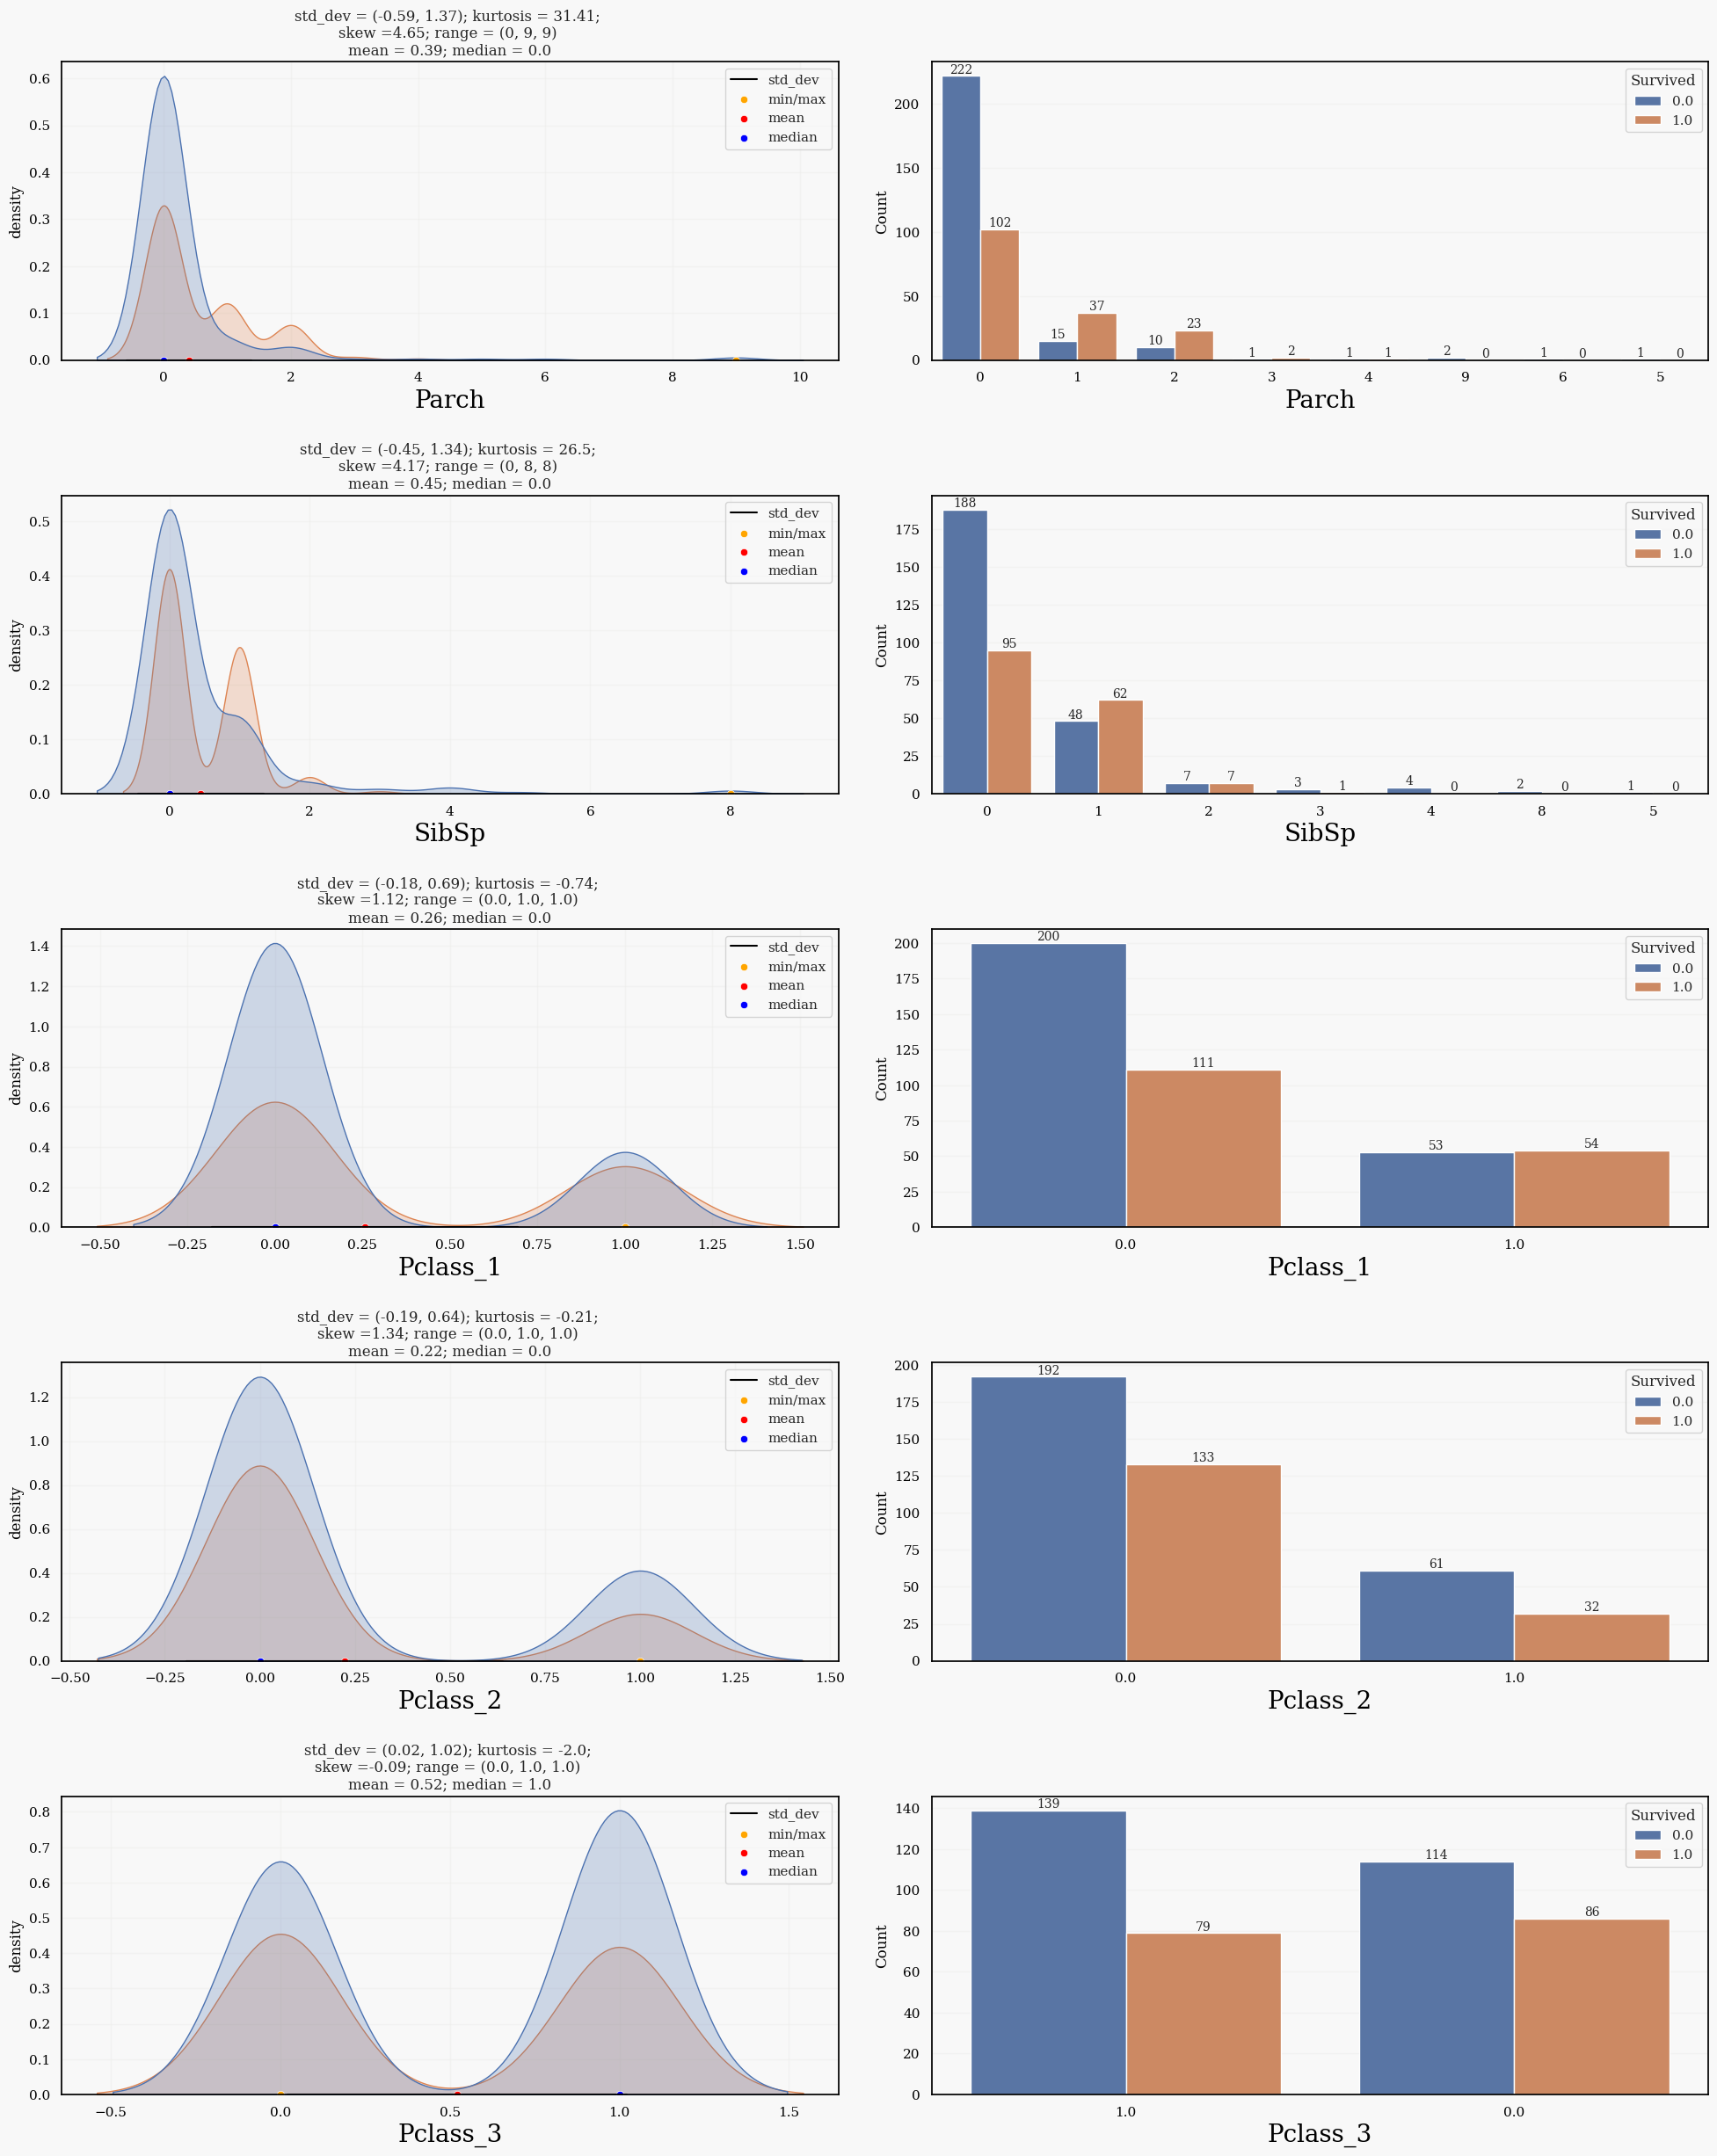

In [96]:
last_test = test_new.copy()
last_test['Survived'] = output
UVA_numeric_discrete_on_target(last_test, ['Parch','SibSp','Pclass_1','Pclass_2','Pclass_3'])

#### Looks good.(^-^) Thanks for reading.

In [97]:
data_full_baseline.columns

Index(['PassengerId', 'Survived', 'set', 'SibSp', 'Parch', 'Fare_final',
       'sqrt_Age_final', 'sqrt_Age_final+Fare_final',
       'Fare_final-sqrt_Age_final', 'sqrt_Age_final/Fare_final', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'formal_titles_ Capt', 'formal_titles_ Col',
       'formal_titles_ Don', 'formal_titles_ Dona', 'formal_titles_ Dr',
       'formal_titles_ Jonkheer', 'formal_titles_ Lady',
       'formal_titles_ Major', 'formal_titles_ Master', 'formal_titles_ Miss',
       'formal_titles_ Mlle', 'formal_titles_ Mme', 'formal_titles_ Mr',
       'formal_titles_ Mrs', 'formal_titles_ Ms', 'formal_titles_ Rev',
       'formal_titles_ Sir', 'formal_titles_ the Countess', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Age_category_Adult',
       'Age_category_Child', 'Age_category_Elders', 'Age_category_Teenager'],
      dtype='object')

In [98]:
submission = pd.concat([data_full_baseline.loc[(data_full_baseline.set =='Test')]['PassengerId'],last_test['Survived']],axis =1).reset_index(drop=True)
submission

PassengerId  Survived
0            892      0.00
1            893      1.00
2            894      0.00
3            895      0.00
4            896      1.00
..           ...       ...
413         1305      0.00
414         1306      1.00
415         1307      0.00
416         1308      0.00
417         1309      1.00

[418 rows x 2 columns]

In [99]:
submission.to_csv('submission.csv', index=False)